The notebook performs primary processing of scRNA-seq data (AnnData .h5ad format) for a selected subset of epithelial cells, with the option of additional filtering by annotations (e.g., Goblet/Immature Goblet) and diagnosis (e.g., Healthy adult).
Next, a QC report is generated for each group (distribution of counts/genes/mt/ribo, top-expressed genes, and one-vs-rest markers), and Scrublet duplicates are detected by batch (Sample).

In [23]:
import numpy as np
import pandas as pd
import scanpy as sc
from scipy import sparse
from scipy.sparse import issparse, csr_matrix
from scipy.stats import mannwhitneyu
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import warnings
import re
from IPython.display import clear_output

In [24]:
# -----------------------------
# Global settings
# -----------------------------

# Reproducibility
RANDOM_STATE = 123
np.random.seed(RANDOM_STATE)

# Scanpy / matplotlib defaults
sc.settings.verbosity = 2          # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(
    dpi=100,
    frameon=True,
    fontsize=10
)

plt.rcParams.update({
    "figure.figsize": (6, 4),
    "axes.grid": False,
    "savefig.dpi": 300,
    "savefig.bbox": "tight"
})

# Silence non-critical warnings for cleaner notebooks
warnings.filterwarnings("once", category=UserWarning)
warnings.filterwarnings("once", category=RuntimeWarning)


In [25]:
# -----------------------------
# Input / Output parameters
# -----------------------------

# 10x matrix (.h5) and cell annotations (.csv.gz)
MATRIX_H5_PATH = "GSE178341_crc10x_full_c295v4_submit.h5"
ANNOT_CSV_PATH = "GSE178341_crc10x_full_c295v4_submit_cluster.csv.gz"

# Output directories (created if not exist)
OUT_DIR = Path("outputs")
FIG_DIR = OUT_DIR / "figures"
TABLE_DIR = OUT_DIR / "tables"

OUT_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR.mkdir(parents=True, exist_ok=True)
TABLE_DIR.mkdir(parents=True, exist_ok=True)

# Save figures to disk (True) or only show inline (False)
SAVE_FIGS = False

# Optional: save processed AnnData
SAVE_ADATA = False
OUT_ADATA_PATH = OUT_DIR / "adata_processed.h5ad"

print("Matrix (.h5):", MATRIX_H5_PATH)
print("Annotations (.csv.gz):", ANNOT_CSV_PATH)
print("Output dir:", OUT_DIR.resolve())
print("Save figures:", SAVE_FIGS)
print("Save AnnData:", SAVE_ADATA)


Matrix (.h5): GSE178341_crc10x_full_c295v4_submit.h5
Annotations (.csv.gz): GSE178341_crc10x_full_c295v4_submit_cluster.csv.gz
Output dir: /mnt/sda/amilek/10x_datasets/GSE178341/outputs
Save figures: False
Save AnnData: False


In [26]:
# -----------------------------
# 1) Load 10x matrix (.h5) as raw counts
# -----------------------------
adata = sc.read_10x_h5(MATRIX_H5_PATH)

# Make identifiers unique (10x gene symbols can contain duplicates)
adata.var_names_make_unique()
adata.obs_names_make_unique()

# Ensure sparse CSR + float32 to reduce RAM footprint
if sparse.issparse(adata.X):
    if not isinstance(adata.X, sparse.csr_matrix):
        adata.X = adata.X.tocsr()
    if adata.X.dtype != np.float32:
        adata.X = adata.X.astype(np.float32)
else:
    adata.X = sparse.csr_matrix(adata.X.astype(np.float32))

# Keep an explicit raw-counts layer (optional but convenient downstream)
if "counts" not in adata.layers:
    adata.layers["counts"] = adata.X

print("10x matrix loaded (raw counts).")
print(f"Shape: {adata.n_obs:,} cells × {adata.n_vars:,} genes | X dtype: {adata.X.dtype}")

# -----------------------------
# 2) Load annotation table (.csv.gz) and attach to adata.obs
# -----------------------------
ann = pd.read_csv(ANNOT_CSV_PATH, compression="infer")
print(f"Annotation loaded: {ann.shape[0]:,} rows × {ann.shape[1]:,} cols")

# Identify barcode column in annotation table
candidate_cols = ["barcode", "Barcode", "cell", "Cell", "cell_id", "CellID", "Cell_ID", "index", "Index"]
barcode_col = next((c for c in candidate_cols if c in ann.columns), ann.columns[0])
print(f"Using '{barcode_col}' as barcode column.")

# Normalize barcodes to match 10x naming (handle '-1' suffix differences)
def _strip_10x_suffix(x: str) -> str:
    return str(x).split("-")[0]

ann["_barcode_norm"] = ann[barcode_col].map(_strip_10x_suffix)
adata.obs["_barcode_norm"] = pd.Index(adata.obs_names).map(_strip_10x_suffix)

# Add columns one-by-one aligned by normalized barcode
ann_idx = ann.set_index("_barcode_norm", drop=True)

cols_to_add = [c for c in ann_idx.columns]  # keep ALL annotation columns
for c in cols_to_add:
    adata.obs[c] = ann_idx[c].reindex(adata.obs["_barcode_norm"]).values

# Quick match diagnostics
annotated_cells = int(pd.notna(adata.obs[cols_to_add]).any(axis=1).sum()) if cols_to_add else 0
print(f"Annotation columns added to adata.obs: {len(cols_to_add)}")
print(f"Cells with at least one non-null annotation: {annotated_cells:,} / {adata.n_obs:,}")

# Optional: drop helper column
# adata.obs.drop(columns=["_barcode_norm"], inplace=True)

reading GSE178341_crc10x_full_c295v4_submit.h5


/mnt/sda/amilek/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


 (0:00:24)


/mnt/sda/amilek/miniconda3/lib/python3.13/site-packages/anndata/_core/anndata.py:1794: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")
/tmp/ipykernel_4175931/2645775432.py:7: UserWarning: Suffix used (-[0-9]+) to deduplicate index values may make index values difficult to interpret. There values with a similar suffixes in the index. Consider using a different delimiter by passing `join={delimiter}`. Example key collisions generated by the make_index_unique algorithm: ['SNORD116-1', 'SNORD116-2', 'SNORD116-3', 'SNORD116-5', 'SNORD116-6']
  adata.var_names_make_unique()


10x matrix loaded (raw counts).
Shape: 370,115 cells × 43,113 genes | X dtype: float32
Annotation loaded: 370,115 rows × 6 cols
Using 'sampleID' as barcode column.
Annotation columns added to adata.obs: 6
Cells with at least one non-null annotation: 370,115 / 370,115


In [27]:
# -----------------------------
# Normalize core metadata: Patient_ID + Tissue_type
# -----------------------------
# Goal:
# 1) Extract patient ID (e.g. C103) into a dedicated column `Patient_ID`
# 2) Extract tissue type (N/T - Normal or Tumor) into a dedicated column `Tissue_type`
# from existing metadata columns (sampleID / batchID).

SOURCE_COLS = ["sampleID", "batchID"]

def _first_present(cols):
    col = next((c for c in cols if c in adata.obs.columns), None)
    if col is None:
        raise KeyError(f"None of the expected columns found in adata.obs: {cols}")
    return col

def _extract_patient_id(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r"(C\d{3})", str(x))
    return m.group(1) if m else np.nan

def _extract_tissue_type(x):
    """
    Extract tissue label 'N' or 'T' from strings like:
      C103_T_1_1_0_c1_v2_id
      C173_N_0_0_0_c1_v3_id
    We look for '_N_' or '_T_' boundaries to avoid accidental matches.
    """
    if pd.isna(x):
        return np.nan
    s = str(x)
    m = re.search(r"_(N|T)_", s)
    if m:
        return m.group(1)
    # fallback: sometimes format may be 'C103T...' 
    m2 = re.search(r"\b(N|T)\b", s)
    return m2.group(1) if m2 else np.nan

# Choose source column (prefer sampleID)
source_col = _first_present(SOURCE_COLS)

# Create normalized columns
adata.obs["Patient_ID"] = adata.obs[source_col].map(_extract_patient_id)
adata.obs["Tissue_type"] = adata.obs[source_col].map(_extract_tissue_type)

# -----------------------------
# Sanity checks
# -----------------------------
n_total = adata.n_obs

n_missing_pid = int(adata.obs["Patient_ID"].isna().sum())
n_missing_tis = int(adata.obs["Tissue_type"].isna().sum())

print(f"Metadata extracted from column: '{source_col}'")
print(f"Missing Patient_ID:  {n_missing_pid:,} / {n_total:,} cells")
print(f"Missing Tissue_type: {n_missing_tis:,} / {n_total:,} cells")

print("\nTop Patient_ID counts:")
display(adata.obs["Patient_ID"].value_counts().head(10))

print("\nTissue_type distribution (N/T):")
display(adata.obs["Tissue_type"].value_counts(dropna=False))

adata.obs

Metadata extracted from column: 'sampleID'
Missing Patient_ID:  0 / 370,115 cells
Missing Tissue_type: 23,020 / 370,115 cells

Top Patient_ID counts:


Patient_ID
C162    22587
C124    16945
C171    16199
C123    14572
C126    12914
C125    12660
C129    12577
C170    12522
C130    11327
C139    10468
Name: count, dtype: int64


Tissue_type distribution (N/T):


Tissue_type
T      234231
N      112864
NaN     23020
Name: count, dtype: int64

_barcode_norm  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT  C103_T_1_1_0_c1_v2_id   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT  C103_T_1_1_0_c1_v2_id   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG  C103_T_1_1_0_c1_v2_id   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT  C103_T_1_1_0_c1_v2_id   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC  C103_T_1_1_0_c1_v2_id   
...                                                       ...   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC  C173_T_0_0_0_c1_v3_id   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG  C173_T_0_0_0_c1_v3_id   
C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC  C173_T_0_0_0_c1_v3_id   
C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT  C173_T_0_0_0_c1_v3_id   
C173_T_0_0_0_c1_v3_id-TTTGTTGTCGTTCCCA  C173_T_0_0_0_c1_v3_id   

                                                                      sampleID  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT  C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT  C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG  C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT  C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC  C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC   
...                                                                        ...   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC  C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG  C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG   
C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC  C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC   
C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT  C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT   
C173_T_0_0_0_c1_v3_id-TTTGTTGTCGTTCCCA  C173_T_0_0_0_c1_v3_id-TTTGTTGTCGTTCCCA   

                                                   batchID clTopLevel  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT  C103_T_1_1_0_c1_v2        Epi   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT  C103_T_1_1_0_c1_v2        Epi   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG  C103_T_1_1_0_c1_v2        Epi   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT  C103_T_1_1_0_c1_v2        Epi   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC  C103_T_1_1_0_c1_v2        Epi   
...                                                    ...        ...   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC  C173_T_0_0_0_c1_v3    Myeloid   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG  C173_T_0_0_0_c1_v3        Epi   
C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC  C173_T_0_0_0_c1_v3        Epi   
C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT  C173_T_0_0_0_c1_v3     TNKILC   
C173_T_0_0_0_c1_v3_id-TTTGTTGTCGTTCCCA  C173_T_0_0_0_c1_v3        Epi   

                                       clMidwayPr cl295v11SubShort  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT        Epi             cE01   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT        Epi             cE01   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG        Epi             cE03   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT        Epi             cE01   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC        Epi             cE01   
...                                           ...              ...   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCATCGGGC      Macro             cM02   
C173_T_0_0_0_c1_v3_id-TTTGGAGTCTAGTGTG        Epi             cE03   
C173_T_0_0_0_c1_v3_id-TTTGTTGCAGCAATTC        Epi             cE03   
C173_T_0_0_0_c1_v3_id-TTTGTTGGTTCTGAGT       TCD4           cTNI08   
C173_T_0_0_0_c1_v3_id-TTTGTTGTCGTTCCCA        Epi             cE02   

                                                            cl295v11SubFull  \
C103_T_1_1_0_c1_v2_id-AAACCTGCATGCTAGT                  cE01 (Stem/TA-like)   
C103_T_1_1_0_c1_v2_id-AAACCTGGTAGCCTAT                  cE01 (Stem/TA-like)   
C103_T_1_1_0_c1_v2_id-AAACCTGGTTGTCGCG           cE03 (Stem/TA-like prolif)   
C103_T_1_1_0_c1_v2_id-AAACCTGTCATGTGGT                  cE01 (Stem/TA-like)   
C103_T_1_1_0_c1_v2_id-AAACCTGTCCTTGGTC                  cE01 (Stem/TA-like)   
...                                                                     ...   
C173_T_0_0_

In [28]:
# ============================================================
# DATASET-SPECIFIC SETUP (this block is expected to change)
# ============================================================

# --- Column mapping (edit to match your dataset) ---
CELL_COL    = "cl295v11SubFull"   # grouping for QC-by-group 
BATCH_COL    = "batchID"          # batch/sample key for Scrublet-by-batch


# --- Filters (edit / extend as needed) ---
# Use None to skip a filter.
FILTERS = {
    # column: allowed_values
    # Example: "clTopLevel": ["Epi"],
    # Example: "Diagnosis": ["Healthy adult"],
}

# Optional: exclude specific values
EXCLUDE = {
    # column: excluded_values
    # Example: "patient": ["C124"],
}

# -----------------------------
# Apply dataset-specific filters
# -----------------------------
n0 = adata.n_obs

# Include filters
for col, allowed in FILTERS.items():
    if col not in adata.obs.columns:
        raise KeyError(f"FILTERS refers to missing column in adata.obs: '{col}'")
    if allowed is None:
        continue
    allowed = set(allowed)
    adata = adata[adata.obs[col].isin(allowed)].copy()

# Exclude filters
for col, excluded in EXCLUDE.items():
    if col not in adata.obs.columns:
        raise KeyError(f"EXCLUDE refers to missing column in adata.obs: '{col}'")
    if excluded is None:
        continue
    excluded = set(excluded)
    adata = adata[~adata.obs[col].isin(excluded)].copy()

print(f"Subset applied: {n0:,}  {adata.n_obs:,} cells")

# -----------------------------
# Compact summaries of key columns
# -----------------------------
def _vc(col, top=10):
    if col is None or col not in adata.obs.columns:
        return
    s = adata.obs[col].value_counts(dropna=False)
    print(f"\nValue counts: {col} (top {min(top, len(s))} / {len(s)})")
    print(s.head(top))

_vc(BATCH_COL, top=10)
_vc(CELL_COL, top=10)


Subset applied: 370,115 → 370,115 cells

Value counts: batchID (top 10 / 180)
batchID
C171_TA_1_1_1_c1_v3    6865
C123_T_1_1_0_c1_v2     5802
C166_T_0_0_0_c1_v3     5527
C124_N_0_3_1_c1_v2     5517
C103_T_1_1_0_c1_v2     5223
C170_T_0_0_1_c1_v3     5035
C170_T_0_0_0_c1_v3     5019
C157_T_0_0_0_c1_v3     4757
C163_T_1_1_0_c1_v3     4717
C124_N_0_3_0_c1_v2     4600
Name: count, dtype: int64

Value counts: cl295v11SubFull (top 10 / 87)
cl295v11SubFull
cE01 (Stem/TA-like)                    61953
cE03 (Stem/TA-like prolif)             42850
cP1 (Plasma IgA)                       20305
cM02 (Macrophage-like)                 20280
cP2 (Plasma IgG)                       16438
cM01 (Monocyte)                        14242
cE02 (Stem/TA-like/Immature Goblet)    13747
cE05 (Enterocyte 2)                    12973
cB2 (B GC-like)                        11980
cE06 (Immature Goblet)                 10084
Name: count, dtype: int64


In [29]:
# -----------------------------
# QC + mt / ribo masks
# -----------------------------

# Mitochondrial genes (human-style: MT-*)
adata.var["mt"] = adata.var_names.str.upper().str.startswith("MT-")

# Ribosomal genes (default: RPS* or RPL*). 
if "ribo" not in adata.var.columns:
    g = adata.var_names.str.upper()
    adata.var["ribo"] = g.str.startswith("RPS") | g.str.startswith("RPL")

# -----------------------------
# Compute QC metrics
# -----------------------------
sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True
)

# -----------------------------
# Sanity checks: required QC columns
# -----------------------------
required_qc_cols = [
    "total_counts",
    "n_genes_by_counts",
    "pct_counts_mt",
    "pct_counts_ribo",
]
missing = [c for c in required_qc_cols if c not in adata.obs.columns]
if missing:
    raise RuntimeError(f"QC metrics missing from adata.obs after calculate_qc_metrics: {missing}")

print("QC metrics computed.")
print("QC columns OK:", required_qc_cols)

# Compact summary to catch obvious issues early
qc_preview = adata.obs[["total_counts", "n_genes_by_counts", "pct_counts_mt", "pct_counts_ribo"]].describe()
display(qc_preview)


QC metrics computed.
QC columns OK: ['total_counts', 'n_genes_by_counts', 'pct_counts_mt', 'pct_counts_ribo']


total_counts  n_genes_by_counts  pct_counts_mt  pct_counts_ribo
count  370115.000000      370115.000000  370115.000000    370115.000000
mean    12845.516602        2065.467520      15.040960        22.456129
std     21302.007812        1830.989716      12.730199        13.236041
min       501.000000         199.000000       0.000000         0.000000
25%      2167.000000         763.000000       4.825207        12.053682
50%      5180.000000        1370.000000      10.810332        21.369295
75%     14647.000000        2780.000000      22.490019        31.160460
max    583596.000000       11683.000000      49.991871        86.590645

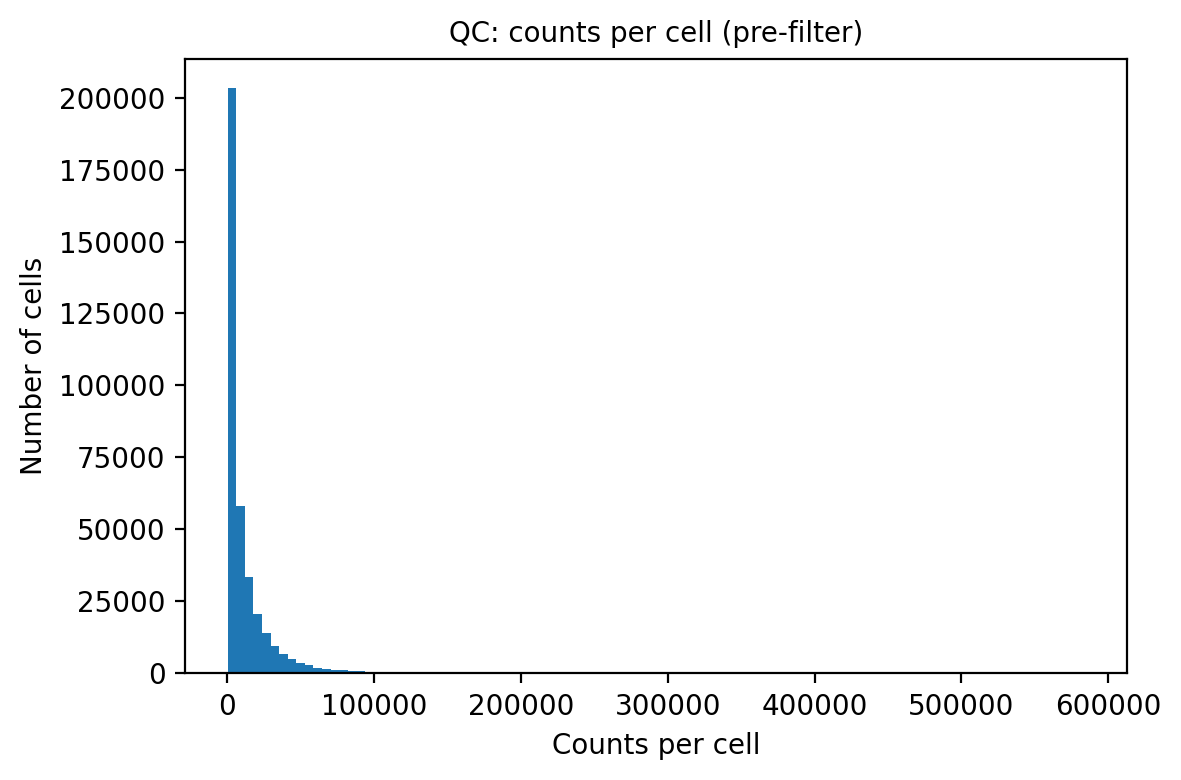

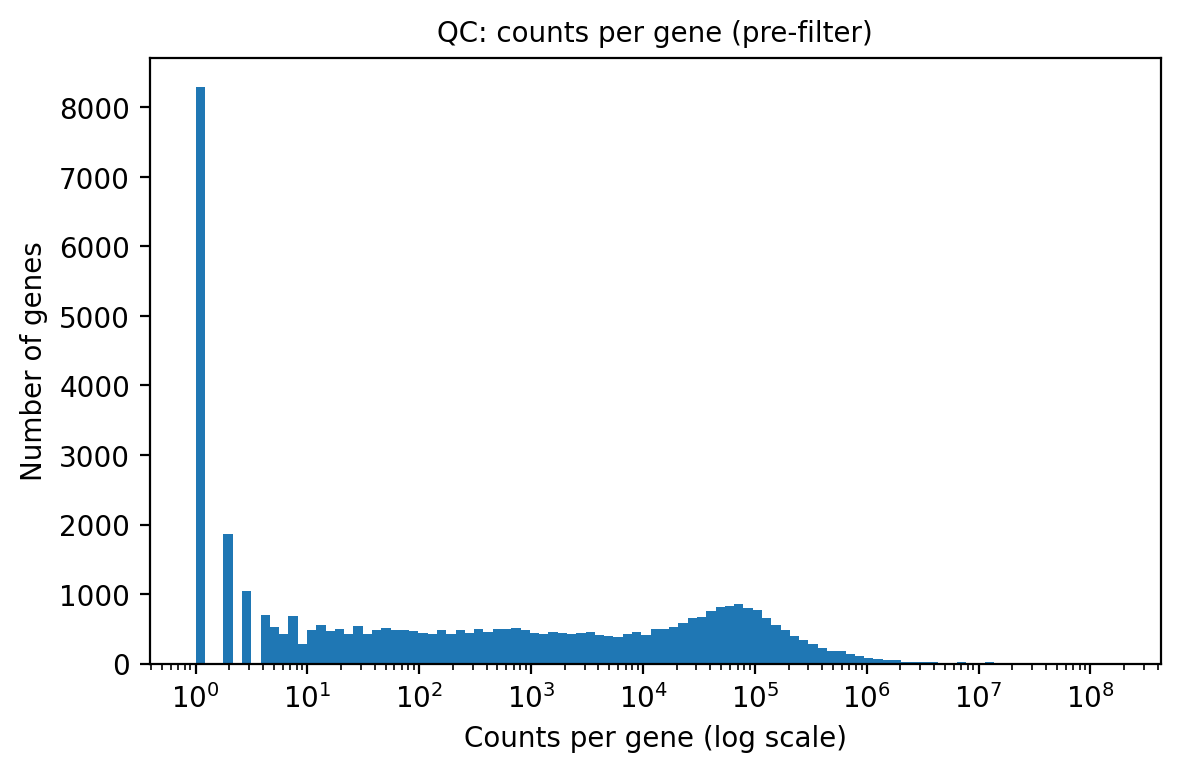

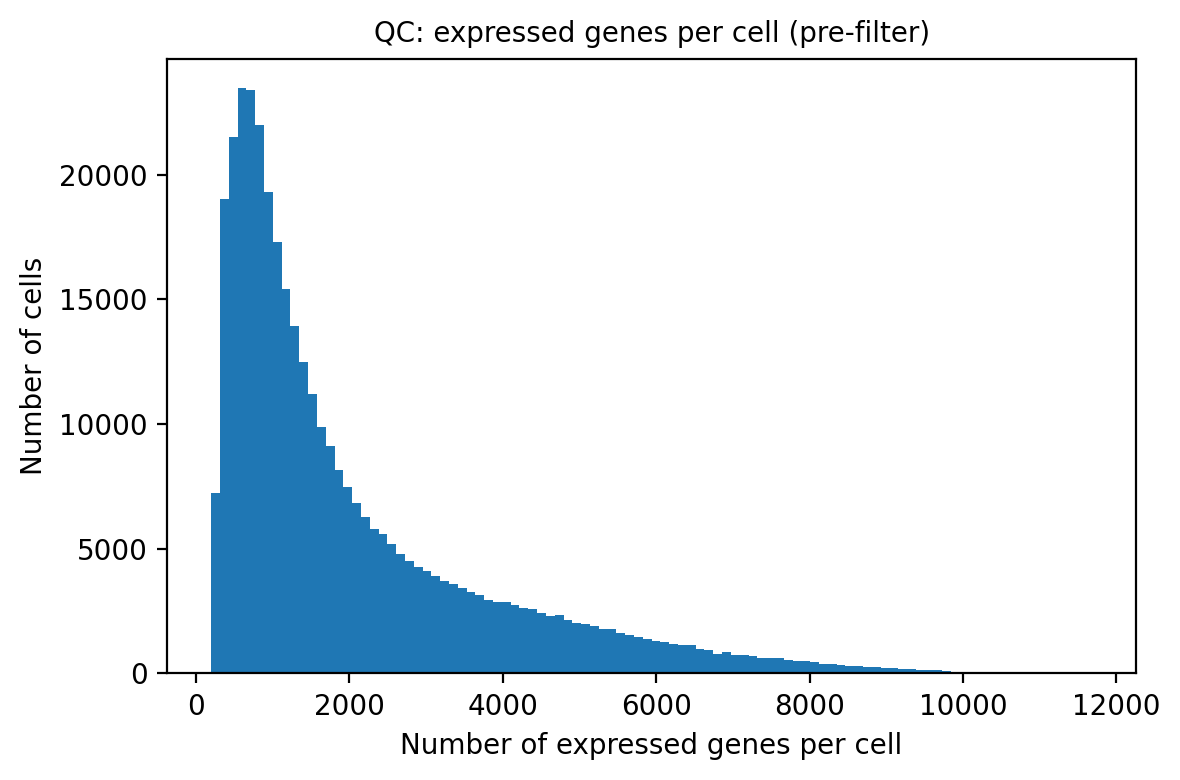

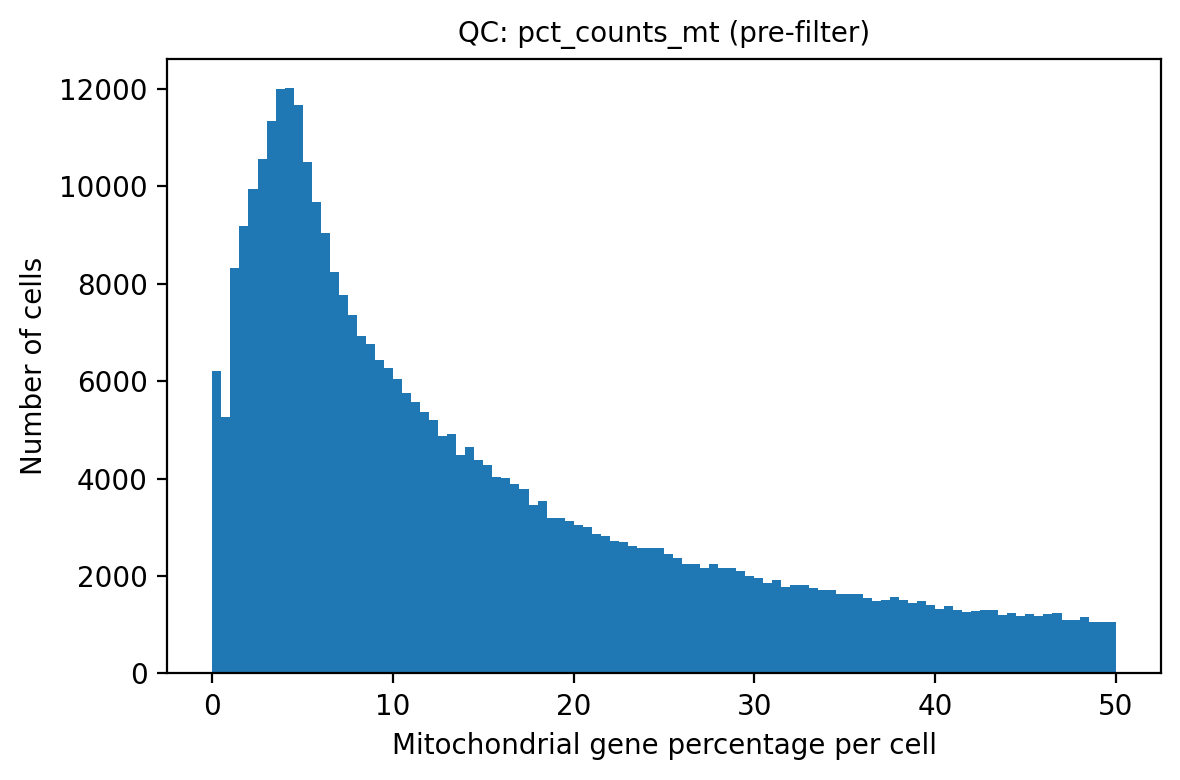

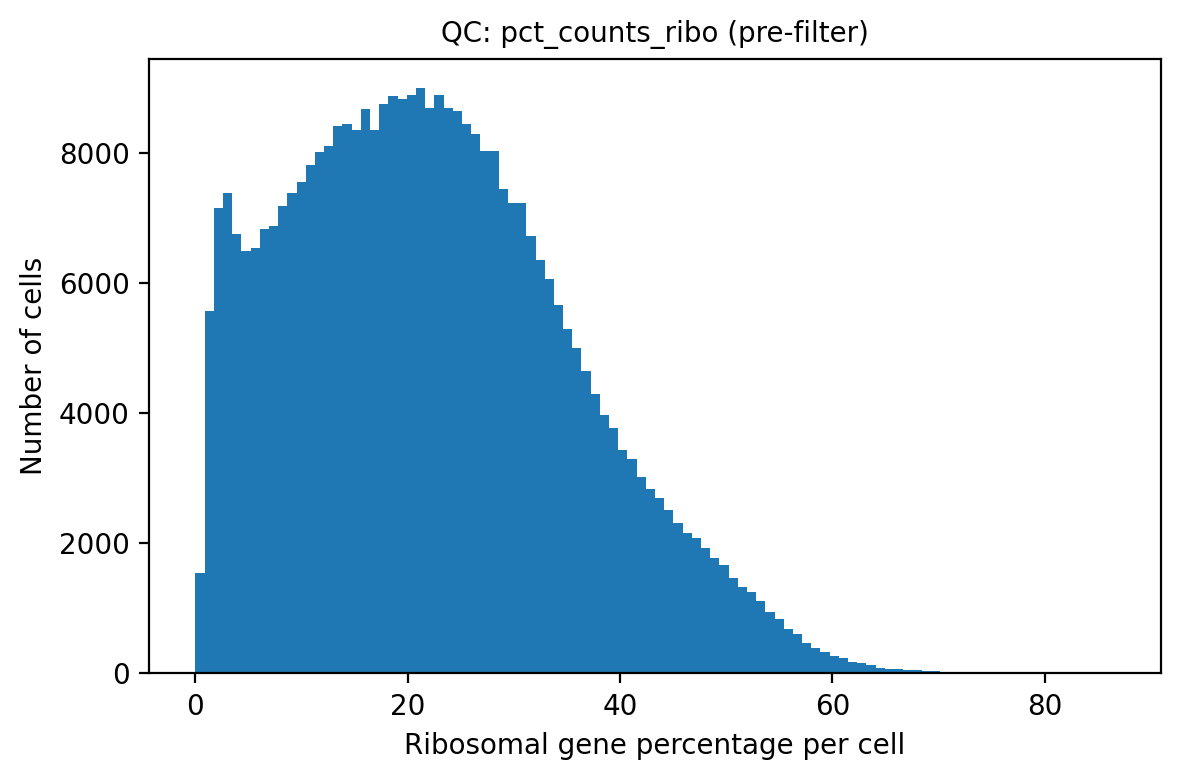

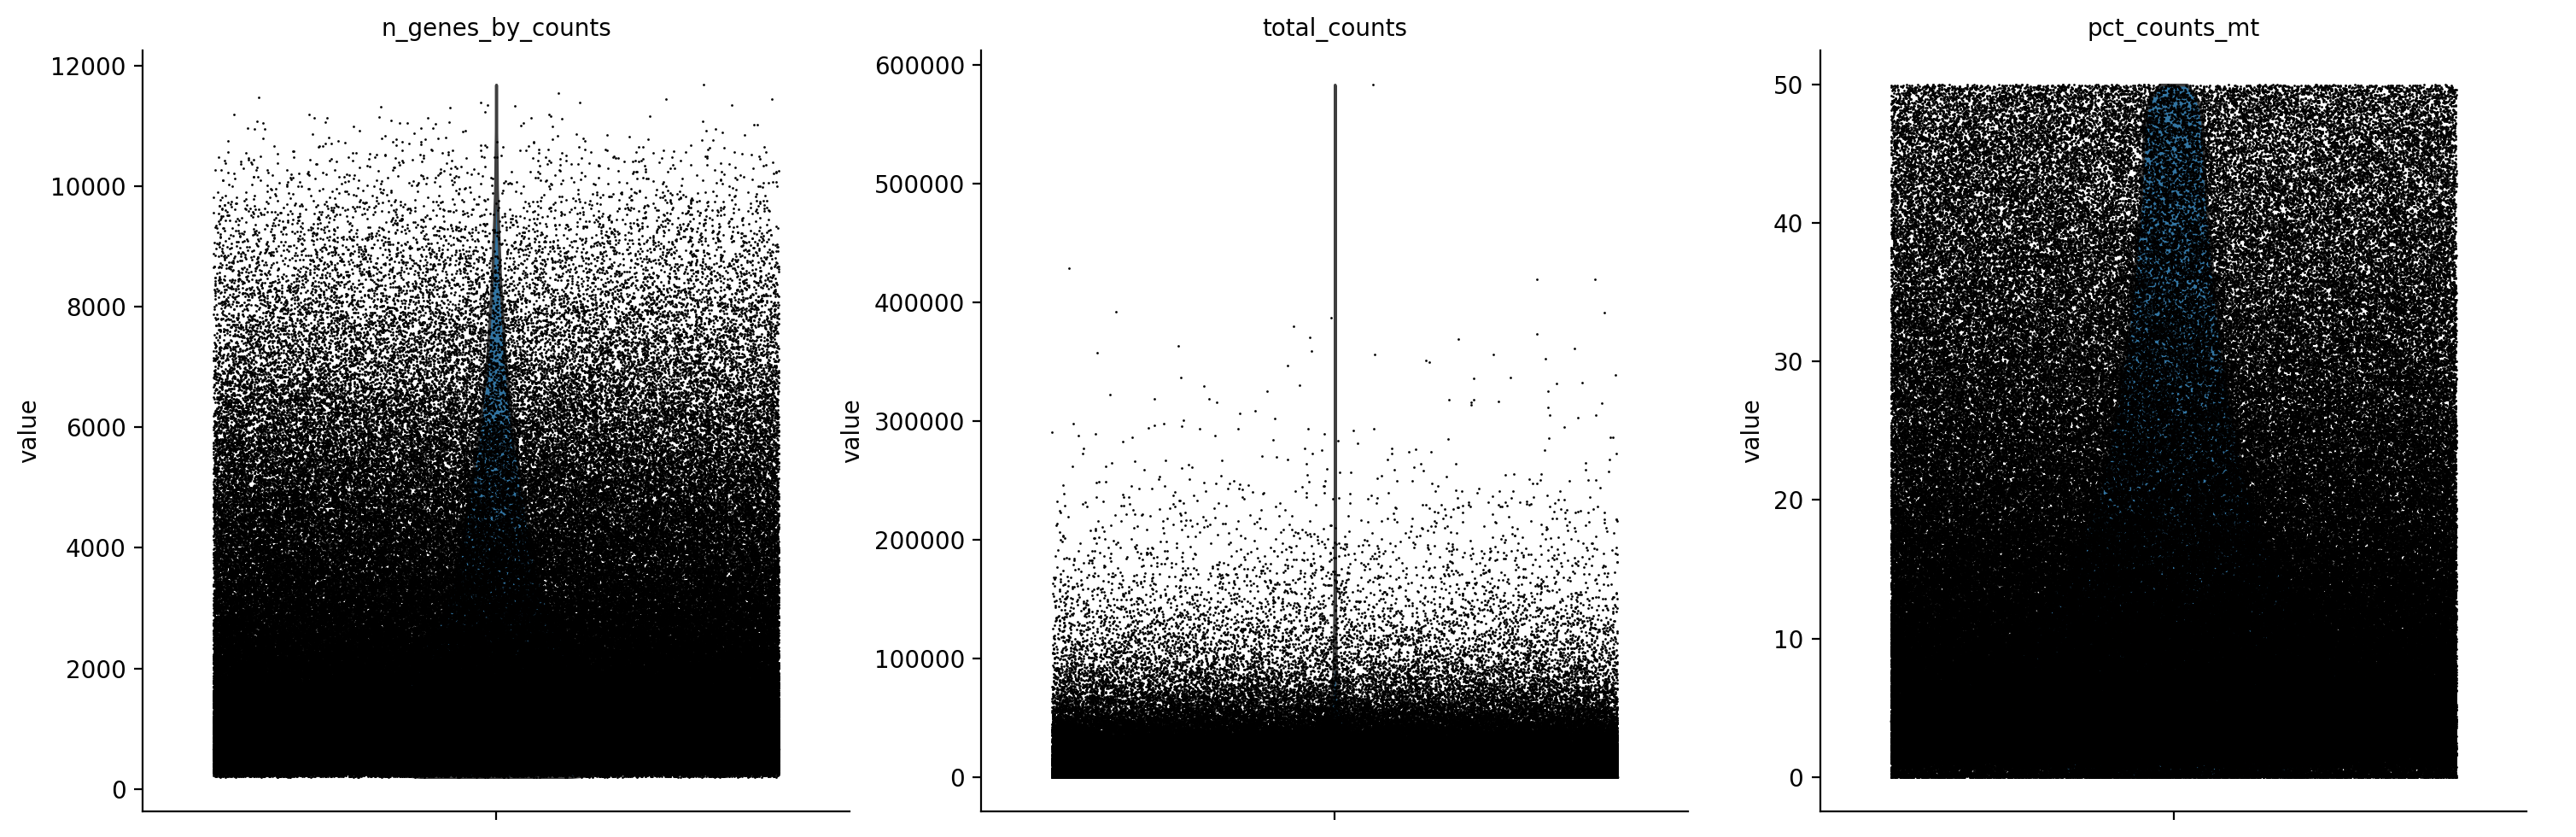

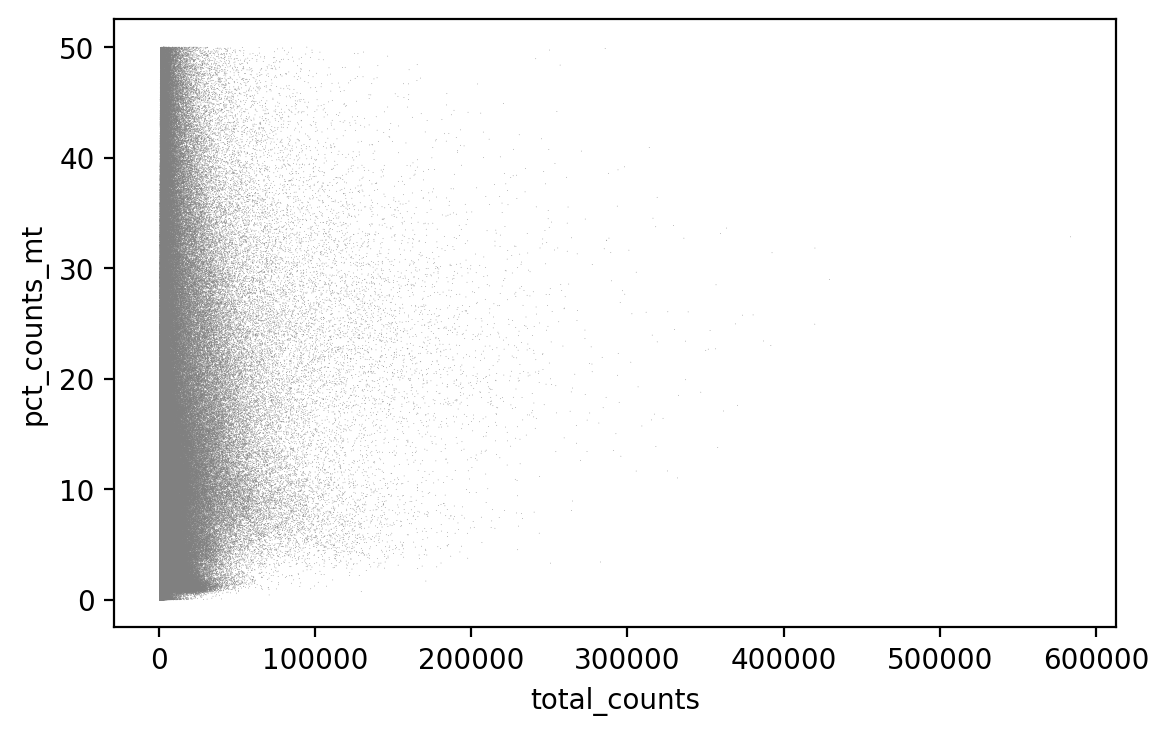

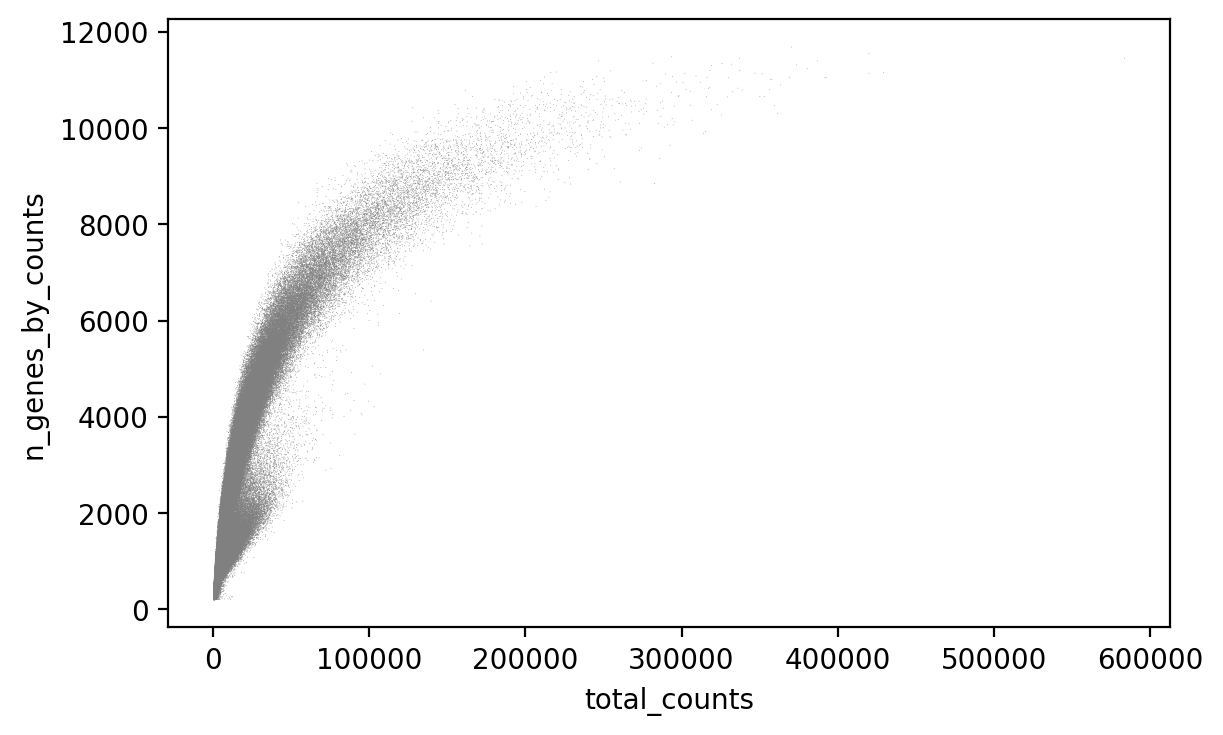

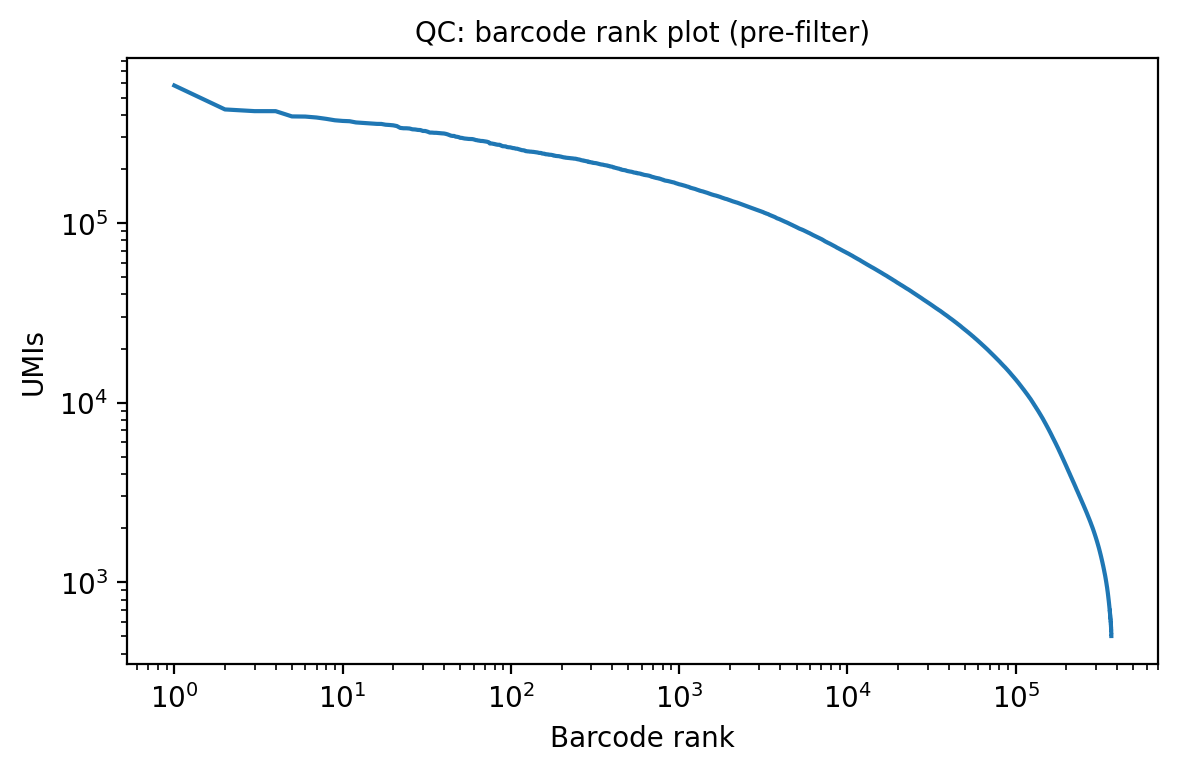

In [30]:
# -----------------------------
# QC plots 
# -----------------------------

# Ensure unique gene names 
adata.var_names_make_unique()

# Helper to safely get 1D arrays from sparse/dense
def _to_1d(a):
    if sparse.issparse(a):
        a = a.A
    return np.asarray(a).ravel()

# Counts per cell / gene
counts_per_cell = _to_1d(adata.X.sum(axis=1))
counts_per_gene = _to_1d(adata.X.sum(axis=0)) + 1.0
expressed_genes_per_cell = _to_1d((adata.X > 0).sum(axis=1))

# 1) Histogram: counts per cell
plt.figure(figsize=(6, 4))
plt.hist(counts_per_cell, bins=100)
plt.xlabel("Counts per cell")
plt.ylabel("Number of cells")
plt.title("QC: counts per cell (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_hist_counts_per_cell_prefilter.png")
plt.show()

# 2) Histogram: counts per gene (log scale)
plt.figure(figsize=(6, 4))
bins = np.logspace(0, np.log10(counts_per_gene.max()), 100)
plt.hist(counts_per_gene, bins=bins)
plt.xscale("log")
plt.xlabel("Counts per gene (log scale)")
plt.ylabel("Number of genes")
plt.title("QC: counts per gene (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_hist_counts_per_gene_prefilter.png")
plt.show()

# 3) Histogram: expressed genes per cell
plt.figure(figsize=(6, 4))
plt.hist(expressed_genes_per_cell, bins=100)
plt.xlabel("Number of expressed genes per cell")
plt.ylabel("Number of cells")
plt.title("QC: expressed genes per cell (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_hist_expressed_genes_per_cell_prefilter.png")
plt.show()

# 4) Histogram: mitochondrial percentage
plt.figure(figsize=(6, 4))
plt.hist(adata.obs["pct_counts_mt"].astype(float).values, bins=100)
plt.xlabel("Mitochondrial gene percentage per cell")
plt.ylabel("Number of cells")
plt.title("QC: pct_counts_mt (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_hist_pct_counts_mt_prefilter.png")
plt.show()

# 5) Histogram: ribosomal percentage
plt.figure(figsize=(6, 4))
plt.hist(adata.obs["pct_counts_ribo"].astype(float).values, bins=100)
plt.xlabel("Ribosomal gene percentage per cell")
plt.ylabel("Number of cells")
plt.title("QC: pct_counts_ribo (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_hist_pct_counts_ribo_prefilter.png")
plt.show()

# 6) Violin summary (Scanpy)
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
    show=not SAVE_FIGS
)
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_violin_prefilter.png")
    plt.show()

# 7) Scatter: total_counts vs pct_counts_mt
sc.pl.scatter(
    adata,
    x="total_counts",
    y="pct_counts_mt",
    show=not SAVE_FIGS
)
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_scatter_total_counts_vs_pct_mt_prefilter.png")
    plt.show()

# 8) Scatter: total_counts vs n_genes_by_counts
sc.pl.scatter(
    adata,
    x="total_counts",
    y="n_genes_by_counts",
    show=not SAVE_FIGS
)
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_scatter_total_counts_vs_n_genes_prefilter.png")
    plt.show()

# 9) Barcode rank plot (UMIs)
s = np.sort(counts_per_cell)[::-1]
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(s) + 1), s)
plt.yscale("log")
plt.xscale("log")
plt.xlabel("Barcode rank")
plt.ylabel("UMIs")
plt.title("QC: barcode rank plot (pre-filter)")
plt.tight_layout()
if SAVE_FIGS:
    plt.savefig(FIG_DIR / "qc_barcode_rank_prefilter.png")
plt.show()


In [31]:
# -----------------------------
# Scrublet-by-batch 
# -----------------------------

score_key = "doublet_score_scrublet"
call_key  = "doublet_call_scrublet"
batch_key = BATCH_COL
min_cells = 200

# Choose matrix for Scrublet (counts preferred)
if "counts" in adata.layers:
    print("Using 'counts' layer as Scrublet input matrix.")
    adata_tmp = adata.copy()
    adata_tmp.X = adata_tmp.layers["counts"]
else:
    print("Layer 'counts' not found — using adata.X as-is.")
    adata_tmp = adata

adata.obs[score_key] = np.nan
adata.obs[call_key]  = False

batches = list(adata_tmp.obs[batch_key].unique())
print(f"Running Scrublet by batches from '{batch_key}' ({len(batches)} batches)...")

rows = []

# Suppress Scanpy/Scrublet internal prints during each run
class _NullWriter:
    def write(self, *_): pass
    def flush(self): pass

for i, b in enumerate(batches, 1):
    idx = adata_tmp.obs[adata_tmp.obs[batch_key] == b].index
    n = len(idx)

    # Notebook-style single-line progress (no log spam)
    clear_output(wait=True)
    print(f"Running Scrublet by batches from '{batch_key}' ({len(batches)} batches)...")
    print(f"Batch {i}/{len(batches)}: {b} ({n} cells)...")

    if n < min_cells:
        rows.append((b, n, np.nan, "skipped_small_batch"))
        continue

    sub = adata_tmp[idx].copy()
    max_pcs = int(min(sub.n_obs, sub.n_vars) - 1)
    n_pcs = max(5, min(30, max_pcs))
    if n_pcs < 5:
        rows.append((b, n, np.nan, "skipped_low_rank"))
        continue

    # Silence scrublet internal prints to keep output clean
    old_out, old_err = sys.stdout, sys.stderr
    sys.stdout, sys.stderr = _NullWriter(), _NullWriter()
    try:
        sc.pp.scrublet(sub, n_prin_comps=n_pcs)
    finally:
        sys.stdout, sys.stderr = old_out, old_err

    adata.obs.loc[sub.obs_names, score_key] = sub.obs["doublet_score"].values
    adata.obs.loc[sub.obs_names, call_key]  = sub.obs["predicted_doublet"].values

    frac = float(sub.obs["predicted_doublet"].mean())
    rows.append((b, n, frac, "ok"))

clear_output(wait=True)
print("All batches processed.\n")

report_df = (
    pd.DataFrame(rows, columns=[batch_key, "n_cells", "frac_doublets", "status"])
    .sort_values(batch_key)
    .reset_index(drop=True)
)
display(report_df)

All batches processed.



batchID  n_cells  frac_doublets status
0     C103_T_1_1_0_c1_v2     5223       0.000766     ok
1     C103_T_1_1_3_c1_v2      873       0.000000     ok
2     C104_T_1_1_0_c1_v2     2241       0.000892     ok
3     C104_T_1_1_3_c1_v2      645       0.000000     ok
4     C105_T_1_1_0_c1_v2     2233       0.000896     ok
..                   ...      ...            ...    ...
175  C171_TA_1_1_1_c1_v3     6865       0.000000     ok
176  C171_TB_1_1_0_c1_v3     2623       0.000762     ok
177  C171_TB_1_1_1_c1_v3     2867       0.000698     ok
178   C172_T_0_0_0_c1_v3     1542       0.001297     ok
179   C173_T_0_0_0_c1_v3     2649       0.000000     ok

[180 rows x 4 columns]

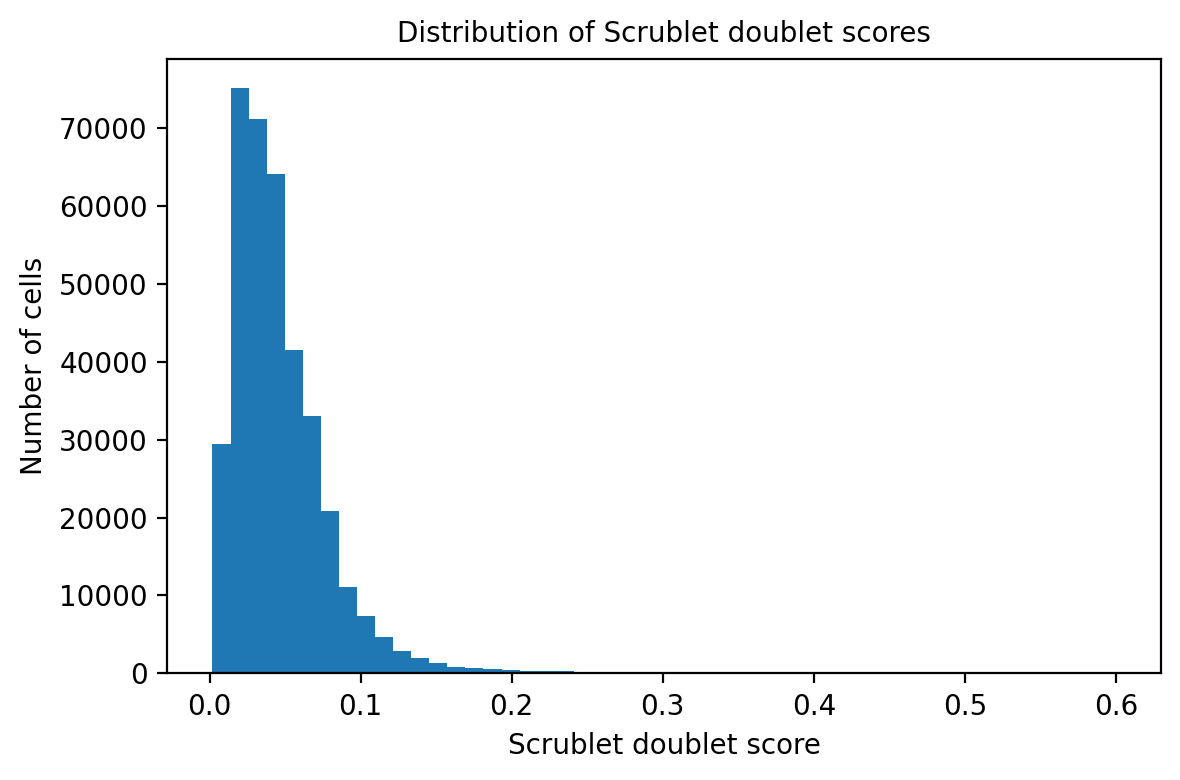

/tmp/ipykernel_4175931/129303217.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(BATCH_COL)["doublet_call_scrublet"]


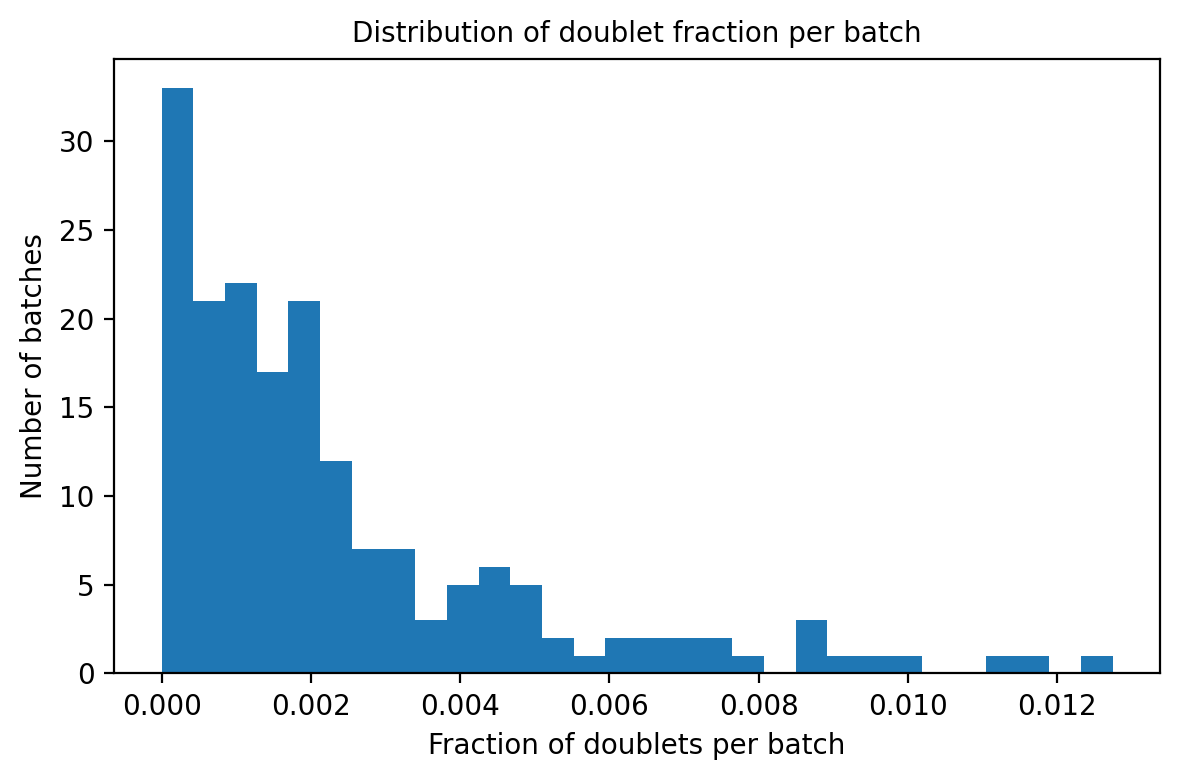

Cells before doublet removal: 370,115 → after: 369,286 (removed 829 doublets)


In [32]:
# -----------------------------
# Scrublet QC: score distribution
# -----------------------------
plt.figure(figsize=(6, 4))
plt.hist(
    adata.obs["doublet_score_scrublet"].dropna(),
    bins=50
)
plt.xlabel("Scrublet doublet score")
plt.ylabel("Number of cells")
plt.title("Distribution of Scrublet doublet scores")
plt.tight_layout()
plt.show()

# -----------------------------
# Scrublet QC: fraction of doublets per batch
# -----------------------------
frac = (
    adata.obs
    .groupby(BATCH_COL)["doublet_call_scrublet"]
    .mean()
    .values
)

plt.figure(figsize=(6, 4))
plt.hist(frac, bins=30)
plt.xlabel("Fraction of doublets per batch")
plt.ylabel("Number of batches")
plt.title("Distribution of doublet fraction per batch")
plt.tight_layout()
plt.show()

# -----------------------------
# Remove predicted doublets
# -----------------------------
n0_cells = adata.n_obs
adata = adata[adata.obs["doublet_call_scrublet"] == False].copy()
n1_cells = adata.n_obs

print(
    f"Cells before doublet removal: {n0_cells:,}  after: {n1_cells:,} "
    f"(removed {n0_cells - n1_cells:,} doublets)"
)


In [33]:
# -----------------------------
# QC filtering parameters
# -----------------------------
# NOTE:
# These thresholds are intentionally defined in one place.
# They are dataset-dependent and should be adjusted based on
# the QC distributions inspected in the previous cell.
#
# For mitochondrial filtering we use a 2-stage strategy:
#   Stage 1 (global cap): remove only extreme mt% values (obvious debris).
#   Stage 2 (adaptive by cell class): within each annotated cell class,
#       compute an upper-outlier threshold using a robust statistic:
#           thr_g = median_g + MT_NMADS * MAD_g
#       and filter only in the "higher" direction (upper tail).
#
# Implementation detail (important):
# - Stage 2 thresholds are COMPUTED on cells that already pass (base filters + Stage 1),
#   i.e. on idx_stat = (group == g) & keep_after_stage1
# - Stage 2 is APPLIED to all cells in the group, but only affects cells still kept.

# -----------------------------
# Gene-level filtering
# -----------------------------
MIN_CELLS_PER_GENE = 10
# Remove genes detected in very few cells (conservative default).

# -----------------------------
# Cell-level filtering (coarse, universal)
# -----------------------------
MIN_GENES_PER_CELL = 150
# Cells with very few detected genes are likely empty droplets / low-quality.

MIN_UMI_PER_CELL = 500
# Minimum total UMI counts per cell (low-complexity / damaged cells).

# -----------------------------
# Mitochondrial filtering (two-stage)
# -----------------------------

# Stage 1: global permissive cap (safety net across ALL cells).
# This is NOT the final per-cell-type threshold; it only removes extremes.
MT_GLOBAL_CAP_PCT = 60.0

# Stage 2: robust outlier threshold per annotated cell class (metadata-driven).
# IMPORTANT: prefer author-provided labels (avoid circularity with your own clustering).
MT_GROUP_COL = "clTopLevel"

# Minimum cells per group to compute robust statistics.
# Groups smaller than this will use the fallback/cap.
MT_MIN_CELLS_PER_GROUP = 50

# Number of MADs above the median to define "upper outliers".
MT_NMADS = 4.0

# Guardrails to prevent pathological thresholds.
MT_STAGE2_MIN_PCT = 5.0
MT_STAGE2_MAX_PCT = 70.0

# Fallback threshold for small/ill-defined groups.
# If None, small groups will use MT_GLOBAL_CAP_PCT.
MT_FALLBACK_PCT = None

# -----------------------------
# Ribosomal filtering
# -----------------------------
MAX_RB_PCT = None
# Leave OFF by default

print("QC filtering parameters:")
print(f"  MIN_CELLS_PER_GENE      = {MIN_CELLS_PER_GENE}")
print(f"  MIN_GENES_PER_CELL      = {MIN_GENES_PER_CELL}")
print(f"  MIN_UMI_PER_CELL        = {MIN_UMI_PER_CELL}")
print("  --- MT two-stage (MAD) ---")
print(f"  MT_GLOBAL_CAP_PCT       = {MT_GLOBAL_CAP_PCT}")
print(f"  MT_GROUP_COL            = {MT_GROUP_COL}")
print(f"  MT_MIN_CELLS_PER_GROUP  = {MT_MIN_CELLS_PER_GROUP}")
print(f"  MT_NMADS                = {MT_NMADS}")
print(f"  MT_STAGE2_MIN_PCT       = {MT_STAGE2_MIN_PCT}")
print(f"  MT_STAGE2_MAX_PCT       = {MT_STAGE2_MAX_PCT}")
print(f"  MT_FALLBACK_PCT         = {MT_FALLBACK_PCT}")
print(f"  MAX_RB_PCT              = {MAX_RB_PCT}")

QC filtering parameters:
  MIN_CELLS_PER_GENE      = 10
  MIN_GENES_PER_CELL      = 150
  MIN_UMI_PER_CELL        = 500
  --- MT two-stage (MAD) ---
  MT_GLOBAL_CAP_PCT       = 60.0
  MT_GROUP_COL            = clTopLevel
  MT_MIN_CELLS_PER_GROUP  = 50
  MT_NMADS                = 4.0
  MT_STAGE2_MIN_PCT       = 5.0
  MT_STAGE2_MAX_PCT       = 70.0
  MT_FALLBACK_PCT         = None
  MAX_RB_PCT              = None


In [34]:
# -----------------------------
# Apply QC filters (two-stage mt%: global cap + MAD per group)
# -----------------------------

n0_cells, n0_genes = adata.n_obs, adata.n_vars


# -----------------------------
# Cell-level filtering (base) -> keep as numpy bool array
# -----------------------------
keep = (
    (adata.obs["n_genes_by_counts"].to_numpy() >= MIN_GENES_PER_CELL) &
    (adata.obs["total_counts"].to_numpy()      >= MIN_UMI_PER_CELL)
).astype(bool)

# -----------------------------
# Stage 1: global permissive mt% cap
# -----------------------------
pct_mt = adata.obs["pct_counts_mt"].to_numpy(dtype=float)
keep &= np.isfinite(pct_mt)
keep &= (pct_mt <= float(MT_GLOBAL_CAP_PCT))

# Save keep-status BEFORE stage2 to quantify stage2-only removals
keep_pre_stage2 = keep.copy()

# -----------------------------
# Stage 2: adaptive mt% threshold per group (median + N*MAD)
#   - statistics computed on cells passing (base + stage1): idx_stat = idx_all & keep
#   - threshold applied to all cells in group but only affects those still kept
# -----------------------------
if MT_GROUP_COL not in adata.obs.columns:
    raise KeyError(f"MT_GROUP_COL '{MT_GROUP_COL}' not found in adata.obs.")

groups = adata.obs[MT_GROUP_COL].astype("category")

def _mad(x: np.ndarray) -> float:
    """Median absolute deviation (unscaled)."""
    x = x[np.isfinite(x)]
    if x.size == 0:
        return np.nan
    med = np.median(x)
    return float(np.median(np.abs(x - med)))

rows = []
thr_per_group = {}

for g in groups.cat.categories:
    idx_all = (groups == g).to_numpy()
    n_all = int(idx_all.sum())
    if n_all == 0:
        continue

    # Compute robust stats on cells that already pass base+stage1
    idx_stat = idx_all & keep
    n_stat = int(idx_stat.sum())

    x_stat = pct_mt[idx_stat]
    x_stat = x_stat[np.isfinite(x_stat)]

    if n_stat < int(MT_MIN_CELLS_PER_GROUP) or x_stat.size == 0:
        thr = float(MT_FALLBACK_PCT) if MT_FALLBACK_PCT is not None else float(MT_GLOBAL_CAP_PCT)
        mode = "fallback"
        med = float(np.nanmedian(x_stat)) if x_stat.size else np.nan
        mad = np.nan
    else:
        med = float(np.median(x_stat))
        mad = _mad(x_stat)

        if not np.isfinite(mad) or mad == 0.0:
            thr = med
            mode = "mad0->median"
        else:
            thr = med + float(MT_NMADS) * mad
            mode = f"median+{MT_NMADS}*MAD"

        thr = max(float(MT_STAGE2_MIN_PCT), min(float(MT_STAGE2_MAX_PCT), float(thr)))

    thr_per_group[g] = thr

    # Apply threshold within group (affects only currently-kept cells)
    keep[idx_all] = keep[idx_all] & (pct_mt[idx_all] <= thr)

    # Reporting: total removed (cumulative) and stage2-only removed
    kept_after = int(keep[idx_all].sum())
    removed_total = n_all - kept_after

    removed_stage2_only = int((keep_pre_stage2[idx_all] & ~keep[idx_all]).sum())
    base_stage1_kept = int(keep_pre_stage2[idx_all].sum())

    rows.append({
        MT_GROUP_COL: g,
        "n_cells_total": n_all,
        "n_cells_for_stats": n_stat,              # after base+stage1
        "kept_after_base+stage1": base_stage1_kept,
        "median_mt%_stats": med,
        "mad_mt%_stats": mad,
        "thr_mt%": thr,
        "mode": mode,
        "kept_final": kept_after,
        "removed_total": removed_total,
        "removed_total_%": removed_total / n_all * 100.0,
        "removed_stage2_only": removed_stage2_only,
        "removed_stage2_only_%": (removed_stage2_only / base_stage1_kept * 100.0) if base_stage1_kept > 0 else 0.0,
    })

report_mt = (
    pd.DataFrame(rows)
    .sort_values(["removed_stage2_only_%", "n_cells_total"], ascending=[False, False])
    .reset_index(drop=True)
)

print("\nMT% adaptive thresholds (Stage 2) report:")
display(report_mt)

# -----------------------------
# Ribosomal filtering (off by default)
# -----------------------------
if MAX_RB_PCT is not None:
    pct_rb = adata.obs["pct_counts_ribo"].to_numpy(dtype=float)
    keep &= np.isfinite(pct_rb)
    keep &= (pct_rb <= float(MAX_RB_PCT))

# -----------------------------
# Final summary + subset AnnData
# -----------------------------
n_kept = int(keep.sum())

print(
    f"Cells: {n0_cells:,}  {n_kept:,} "
    f"(base: genes≥{MIN_GENES_PER_CELL}, UMIs≥{MIN_UMI_PER_CELL}; "
    f"mt stage1 cap≤{MT_GLOBAL_CAP_PCT}% + stage2 MAD per '{MT_GROUP_COL}'"
    + (f"; ribo≤{MAX_RB_PCT}%" if MAX_RB_PCT is not None else "")
    + ")"
)

adata = adata[keep].copy()

sc.pp.calculate_qc_metrics(
    adata,
    qc_vars=["mt", "ribo"],
    percent_top=None,
    log1p=False,
    inplace=True
)
print("QC metrics recomputed on final filtered matrix.")


print("QC filtering completed.")
print(f"Final shape: {adata.n_obs:,} cells × {adata.n_vars:,} genes")


MT% adaptive thresholds (Stage 2) report:


clTopLevel  n_cells_total  n_cells_for_stats  kept_after_base+stage1  \
0       Mast           3830               3830                    3830   
1     Plasma          37690              37690                   37690   
2          B          25622              25622                   25622   
3     TNKILC          76842              76842                   76842   
4    Myeloid          42046              42046                   42046   
5      Strom          15391              15391                   15391   
6        Epi         167865             167865                  167865   

   median_mt%_stats  mad_mt%_stats    thr_mt%            mode  kept_final  \
0          5.941047       2.403932  15.556775  median+4.0*MAD        3251   
1          2.978127       1.584359   9.315565  median+4.0*MAD       33052   
2          6.980887       3.274230  20.077809  median+4.0*MAD       22985   
3          6.806595       3.531254  20.931609  median+4.0*MAD       69017   
4          7.285157       3.512811  21.336403  median+4.0*MAD       39136   
5         10.121012       4.880280  29.642130  median+4.0*MAD       14418   
6         20.884914      10.544863  63.064365  median+4.0*MAD      167865   

   removed_total  removed_total_%  removed_stage2_only  removed_stage2_only_%  
0            579        15.117493                  579              15.117493  
1           4638        12.305651                 4638              12.305651  
2           2637        10.291937                 2637              10.291937  
3           7825        10.183233                 7825              10.183233  
4           2910         6.920991                 2910               6.920991  
5            973         6.321876                  973               6.321876  
6              0         0.000000                    0               0.000000

Cells: 369,286 → 349,724 (base: genes≥150, UMIs≥500; mt stage1 cap≤60.0% + stage2 MAD per 'clTopLevel')
QC metrics recomputed on final filtered matrix.
QC filtering completed.
Final shape: 349,724 cells × 43,113 genes


In [35]:
# -----------------------------
# Helper utilities (internal)
# -----------------------------

def _bh_fdr(pvals):
    """
    Benjamini–Hochberg FDR correction.
    Input: array-like p-values
    Output: adjusted q-values (same shape)
    """
    p = np.asarray(pvals, float)
    n = p.size
    order = np.argsort(p)
    ranks = np.empty_like(order)
    ranks[order] = np.arange(1, n + 1)

    q = p * n / ranks
    q_sorted = np.minimum.accumulate(q[order][::-1])[::-1]

    q_adj = np.empty_like(q_sorted)
    q_adj[order] = np.clip(q_sorted, 0, 1)
    return q_adj


def _to_1d(a):
    """Convert dense/sparse array-like to a flat 1D numpy array."""
    if issparse(a):
        a = a.toarray()
    return np.asarray(a).ravel()


def _sum_rows(X):
    """Row sums as 1D array."""
    return _to_1d(X.sum(axis=1))


def _sum_cols(X):
    """Column sums as 1D array."""
    return _to_1d(X.sum(axis=0))


def _row_scale_sparse(X, scale):
    """
    Divide each row of X by the corresponding value in `scale`.
    Supports dense and sparse matrices.
    """
    scale = np.asarray(scale, dtype=float)
    if scale.ndim != 1:
        scale = scale.ravel()
    if np.any(scale == 0):
        scale = np.clip(scale, 1e-12, None)

    if not issparse(X):
        return X / scale[:, None]

    if not isinstance(X, csr_matrix):
        X = X.tocsr()

    inv = 1.0 / scale
    X = X.copy()
    X.data *= np.repeat(inv, np.diff(X.indptr))
    return X


def _log1p_dense_if_needed(X):
    """
    Apply log1p. If sparse, densify (use with care).
    Intended for restricted gene sets (e.g., prefiltered marker candidates).
    """
    if issparse(X):
        X = X.toarray()
    return np.log1p(X)


In [36]:
def qc_by_group(
    adata,
    group_col,
    min_cells=5,
    figure_scale=0.8,  # ПОЯСНИ ПОРОГИ - И ЧТО НЕ ВЕЗДЕ ПОДХОДИТ и перепиши график с mt
    max_groups=None,
    random_state=0,
    show_top_genes=True,
    top_n=20,
    # Marker settings (one-vs-rest)
    show_markers=True,
    markers_top_n=20,
    min_detect_in=0.6,       # min fraction of cells >0 in-group
    min_delta_detect=0.6,    # min (in - out) fraction difference
    min_dlog1p=0.4,           # min delta in mean log1p(TP10K)
    norm_scale=1e4,          # library-size normalization target
    # Output controls
    save_figs=False,
    fig_dir=None,
    show=True,
):
    """
    QC-by-group report:
      - QC histograms/scatters/boxplot for each group
      - Top expressed genes tables (all genes and excluding mt/ribo)
      - Optional one-vs-rest marker screening via MWU + AUC + BH-FDR

    Notes:
      - Assumes QC metrics already computed: total_counts, n_genes_by_counts,
        pct_counts_mt, pct_counts_ribo.
      - If save_figs=True, figures are saved to fig_dir and can be optionally suppressed via show=False.
    """
    # -----------------------------
    # Basic checks
    # -----------------------------
    required_obs = {"n_genes_by_counts", "total_counts", "pct_counts_mt", "pct_counts_ribo"}
    missing_obs = [k for k in required_obs if k not in adata.obs.columns]
    if missing_obs:
        raise ValueError(f"Missing required QC columns in adata.obs: {missing_obs}")

    if group_col not in adata.obs.columns:
        raise ValueError(f"Column '{group_col}' not found in adata.obs")

    if save_figs:
        if fig_dir is None:
            raise ValueError("If save_figs=True, please provide fig_dir (Path-like).")
        fig_dir = Path(fig_dir)
        fig_dir.mkdir(parents=True, exist_ok=True)

    groups = adata.obs[group_col].astype("category")
    categories = list(groups.cat.categories)

    if max_groups is not None and len(categories) > int(max_groups):
        rng = np.random.RandomState(int(random_state))
        categories = list(rng.choice(categories, size=int(max_groups), replace=False))

    # -----------------------------
    # Masks for mt/ribo (global)
    # -----------------------------
    mt_mask_global = (
        adata.var["mt"].values if ("mt" in adata.var.columns) else np.zeros(adata.n_vars, dtype=bool)
    )
    rb_mask_global = (
        adata.var["ribo"].values if ("ribo" in adata.var.columns) else np.zeros(adata.n_vars, dtype=bool)
    )
    keep_global = ~(mt_mask_global | rb_mask_global)

    # Precompute counts-per-cell once for normalization scaling in marker test
    cps_all = np.clip(_sum_rows(adata.X), 1.0, None)

    results = {}

    # -----------------------------
    # Per-group loop
    # -----------------------------
    for cat in categories:
        mask_in = (adata.obs[group_col] == cat).values
        n_cells_in = int(mask_in.sum())
        if n_cells_in < int(min_cells):
            continue

        mask_out = ~mask_in
        n_cells_out = int(mask_out.sum())

        do_markers = bool(show_markers) and (n_cells_out >= int(min_cells))

        # Work on lightweight views/copies
        ad_in = adata[mask_in].copy()
        ad_out = adata[mask_out].copy() if do_markers else None

        # QC vectors (in-group)
        total_counts = ad_in.obs["total_counts"].astype(float).values
        n_genes = ad_in.obs["n_genes_by_counts"].astype(float).values
        pct_mt = ad_in.obs["pct_counts_mt"].astype(float).values
        pct_ribo = ad_in.obs["pct_counts_ribo"].astype(float).values

        # Distributions (in-group)
        counts_per_gene = _sum_cols(ad_in.X) + 1.0
        counts_per_cell = _sum_rows(ad_in.X)
        expressed_genes_per_cell = _to_1d((ad_in.X > 0).sum(axis=1))

        def _pctl(v, lo=1, hi=99):
            v = v[np.isfinite(v)]
            if v.size == 0:
                return (0, 1)
            return (np.percentile(v, lo), np.percentile(v, hi))

        tc_lo, tc_hi = _pctl(total_counts)
        ng_lo, ng_hi = _pctl(n_genes)
        mt_lo, mt_hi = _pctl(pct_mt)
        rb_lo, rb_hi = _pctl(pct_ribo)

        # -----------------------------
        # QC figure (3x3)
        # -----------------------------
        base_w, base_h = 12, 8.5
        fig = plt.figure(figsize=(base_w * figure_scale, base_h * figure_scale))
        fig.suptitle(f"{group_col}: {cat}  |  cells: {n_cells_in}", y=0.995, fontsize=12)

        ax = fig.add_subplot(3, 3, 1)
        ax.hist(counts_per_cell, bins=100)
        ax.set_xlabel("Counts per cell"); ax.set_ylabel("Number of cells")
        ax.set_xlim(left=max(0, tc_lo * 0.9), right=tc_hi * 1.1)

        ax = fig.add_subplot(3, 3, 2)
        max_cpg = max(1.0, float(counts_per_gene.max()))
        bins = np.logspace(0, np.log10(max_cpg), 100)
        ax.hist(counts_per_gene, bins=bins)
        ax.set_xscale("log")
        ax.set_xlabel("Counts per gene (log scale)"); ax.set_ylabel("Number of genes")

        ax = fig.add_subplot(3, 3, 3)
        ax.hist(expressed_genes_per_cell, bins=100)
        ax.set_xlabel("Expressed genes per cell"); ax.set_ylabel("Number of cells")
        ax.set_xlim(left=max(0, ng_lo * 0.9), right=ng_hi * 1.1)

        ax = fig.add_subplot(3, 3, 4)
        ax.hist(pct_mt, bins=100)
        ax.set_xlabel("Mitochondrial genes % per cell"); ax.set_ylabel("Number of cells")
        ax.set_xlim(left=max(0, mt_lo * 0.9), right=min(100, mt_hi * 1.1))

        ax = fig.add_subplot(3, 3, 5)
        ax.hist(pct_ribo, bins=100)
        ax.set_xlabel("Ribosomal genes % per cell"); ax.set_ylabel("Number of cells")
        ax.set_xlim(left=max(0, rb_lo * 0.9), right=min(100, rb_hi * 1.1))

        ax = fig.add_subplot(3, 3, 6)
        ax.scatter(total_counts, pct_mt, s=5, alpha=0.6)
        ax.set_xlabel("total_counts"); ax.set_ylabel("pct_counts_mt")
        ax.set_xlim(left=max(0, tc_lo * 0.9), right=tc_hi * 1.1)
        ax.set_ylim(bottom=max(0, mt_lo * 0.9), top=min(100, mt_hi * 1.1))

        ax = fig.add_subplot(3, 3, 7)
        ax.scatter(total_counts, n_genes, s=5, alpha=0.6)
        ax.set_xlabel("total_counts"); ax.set_ylabel("n_genes_by_counts")
        ax.set_xlim(left=max(0, tc_lo * 0.9), right=tc_hi * 1.1)
        ax.set_ylim(bottom=max(0, ng_lo * 0.9), top=ng_hi * 1.1)

        ax = fig.add_subplot(3, 3, 8)
        srt = np.sort(counts_per_cell)[::-1]
        ax.plot(range(1, len(srt) + 1), srt)
        ax.set_xscale("log"); ax.set_yscale("log")
        ax.set_xlabel("Barcode rank"); ax.set_ylabel("UMIs")

        ax = fig.add_subplot(3, 3, 9)
        ax.boxplot([n_genes, total_counts, pct_mt], showfliers=False)
        ax.set_xticklabels(["n_genes_by_counts", "total_counts", "pct_counts_mt"], rotation=20, ha="right", fontsize=8)
        ax.set_ylabel("Value")

        plt.tight_layout(rect=[0, 0, 1, 0.97])

        if save_figs:
            fname = f"qc_{group_col}={str(cat).replace('/', '_')}_summary.png"
            fig.savefig(fig_dir / fname)
        if show:
            plt.show()
        else:
            plt.close(fig)

        # -----------------------------
        # Top expressed genes tables
        # -----------------------------
        if show_top_genes:
            # Align keep_mask to ad_in.var_names if needed
            if ad_in.n_vars == adata.n_vars:
                keep_mask = keep_global
            else:
                idx = adata.var_names.get_indexer(ad_in.var_names)
                keep_mask = keep_global[idx]

            gene_sums_all = _sum_cols(ad_in.X)
            expressing_all = _to_1d((ad_in.X > 0).sum(axis=0))
            order_all = np.argsort(gene_sums_all)[::-1]
            top_idx_all = order_all[:int(top_n)]

            top_genes_all = np.asarray(ad_in.var_names)[top_idx_all]
            top_counts_all = gene_sums_all[top_idx_all]
            top_frac_all = expressing_all[top_idx_all] / float(n_cells_in) * 100.0

            gene_sums = _sum_cols(ad_in.X)[keep_mask]
            expressing = _to_1d((ad_in.X > 0).sum(axis=0))[keep_mask]
            kept_names = np.asarray(ad_in.var_names)[keep_mask]
            order = np.argsort(gene_sums)[::-1]
            top_idx = order[:int(top_n)]

            top_genes = kept_names[top_idx]
            top_counts = gene_sums[top_idx]
            top_frac = expressing[top_idx] / float(n_cells_in) * 100.0

            fig_h = max(3.0, 0.4 * max(len(top_idx_all), len(top_idx)) + 2)
            fig_tables, axes = plt.subplots(1, 2, figsize=(12 * figure_scale, fig_h * figure_scale))
            for ax in axes:
                ax.axis("off")

            axes[0].set_title(f"Top {len(top_idx_all)} expressed genes (all)", pad=8)
            tabA = axes[0].table(
                cellText=[[g, int(c), f"{p:.1f}%"] for g, c, p in zip(top_genes_all, top_counts_all, top_frac_all)],
                colLabels=["Gene", "Total UMIs", "% cells >0"],
                loc="center",
            )
            tabA.auto_set_font_size(False); tabA.set_fontsize(8); tabA.scale(1.0, 1.3)

            axes[1].set_title(f"Top {len(top_idx)} expressed genes (no mt/ribo)", pad=8)
            tabB = axes[1].table(
                cellText=[[g, int(c), f"{p:.1f}%"] for g, c, p in zip(top_genes, top_counts, top_frac)],
                colLabels=["Gene", "Total UMIs", "% cells >0"],
                loc="center",
            )
            tabB.auto_set_font_size(False); tabB.set_fontsize(8); tabB.scale(1.0, 1.3)

            fig_tables.suptitle(f"{group_col}: {cat}  |  cells: {n_cells_in}", fontsize=11, y=0.98)
            plt.tight_layout(rect=[0, 0, 1, 0.96])

            if save_figs:
                fname = f"qc_{group_col}={str(cat).replace('/', '_')}_top_genes.png"
                fig_tables.savefig(fig_dir / fname)
            if show:
                plt.show()
            else:
                plt.close(fig_tables)

        # -----------------------------
        # One-vs-rest marker screening
        # -----------------------------
        if do_markers:
            cps_in = np.clip(cps_all[mask_in], 1.0, None)
            cps_out = np.clip(cps_all[mask_out], 1.0, None)

            # Normalize per cell (TP10K) on sparse when possible
            Xin = _row_scale_sparse(ad_in.X, cps_in / float(norm_scale))
            Xout = _row_scale_sparse(ad_out.X, cps_out / float(norm_scale))

            # IMPORTANT: we densify AFTER selecting candidate genes (to reduce memory use)
            # Detection fractions computed on raw counts (sparse-safe)
            det_in = _to_1d((ad_in.X > 0).sum(axis=0)) / float(n_cells_in)
            det_out = _to_1d((ad_out.X > 0).sum(axis=0)) / float(n_cells_out)

            # Align keep mask
            if ad_in.n_vars == adata.n_vars:
                keep_mask_local = keep_global
            else:
                idx = adata.var_names.get_indexer(ad_in.var_names)
                keep_mask_local = keep_global[idx]

            gene_keep = (
                keep_mask_local
                & (det_in >= float(min_detect_in))
                & ((det_in - det_out) >= float(min_delta_detect))
            )

            if not np.any(gene_keep):
                print(f"[{group_col}={cat}] No marker candidates passed detection filters.")
            else:
                idx_genes = np.where(gene_keep)[0]

                # Restrict to candidate genes BEFORE densifying/log1p
                Xin_g = _log1p_dense_if_needed(Xin[:, idx_genes])
                Xout_g = _log1p_dense_if_needed(Xout[:, idx_genes])

                # Delta mean log1p
                mean_in = Xin_g.mean(axis=0)
                mean_out = Xout_g.mean(axis=0)
                dlog = (np.asarray(mean_in) - np.asarray(mean_out)).ravel()

                n1, n0 = n_cells_in, n_cells_out
                G = idx_genes.size

                pvals = np.ones(G, dtype=float)
                aucs = np.zeros(G, dtype=float)

                # MWU (in > out) + AUC
                for j in range(G):
                    xi = np.asarray(Xin_g[:, j]).ravel()
                    xo = np.asarray(Xout_g[:, j]).ravel()
                    try:
                        U, p = mannwhitneyu(xi, xo, alternative="greater", method="asymptotic")
                        auc = U / (n1 * n0)
                    except Exception:
                        p, auc = 1.0, 0.5
                    pvals[j] = p
                    aucs[j] = auc

                qvals = _bh_fdr(pvals)

                ok = (qvals <= 0.05) & (dlog >= float(min_dlog1p))
                if not np.any(ok):
                    print(f"[{group_col}={cat}] No significant markers passed FDR/Δlog1p thresholds.")
                else:
                    sel = np.where(ok)[0]
                    # Sort: higher AUC, higher dlog, lower q
                    order = np.lexsort((qvals[sel], -dlog[sel], -aucs[sel]))
                    sel = sel[order][:int(markers_top_n)]

                    genes_sel = np.asarray(ad_in.var_names)[idx_genes][sel]
                    results[cat] = list(genes_sel)

                    # Build table rows (keep original logic/metrics)
                    rows = []
                    for g, j in zip(genes_sel, sel):
                        rows.append([
                            g,
                            f"{dlog[j]:.2f}",
                            f"{aucs[j]:.3f}",
                            f"{det_in[idx_genes[j]]*100:.1f}%",
                            f"{det_out[idx_genes[j]]*100:.1f}%",
                            f"{(det_in[idx_genes[j]]-det_out[idx_genes[j]])*100:.1f}%",
                            f"{pvals[j]:.2e}",
                            f"{qvals[j]:.2e}",
                        ])

                    fig_h = max(3.0, 0.4 * len(rows) + 2)
                    fig_mark, axm = plt.subplots(1, 1, figsize=(12 * figure_scale, fig_h * figure_scale))
                    axm.axis("off")
                    axm.set_title(f"Markers (one-vs-rest): {group_col}={cat}", pad=8)
                    tabM = axm.table(
                        cellText=rows,
                        colLabels=["Gene", "Δlog1p", "AUC", "%in", "%out", "Δ%", "p", "q (FDR)"],
                        loc="center",
                    )
                    tabM.auto_set_font_size(False); tabM.set_fontsize(8); tabM.scale(1.0, 1.3)
                    plt.tight_layout()

                    if save_figs:
                        fname = f"qc_{group_col}={str(cat).replace('/', '_')}_markers.png"
                        fig_mark.savefig(fig_dir / fname)
                    if show:
                        plt.show()
                    else:
                        plt.close(fig_mark)

    return results


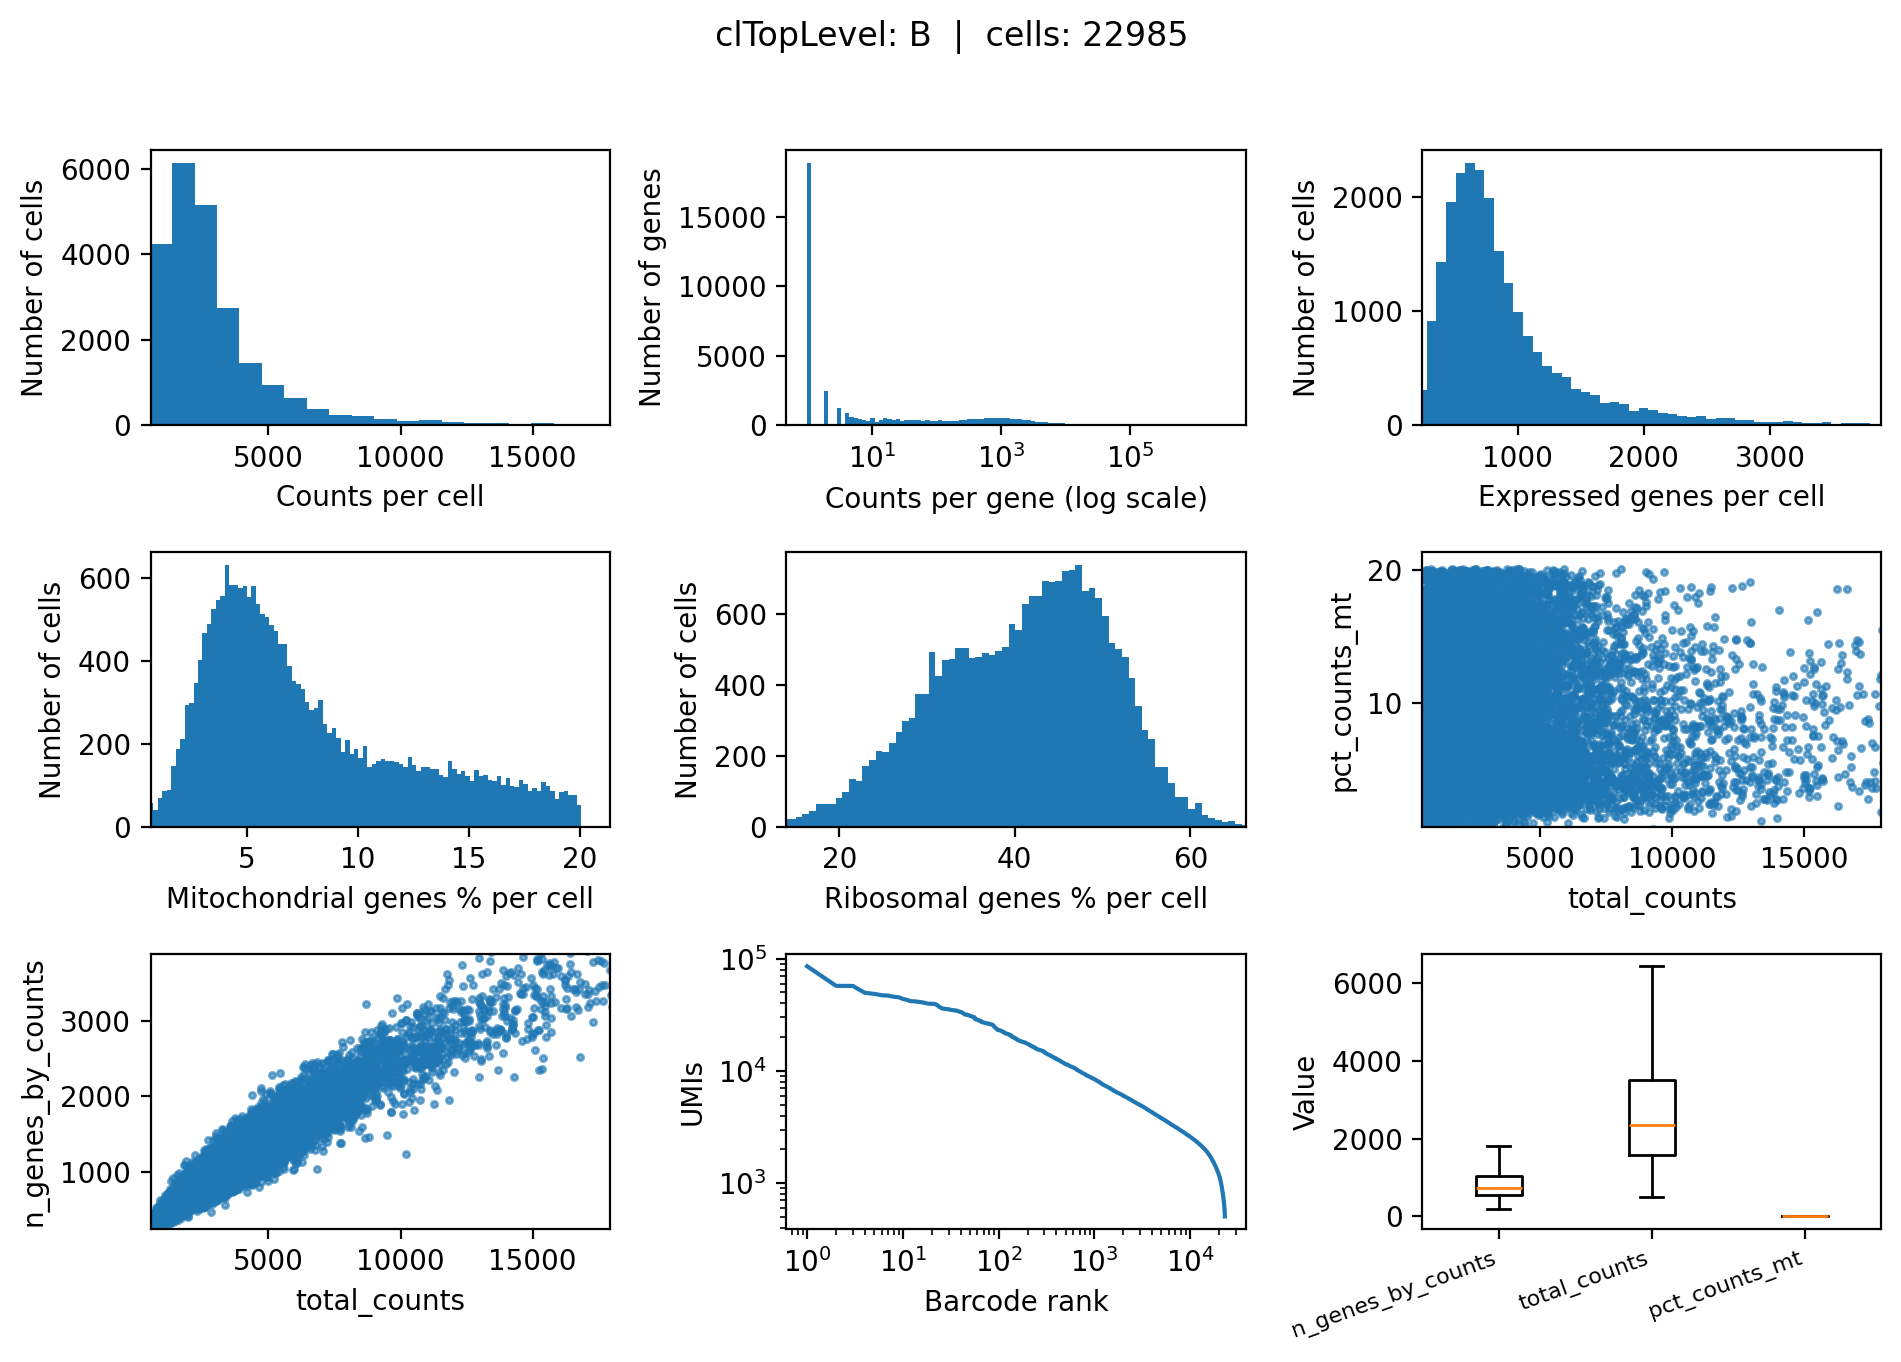

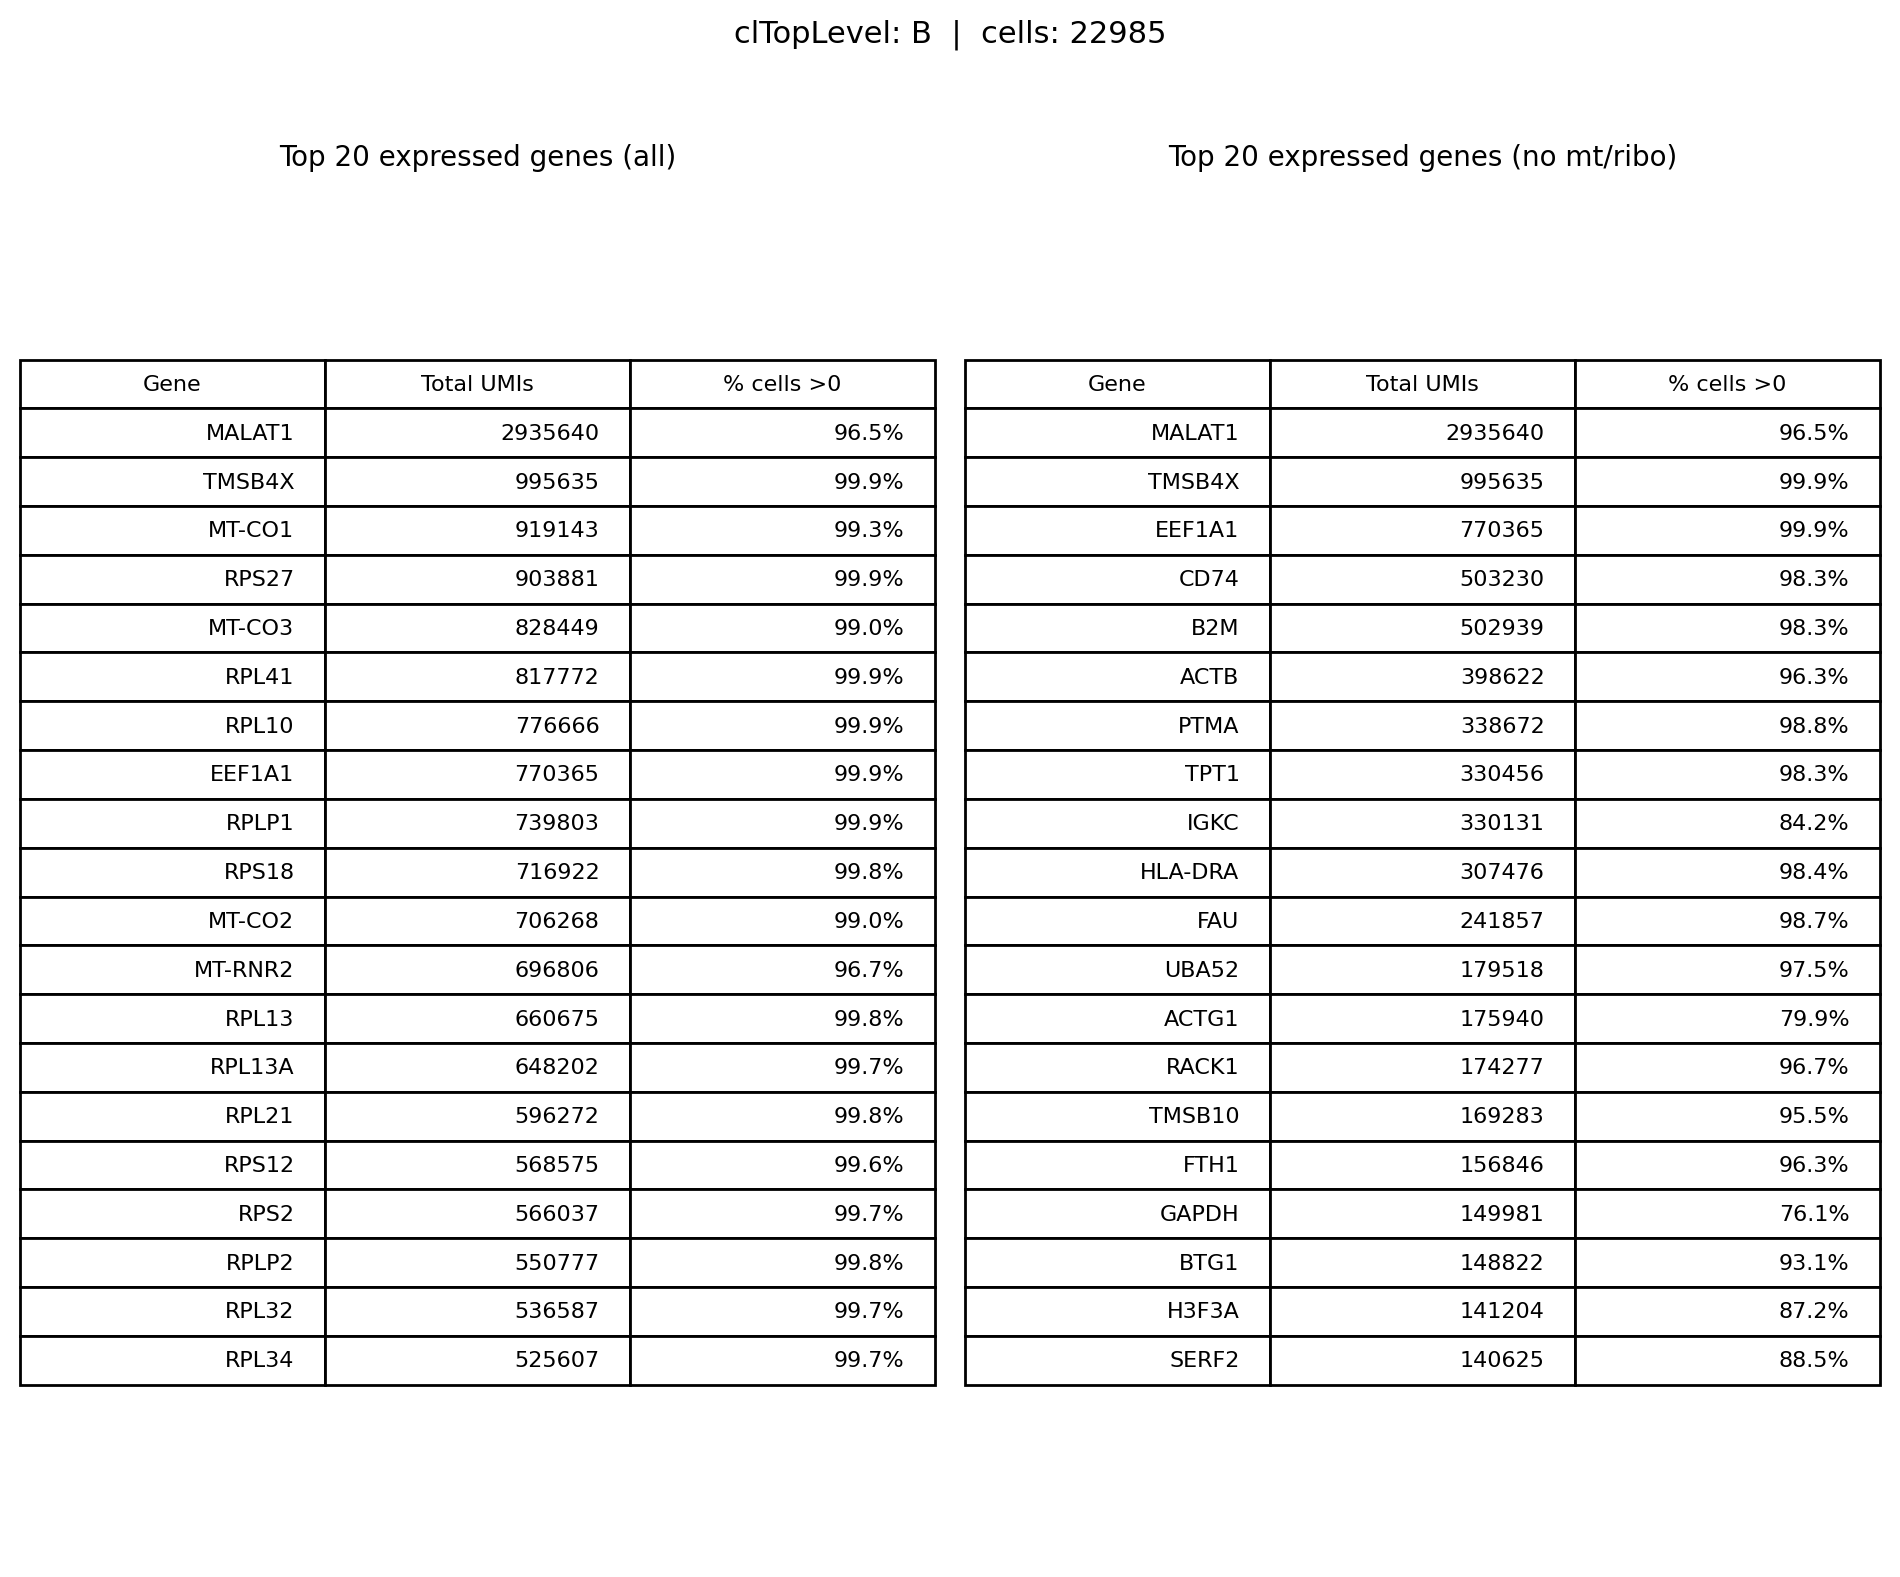

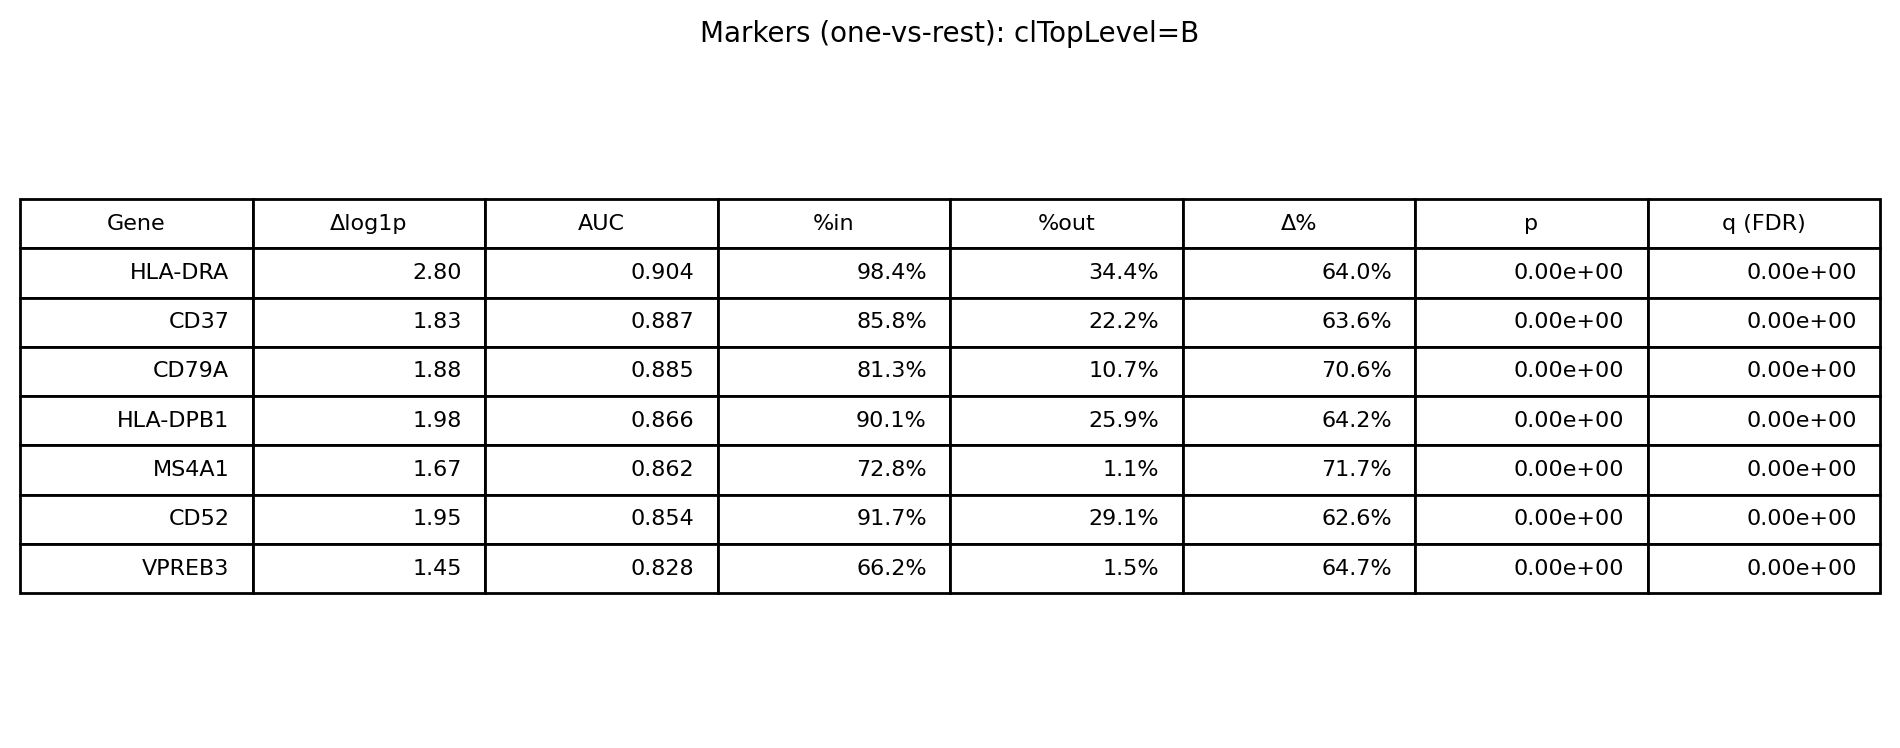

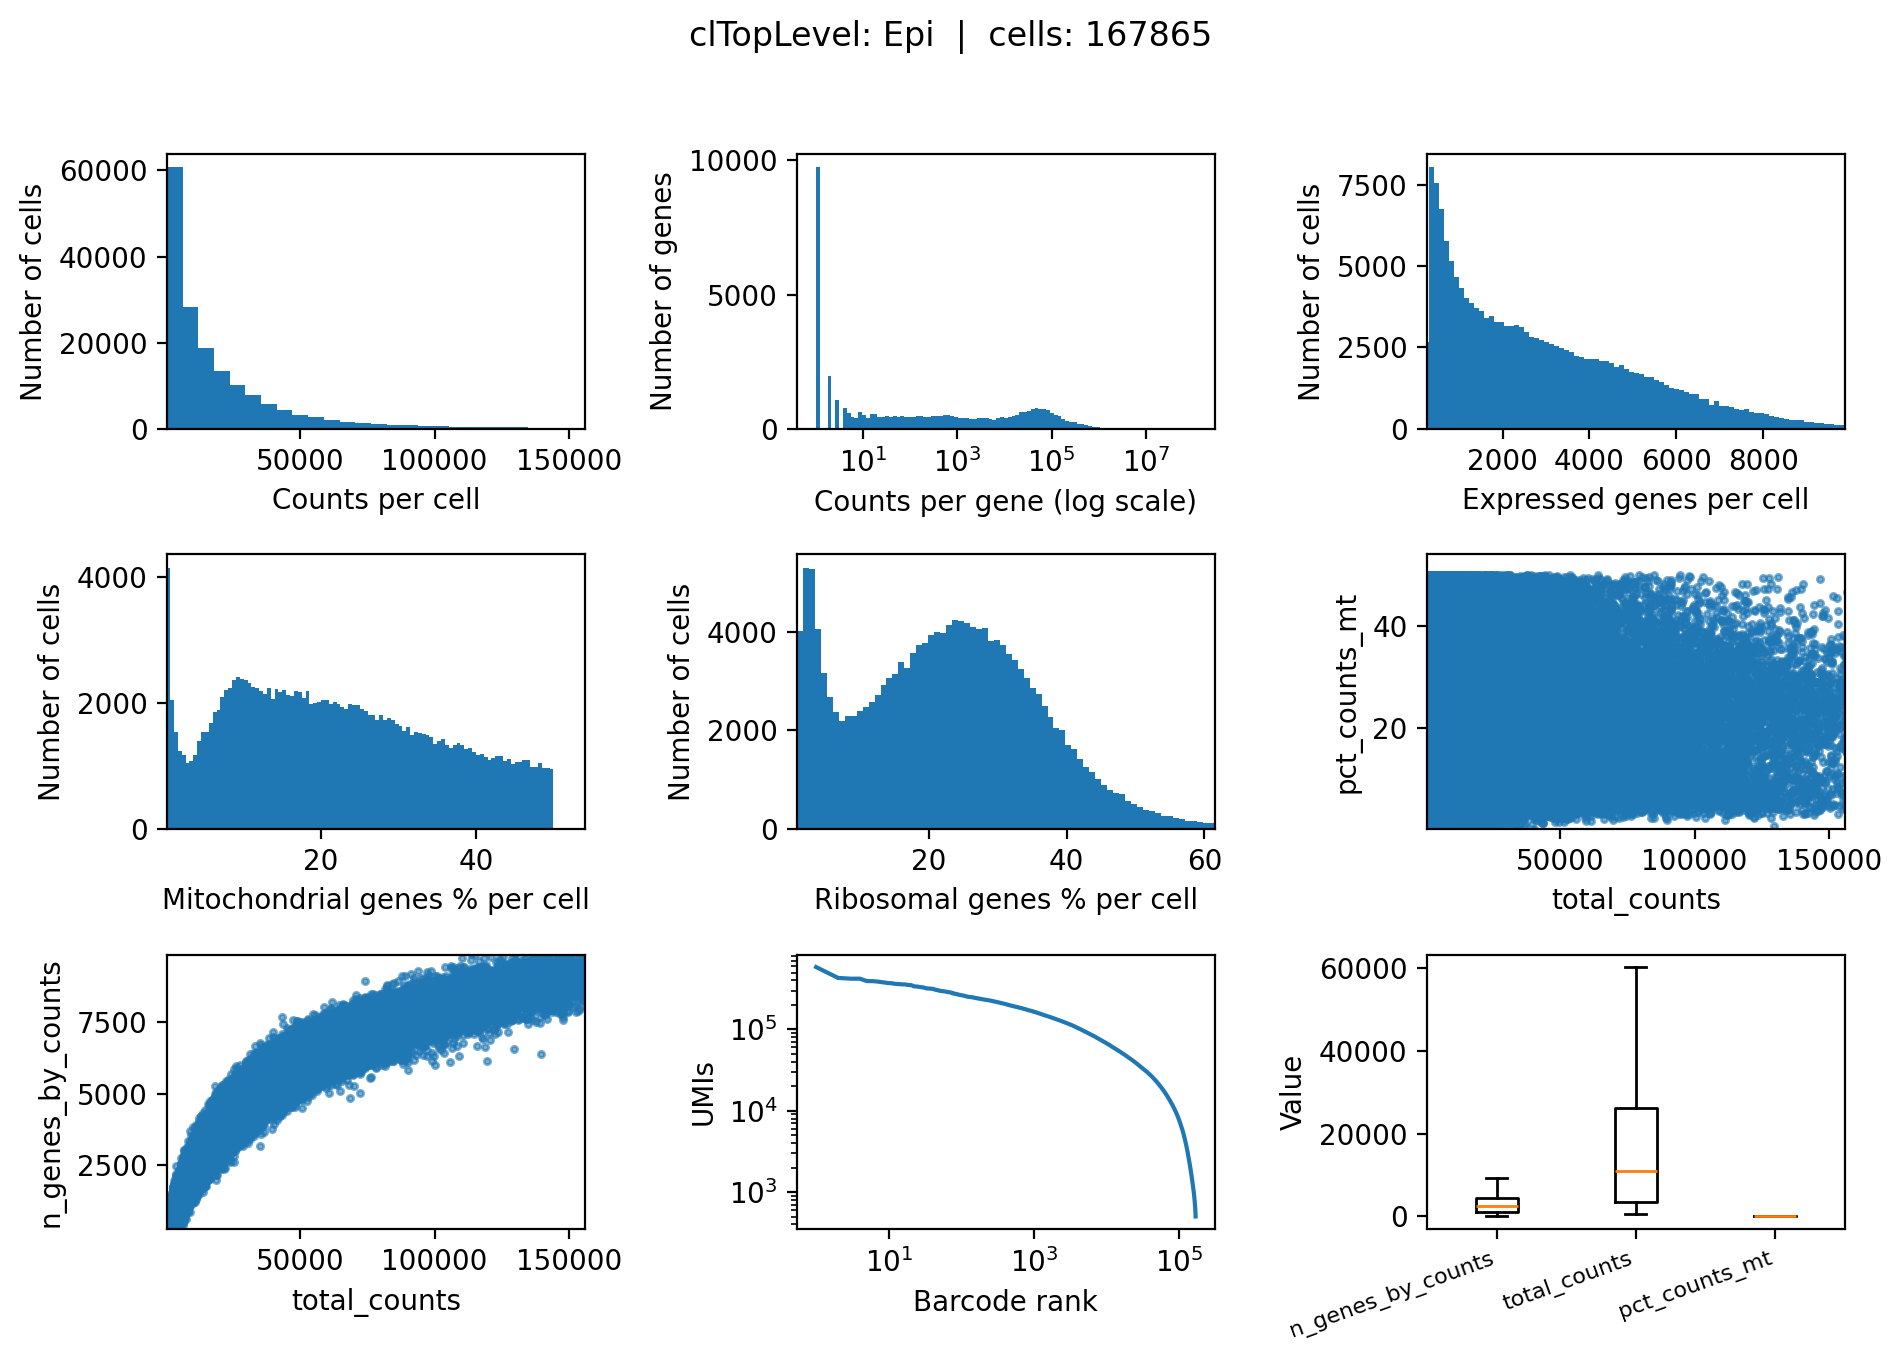

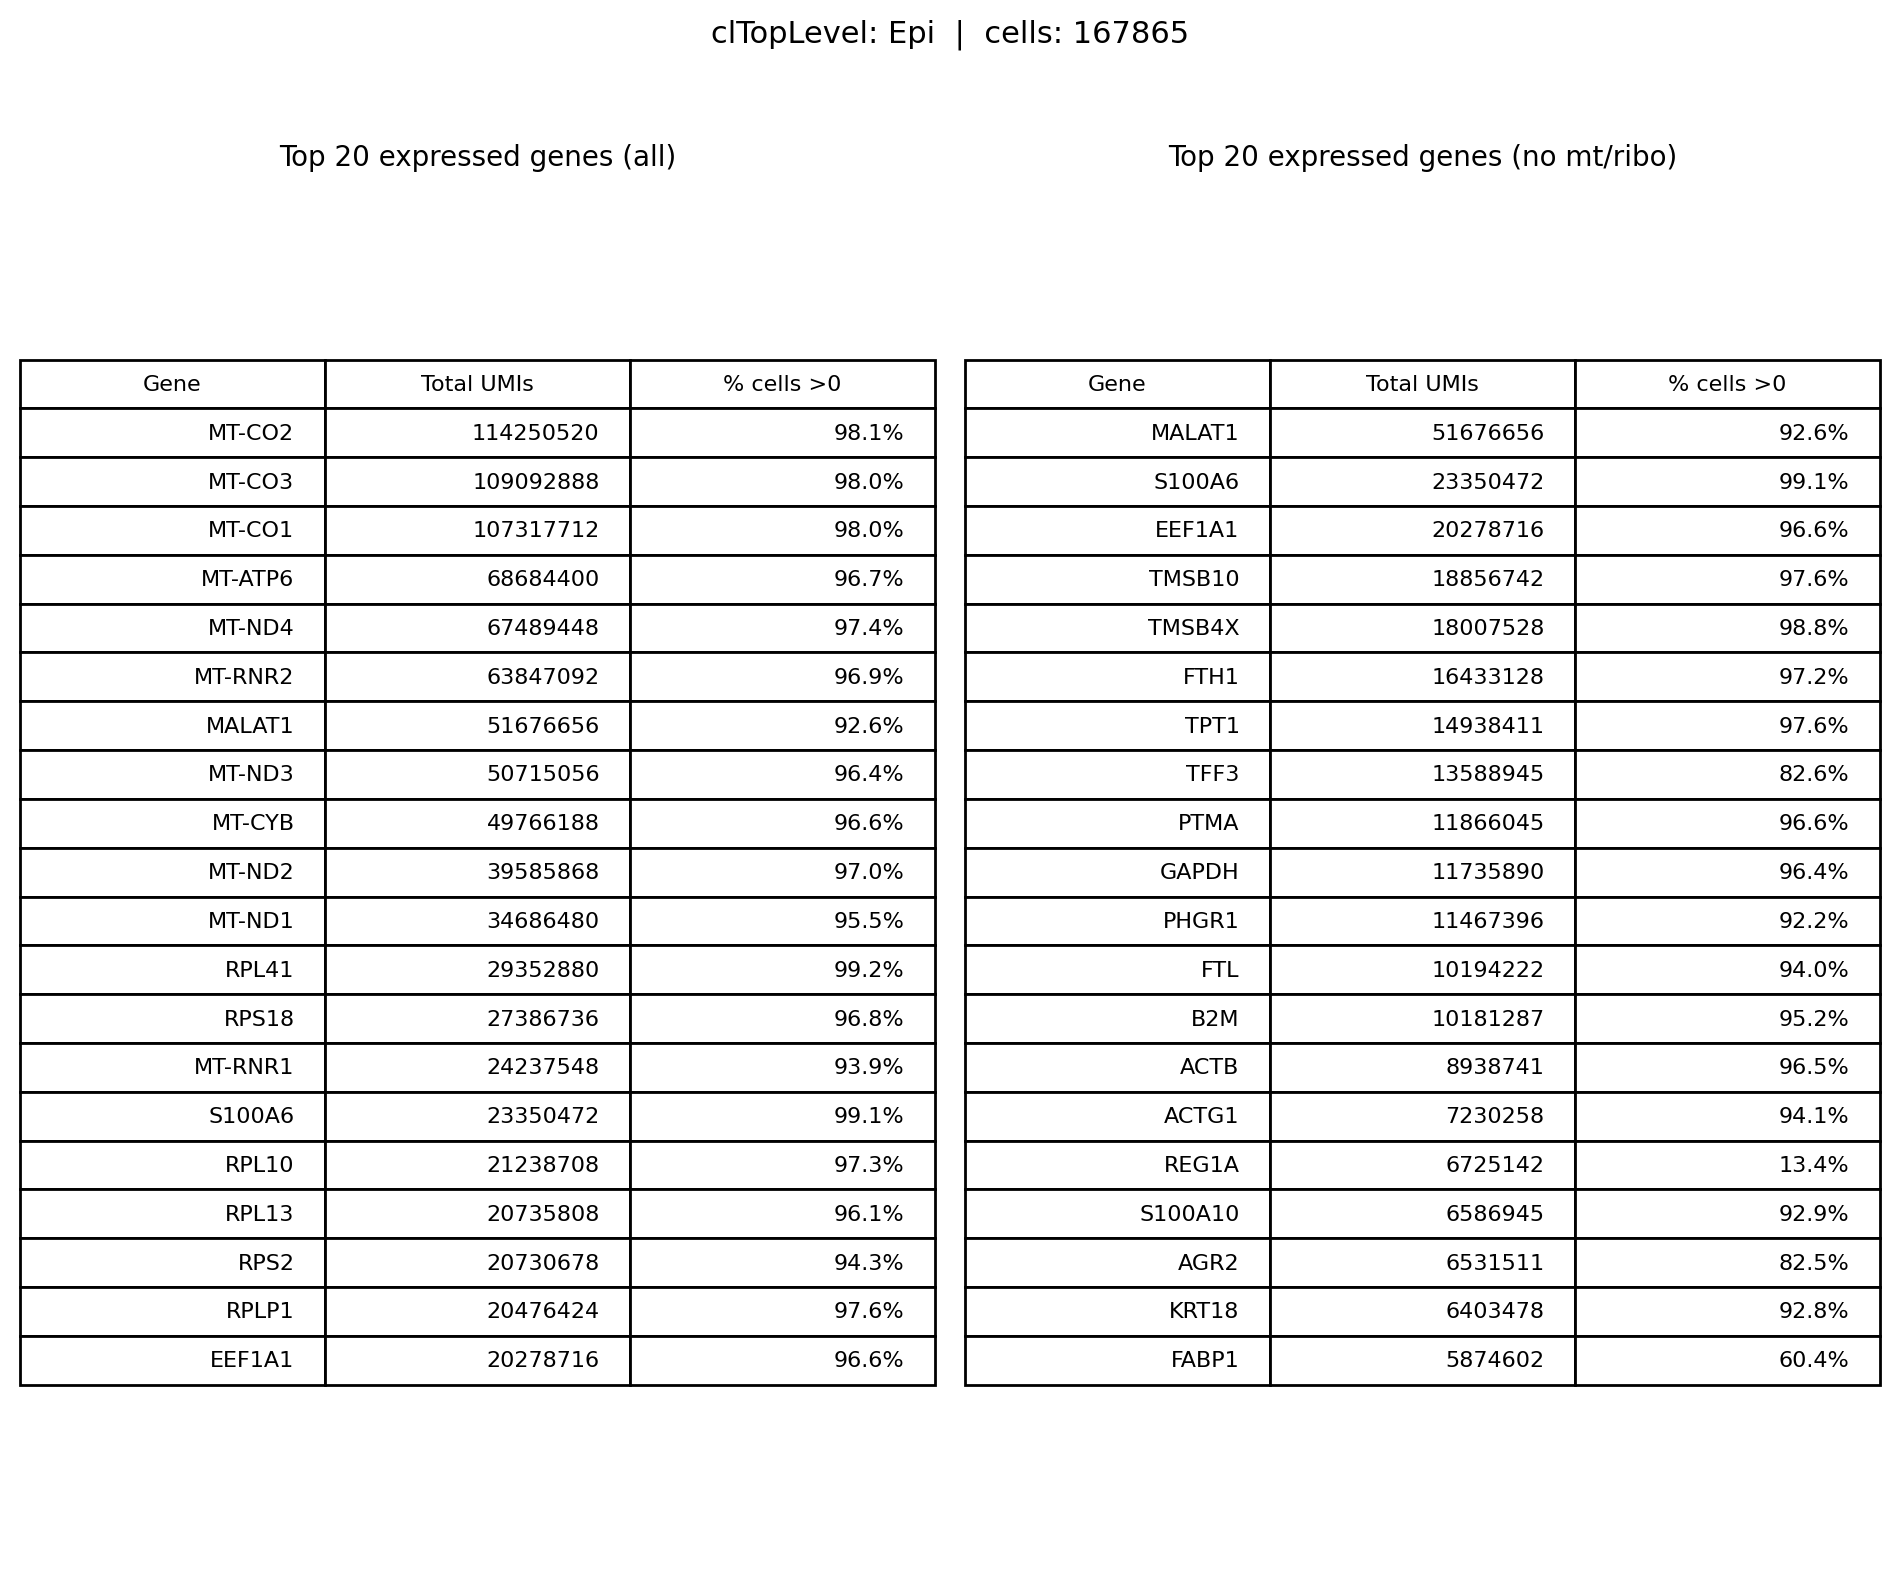

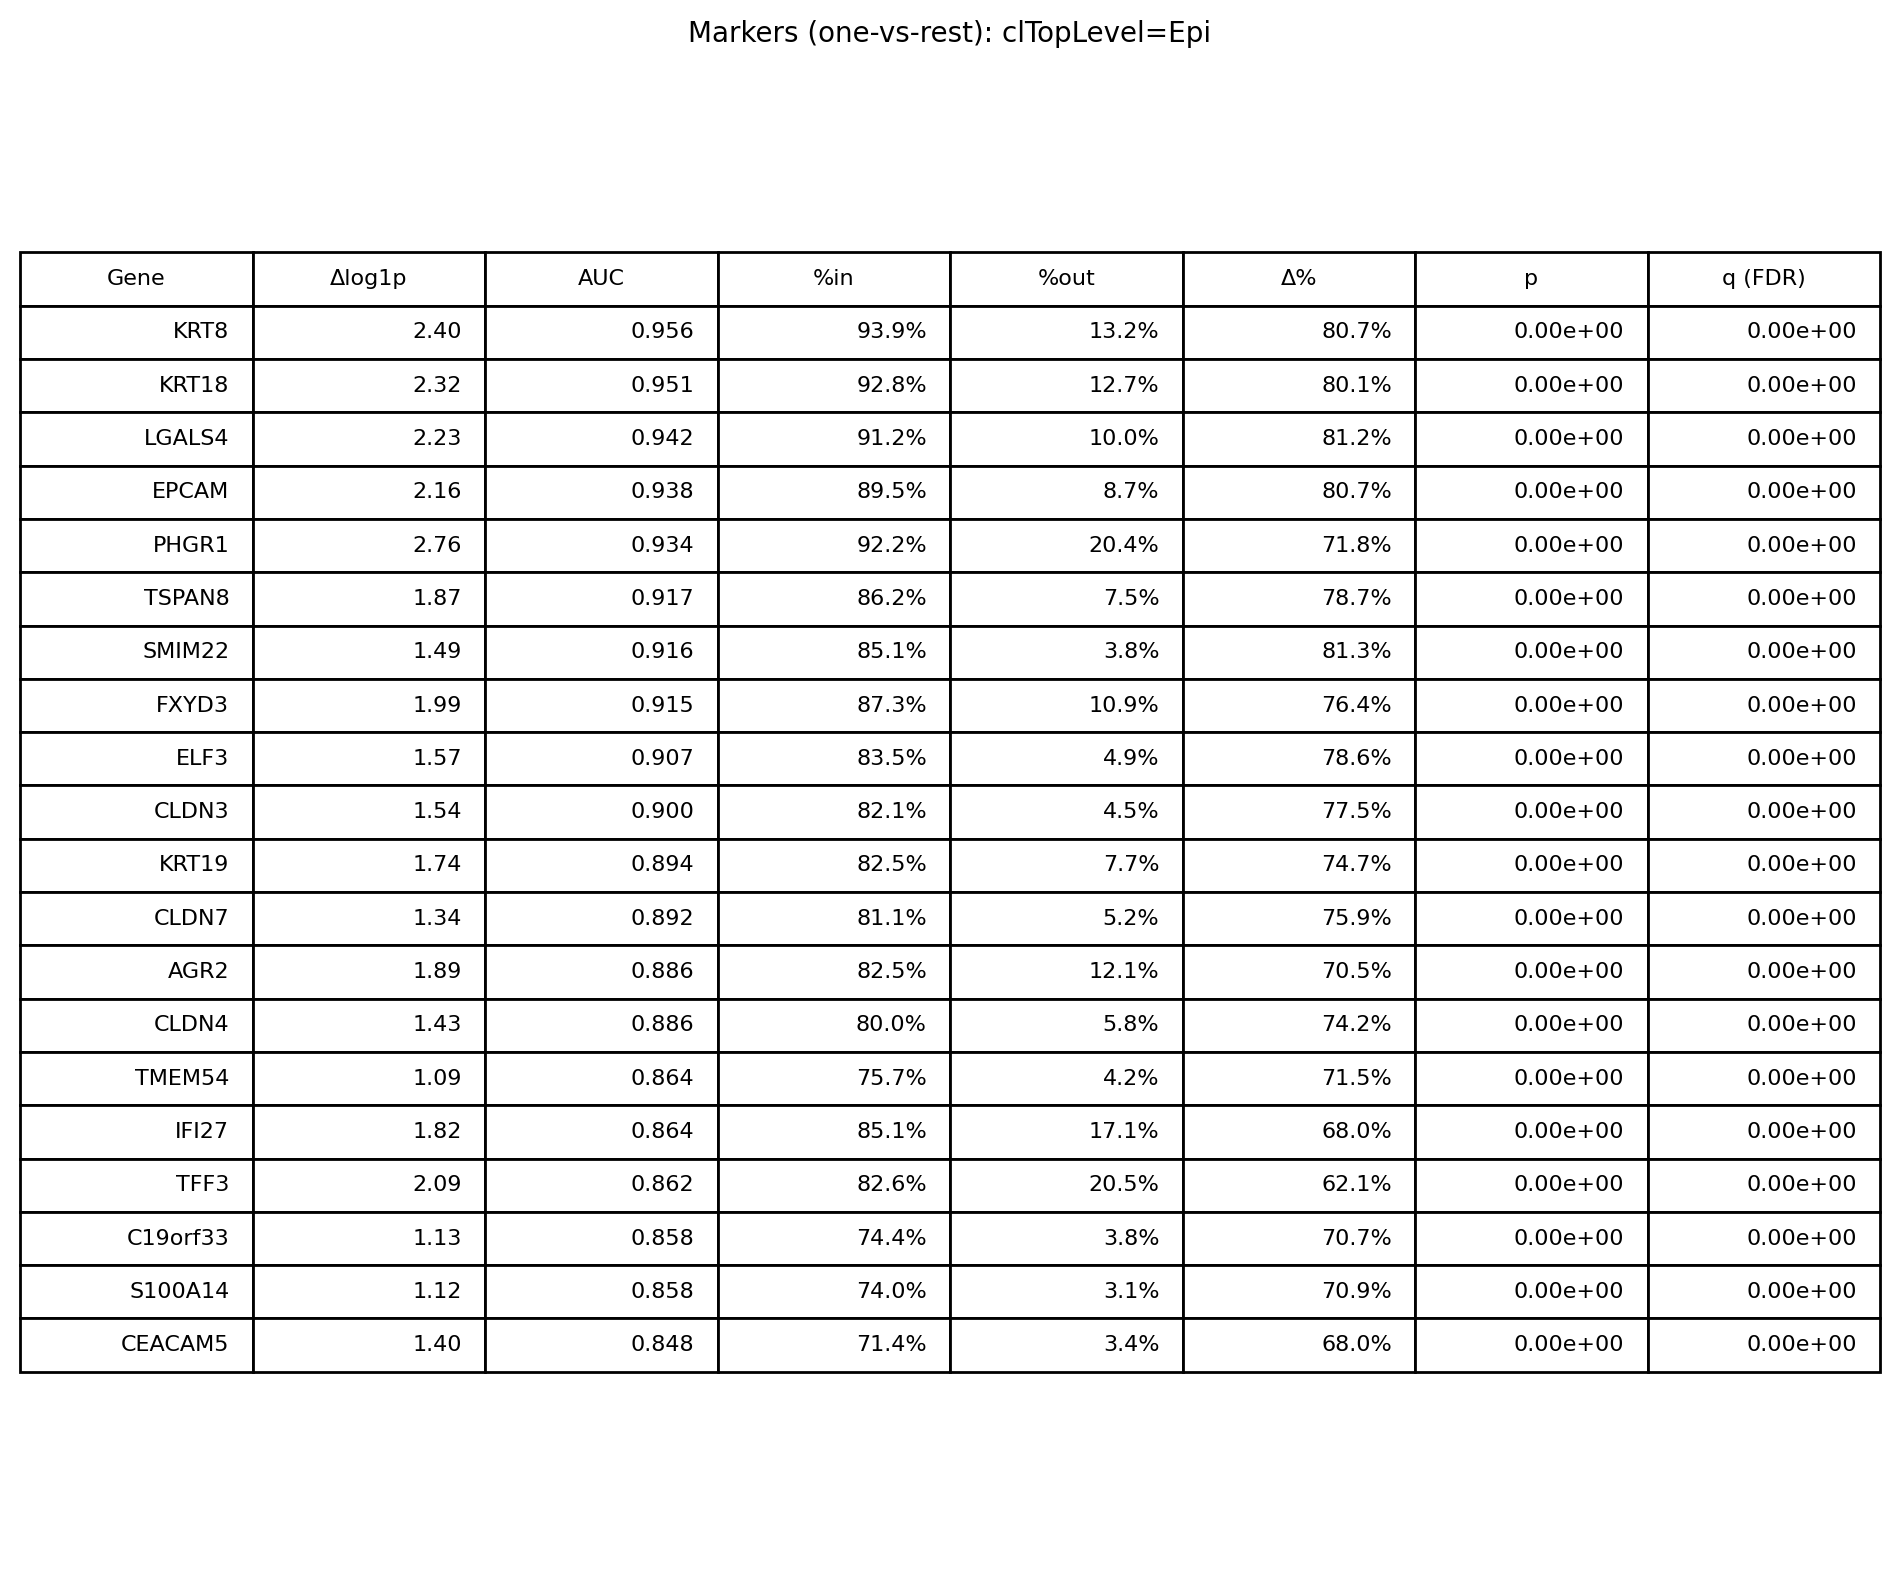

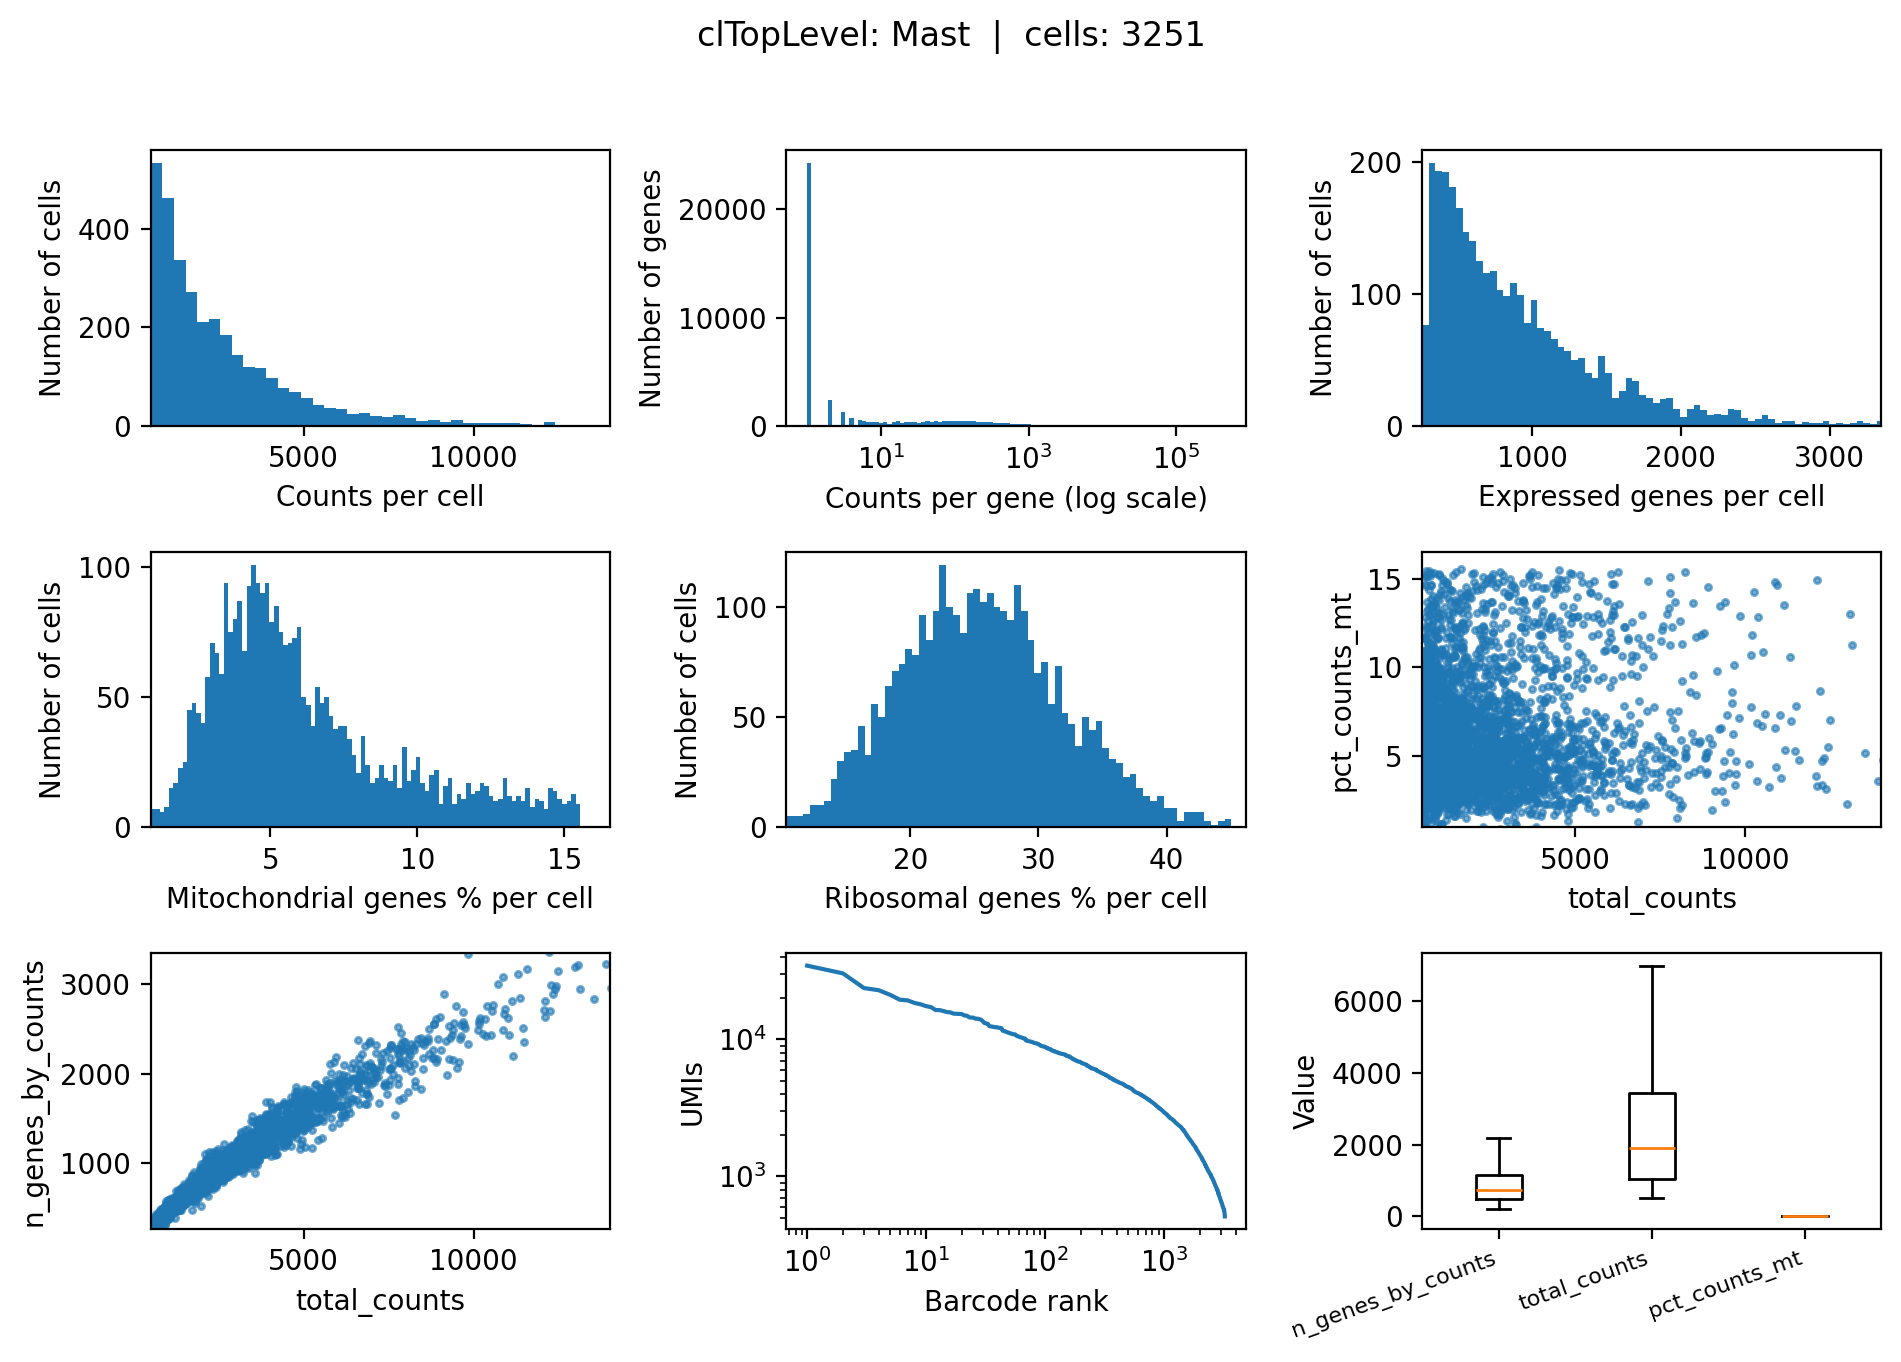

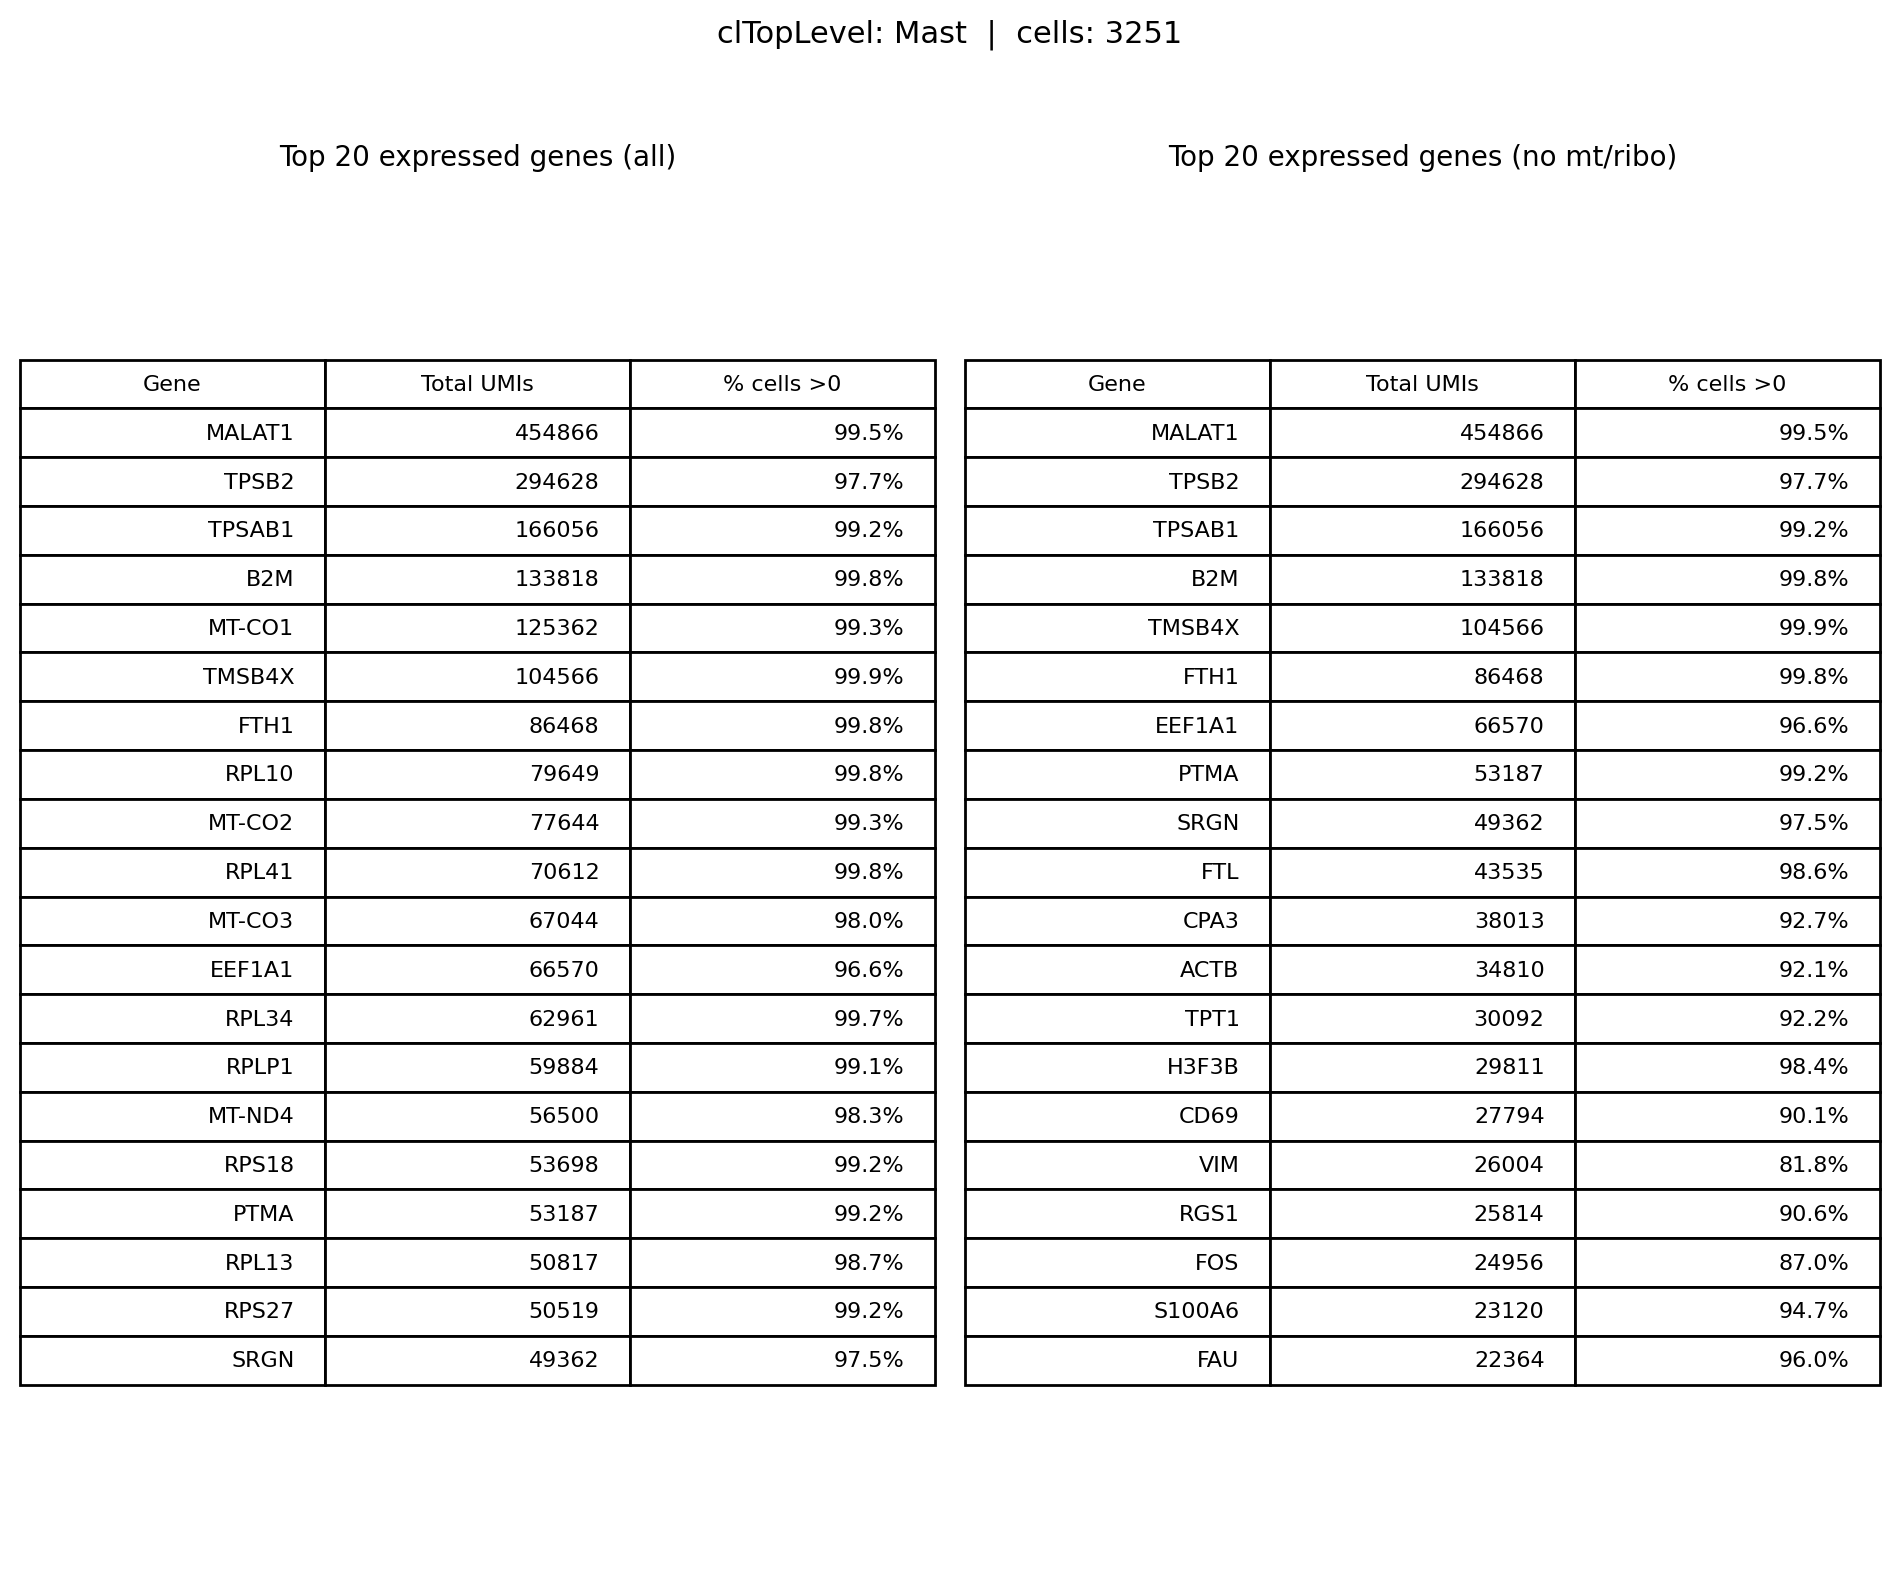

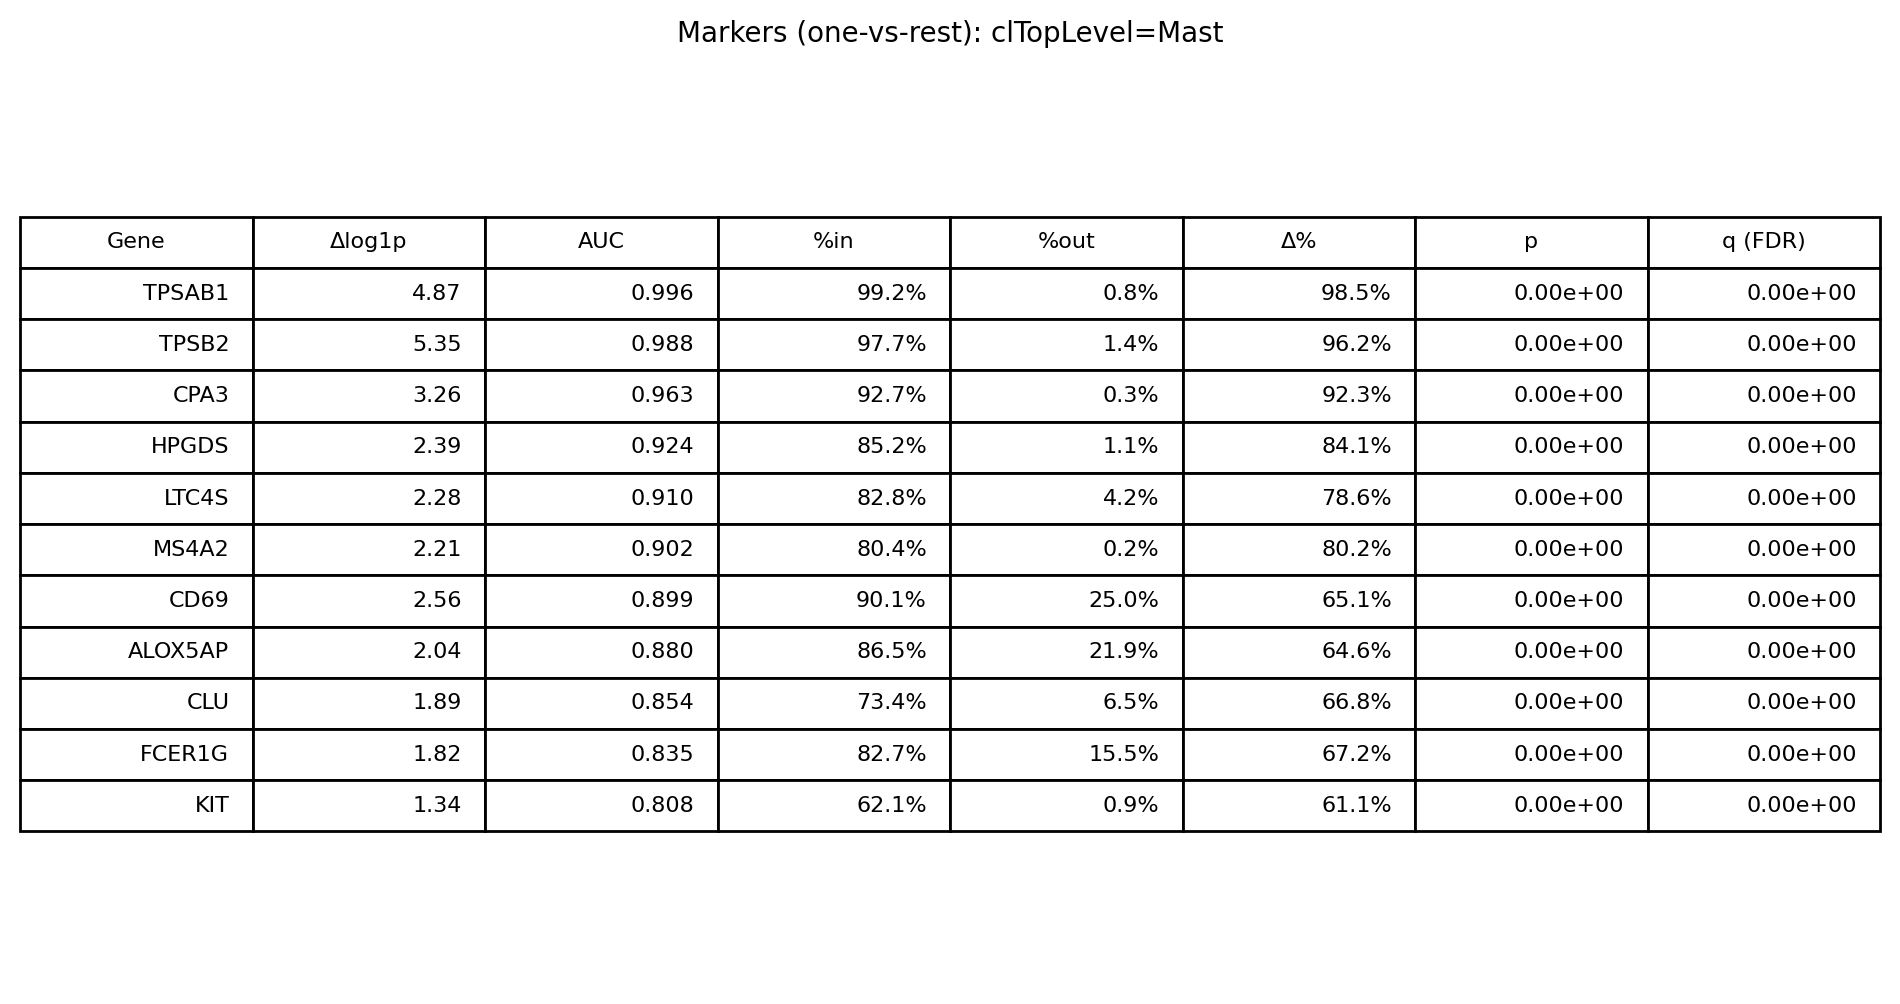

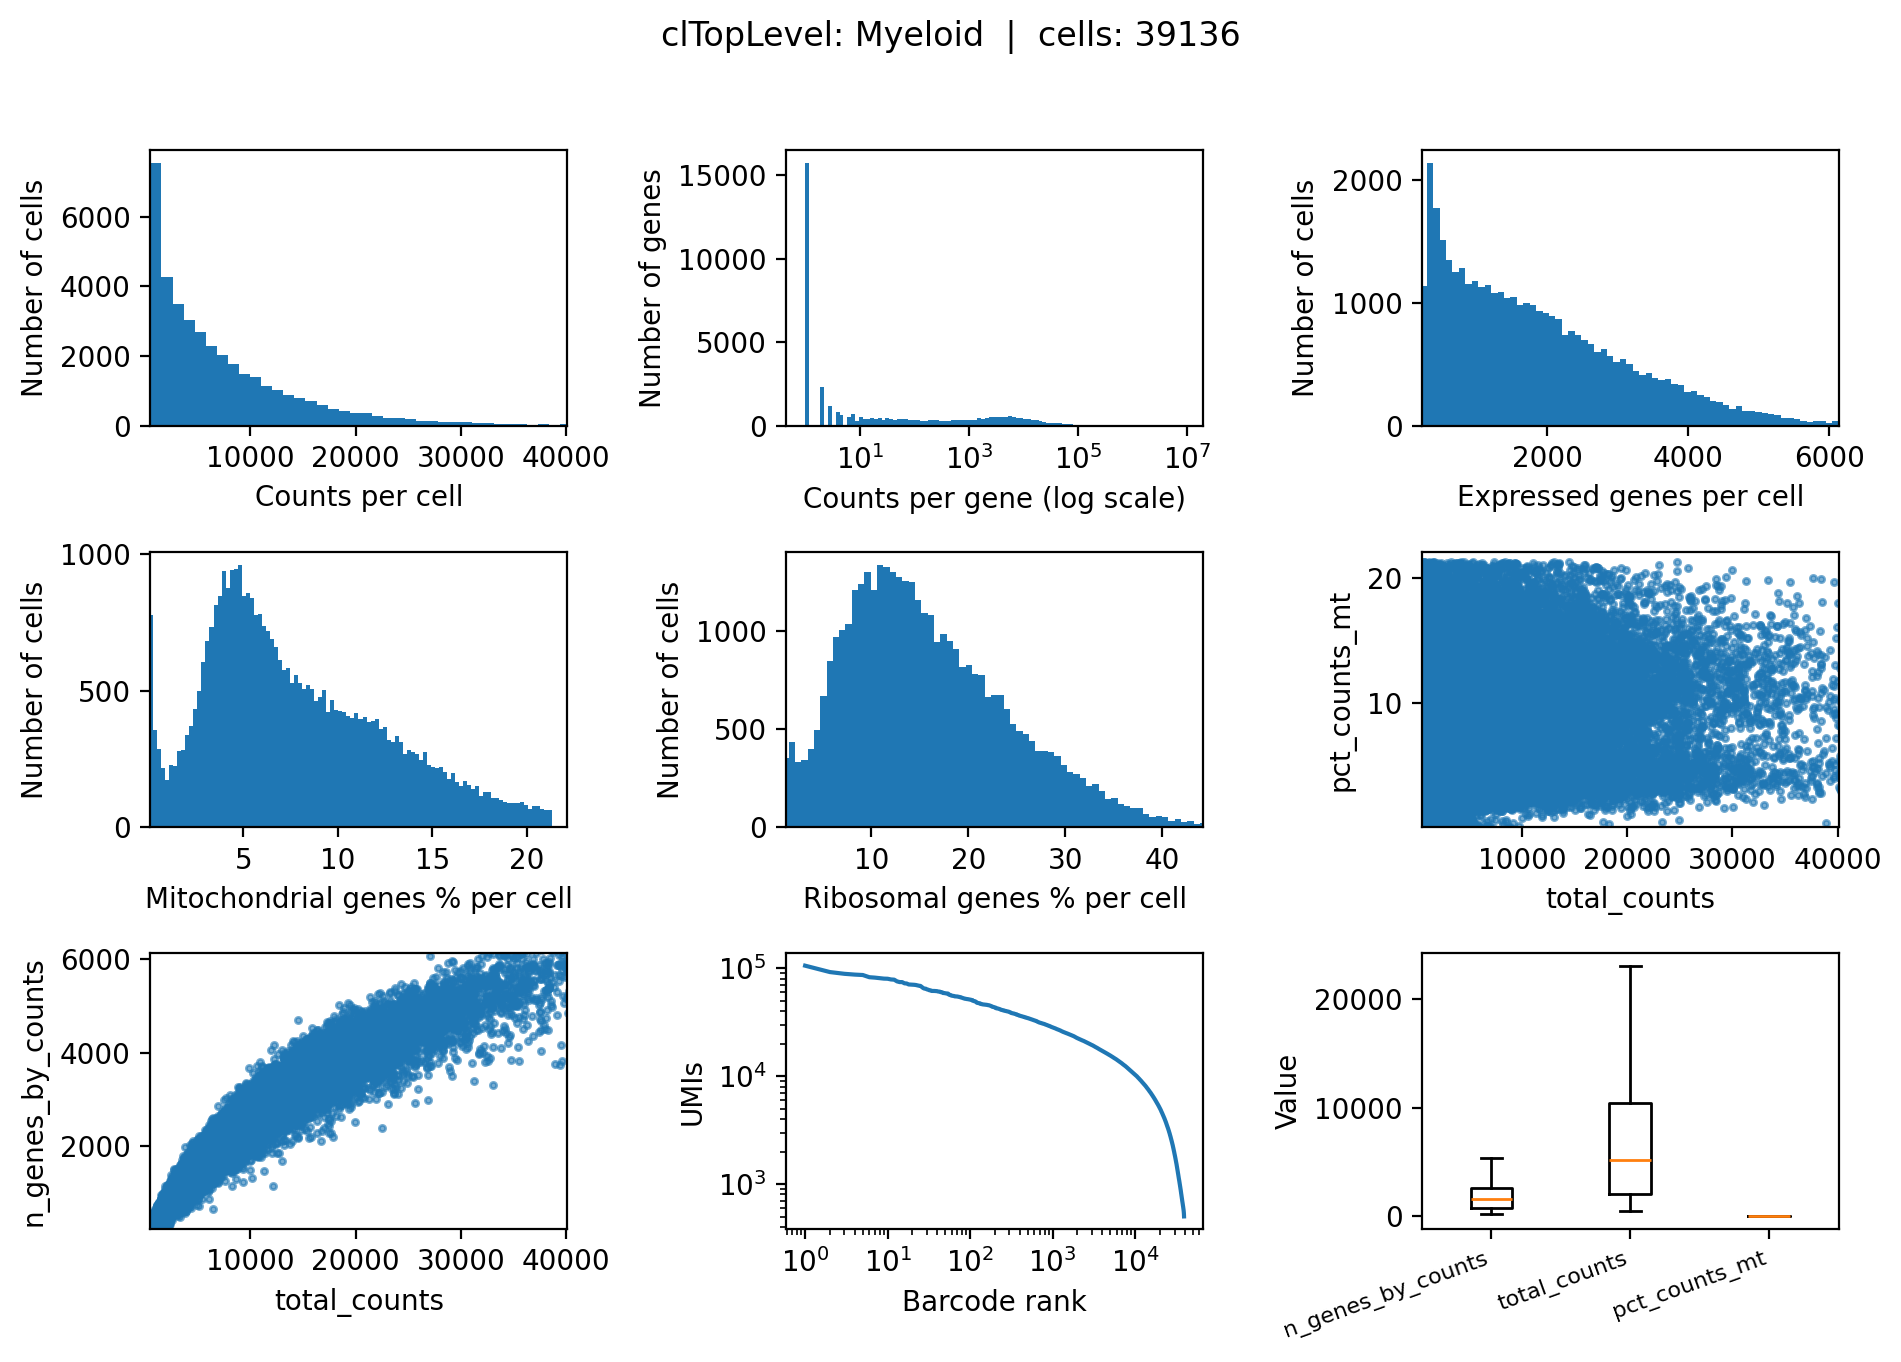

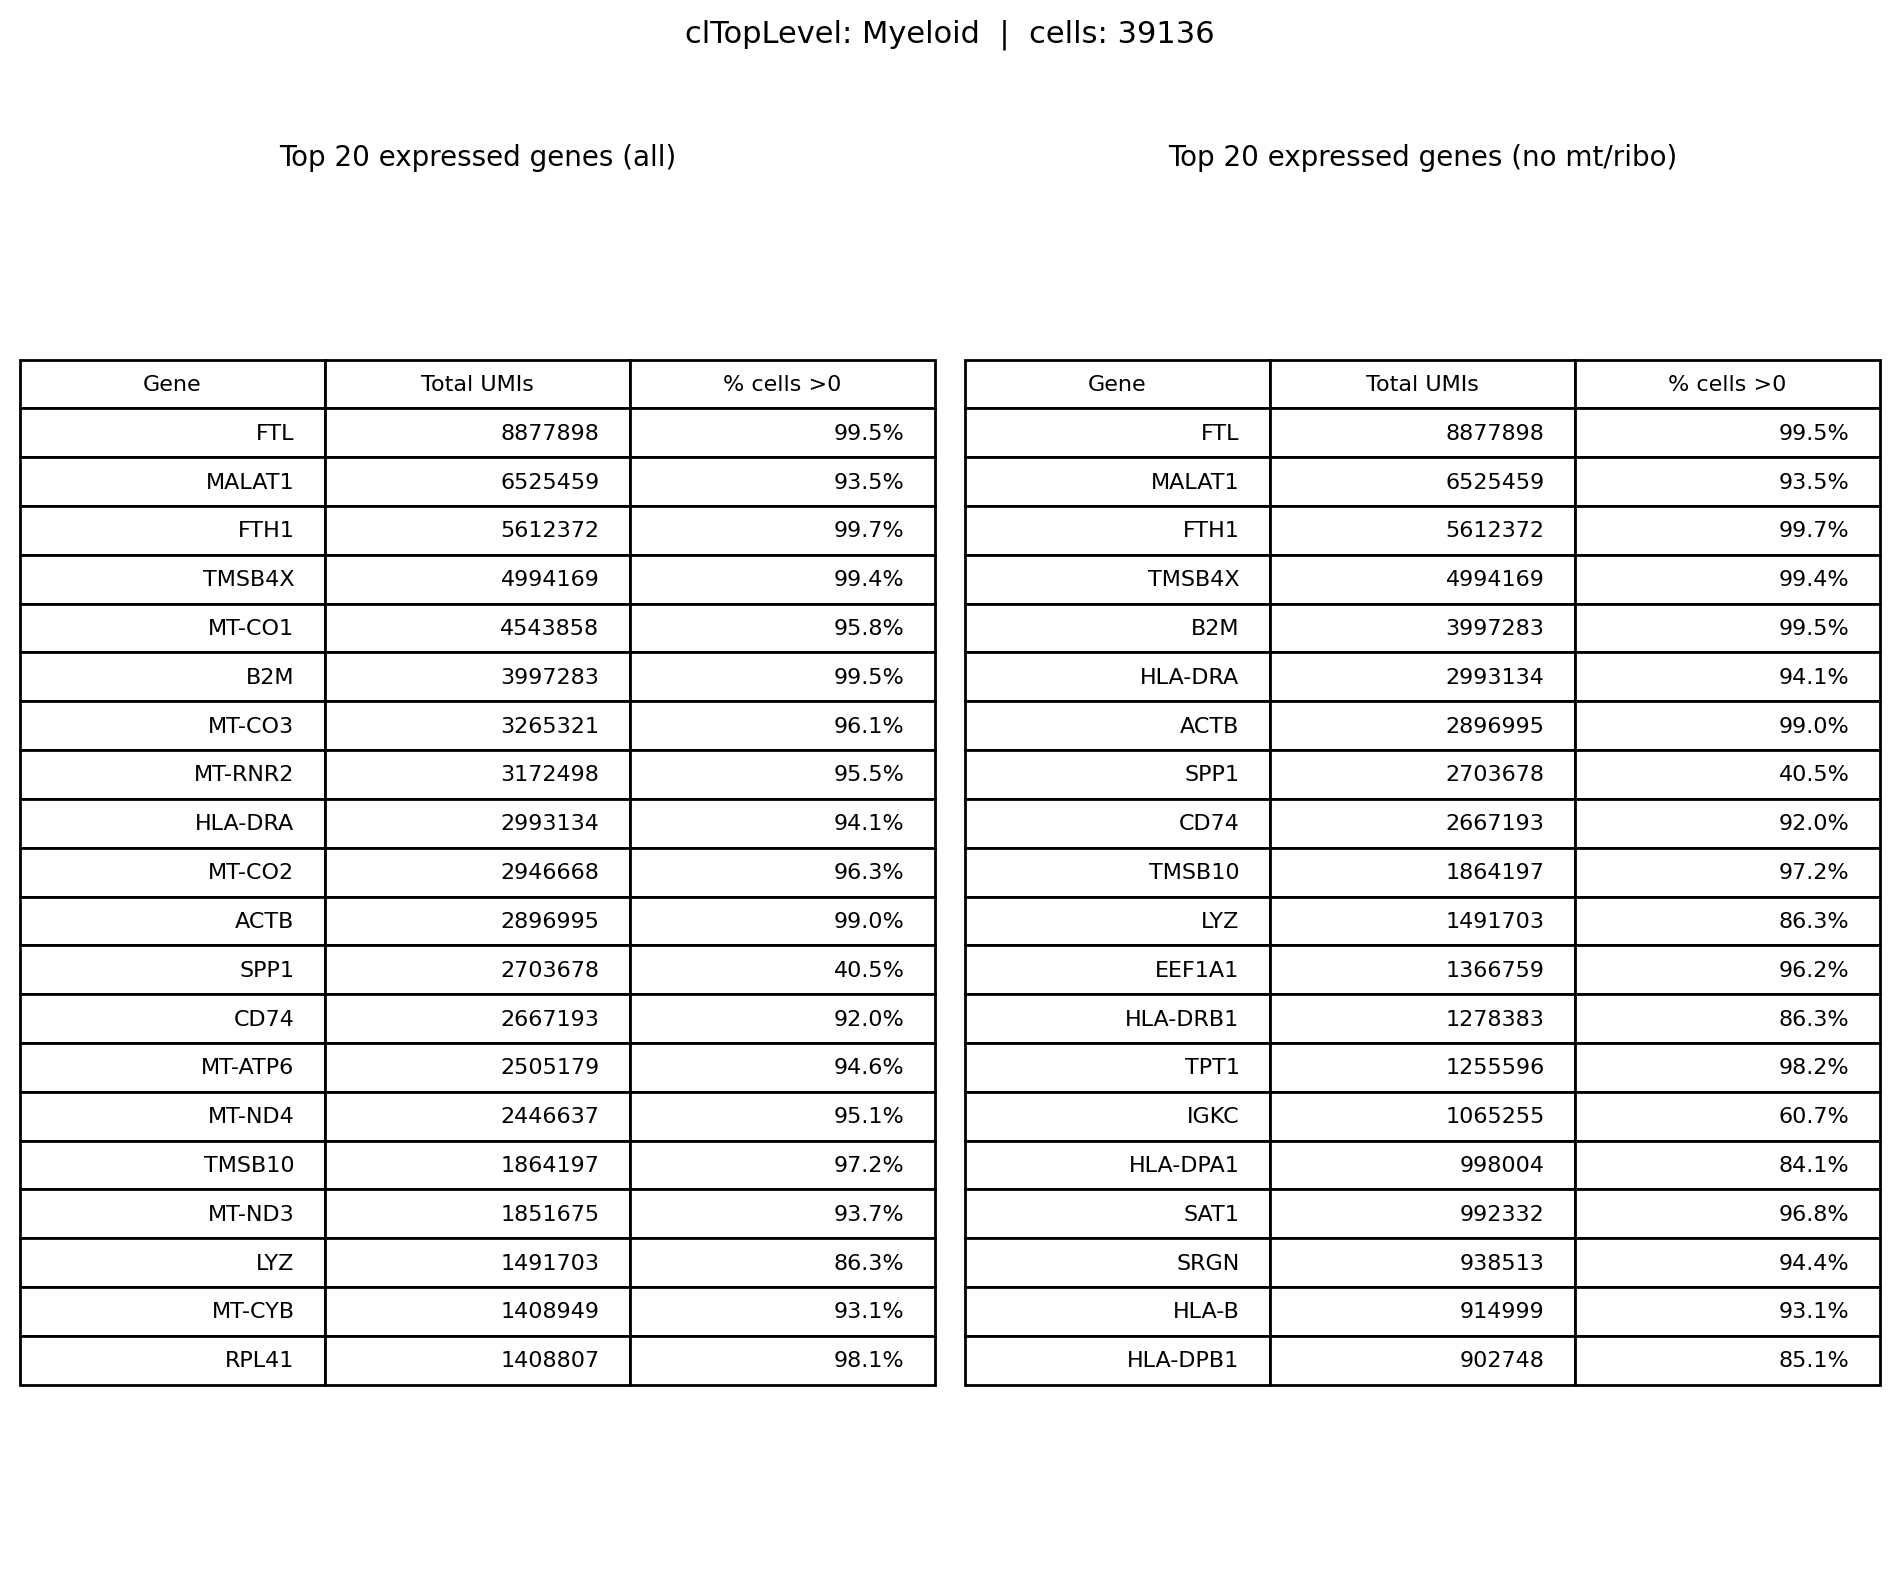

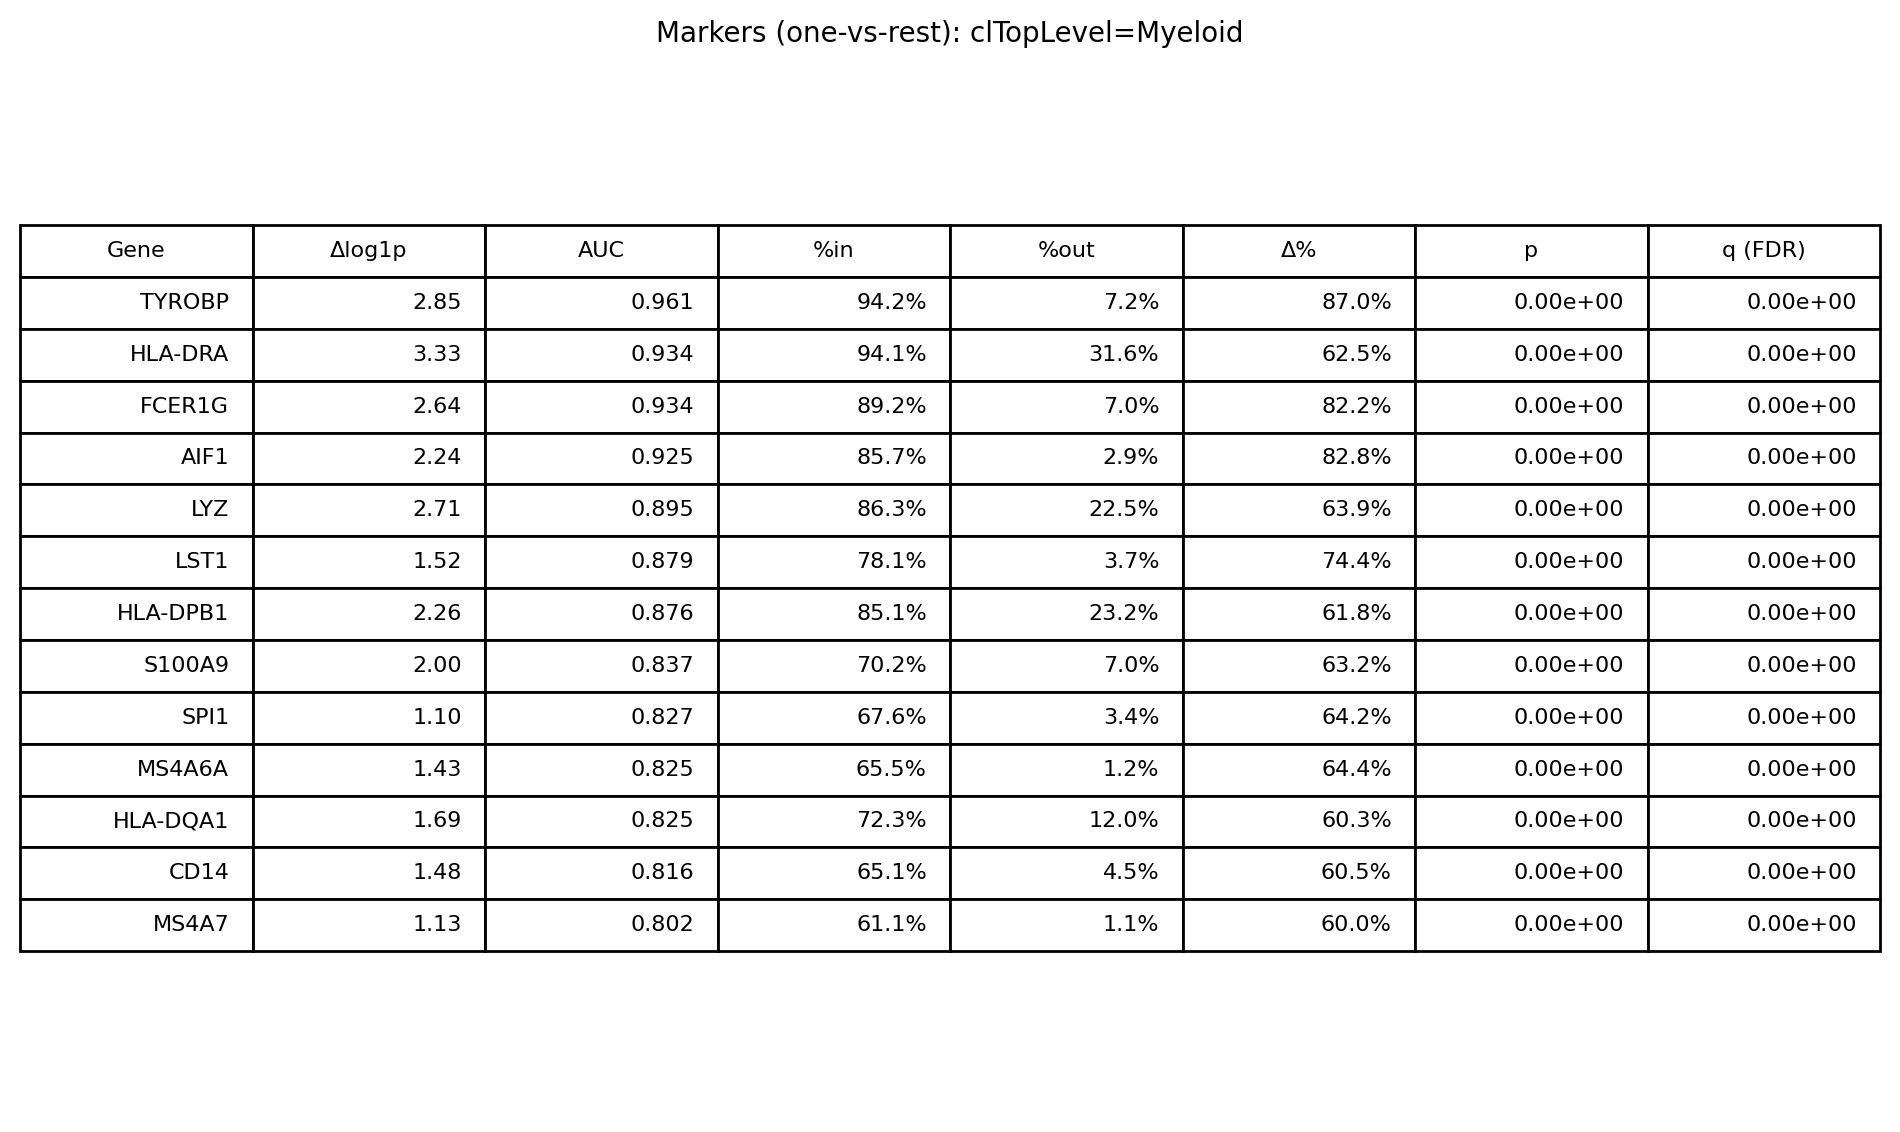

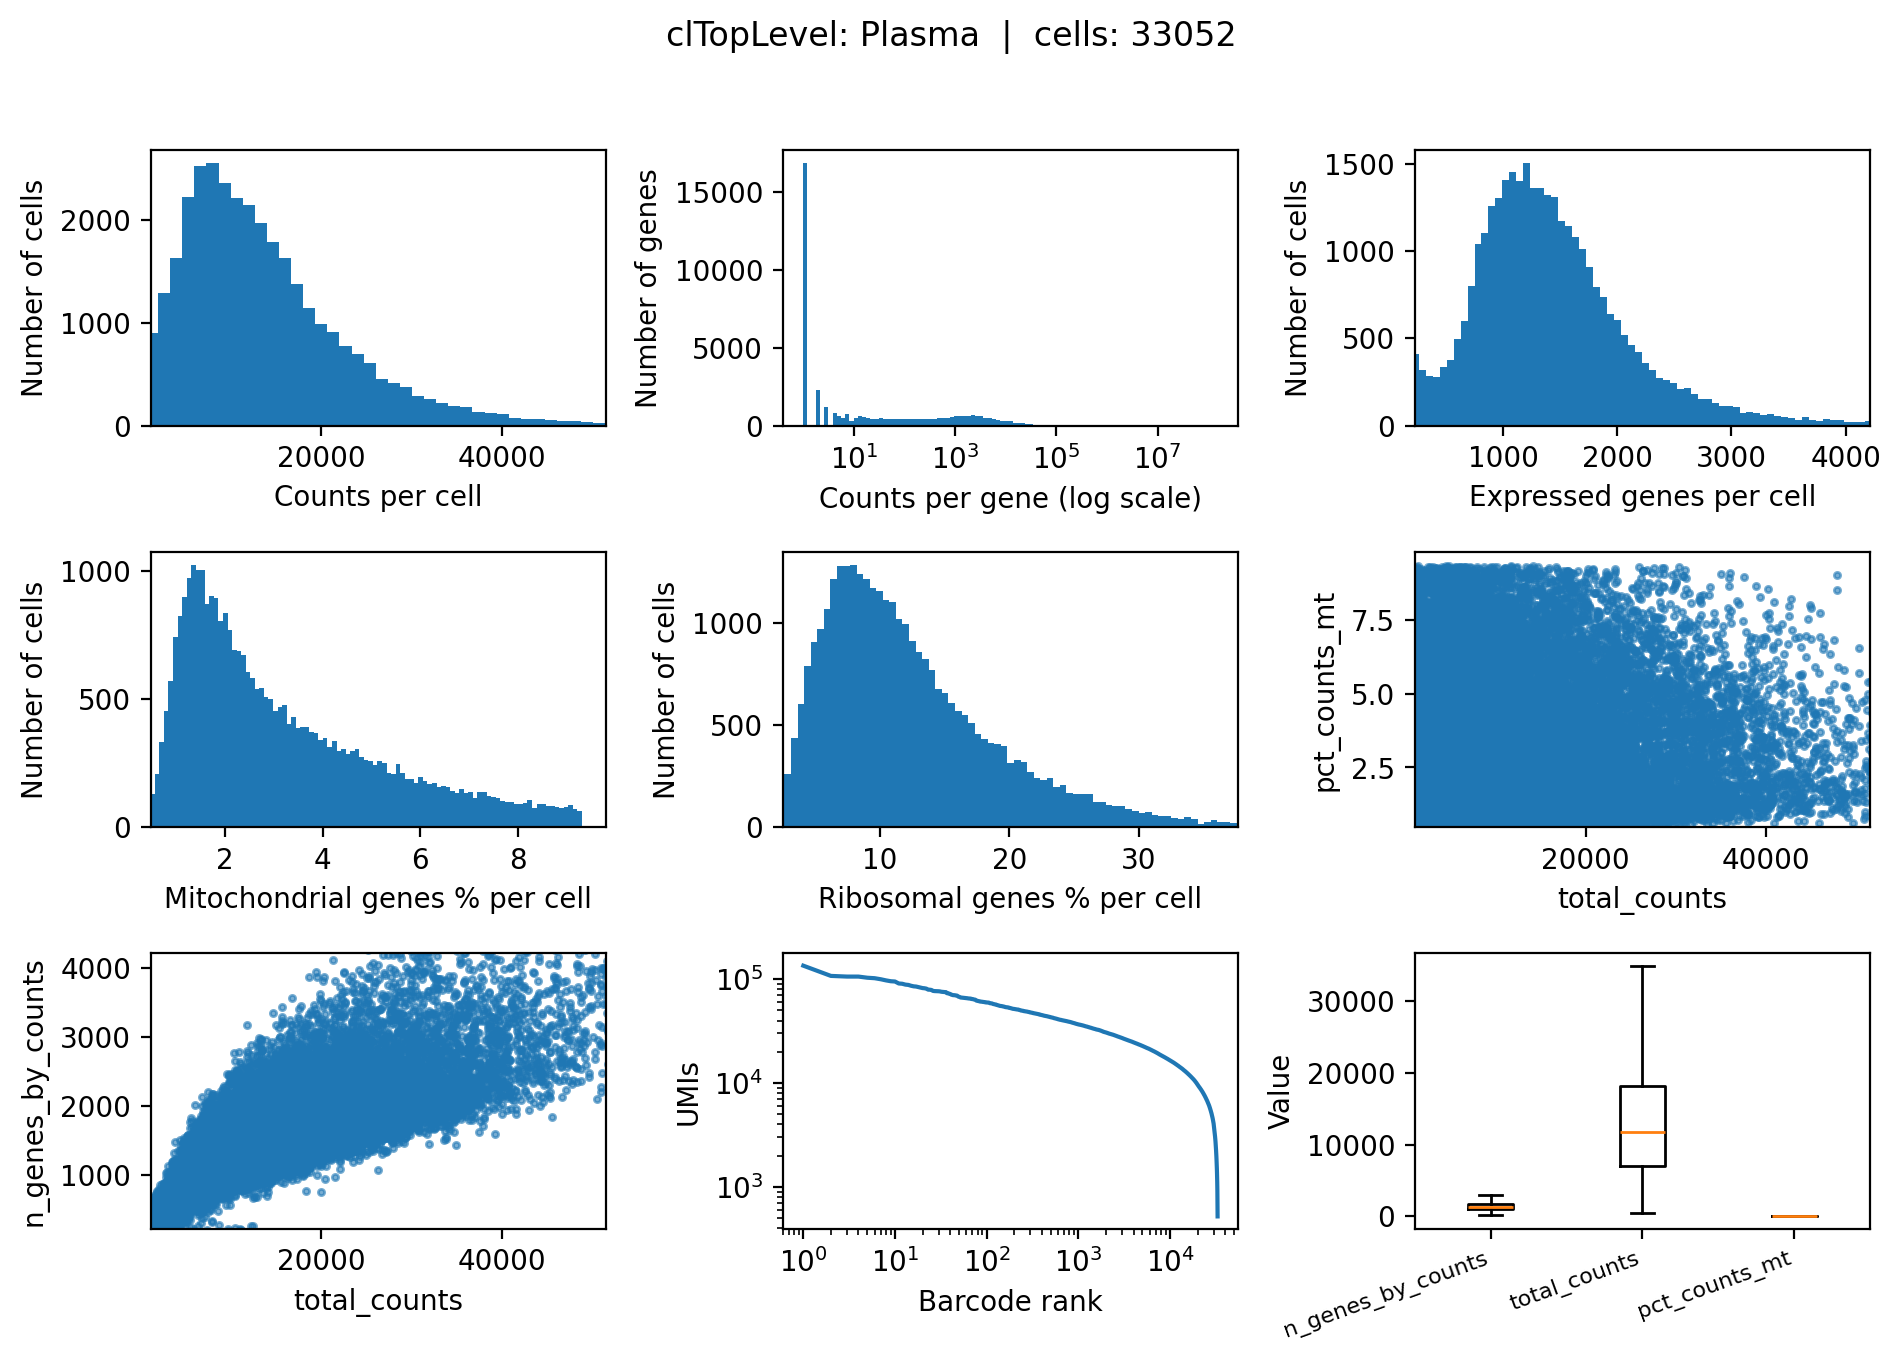

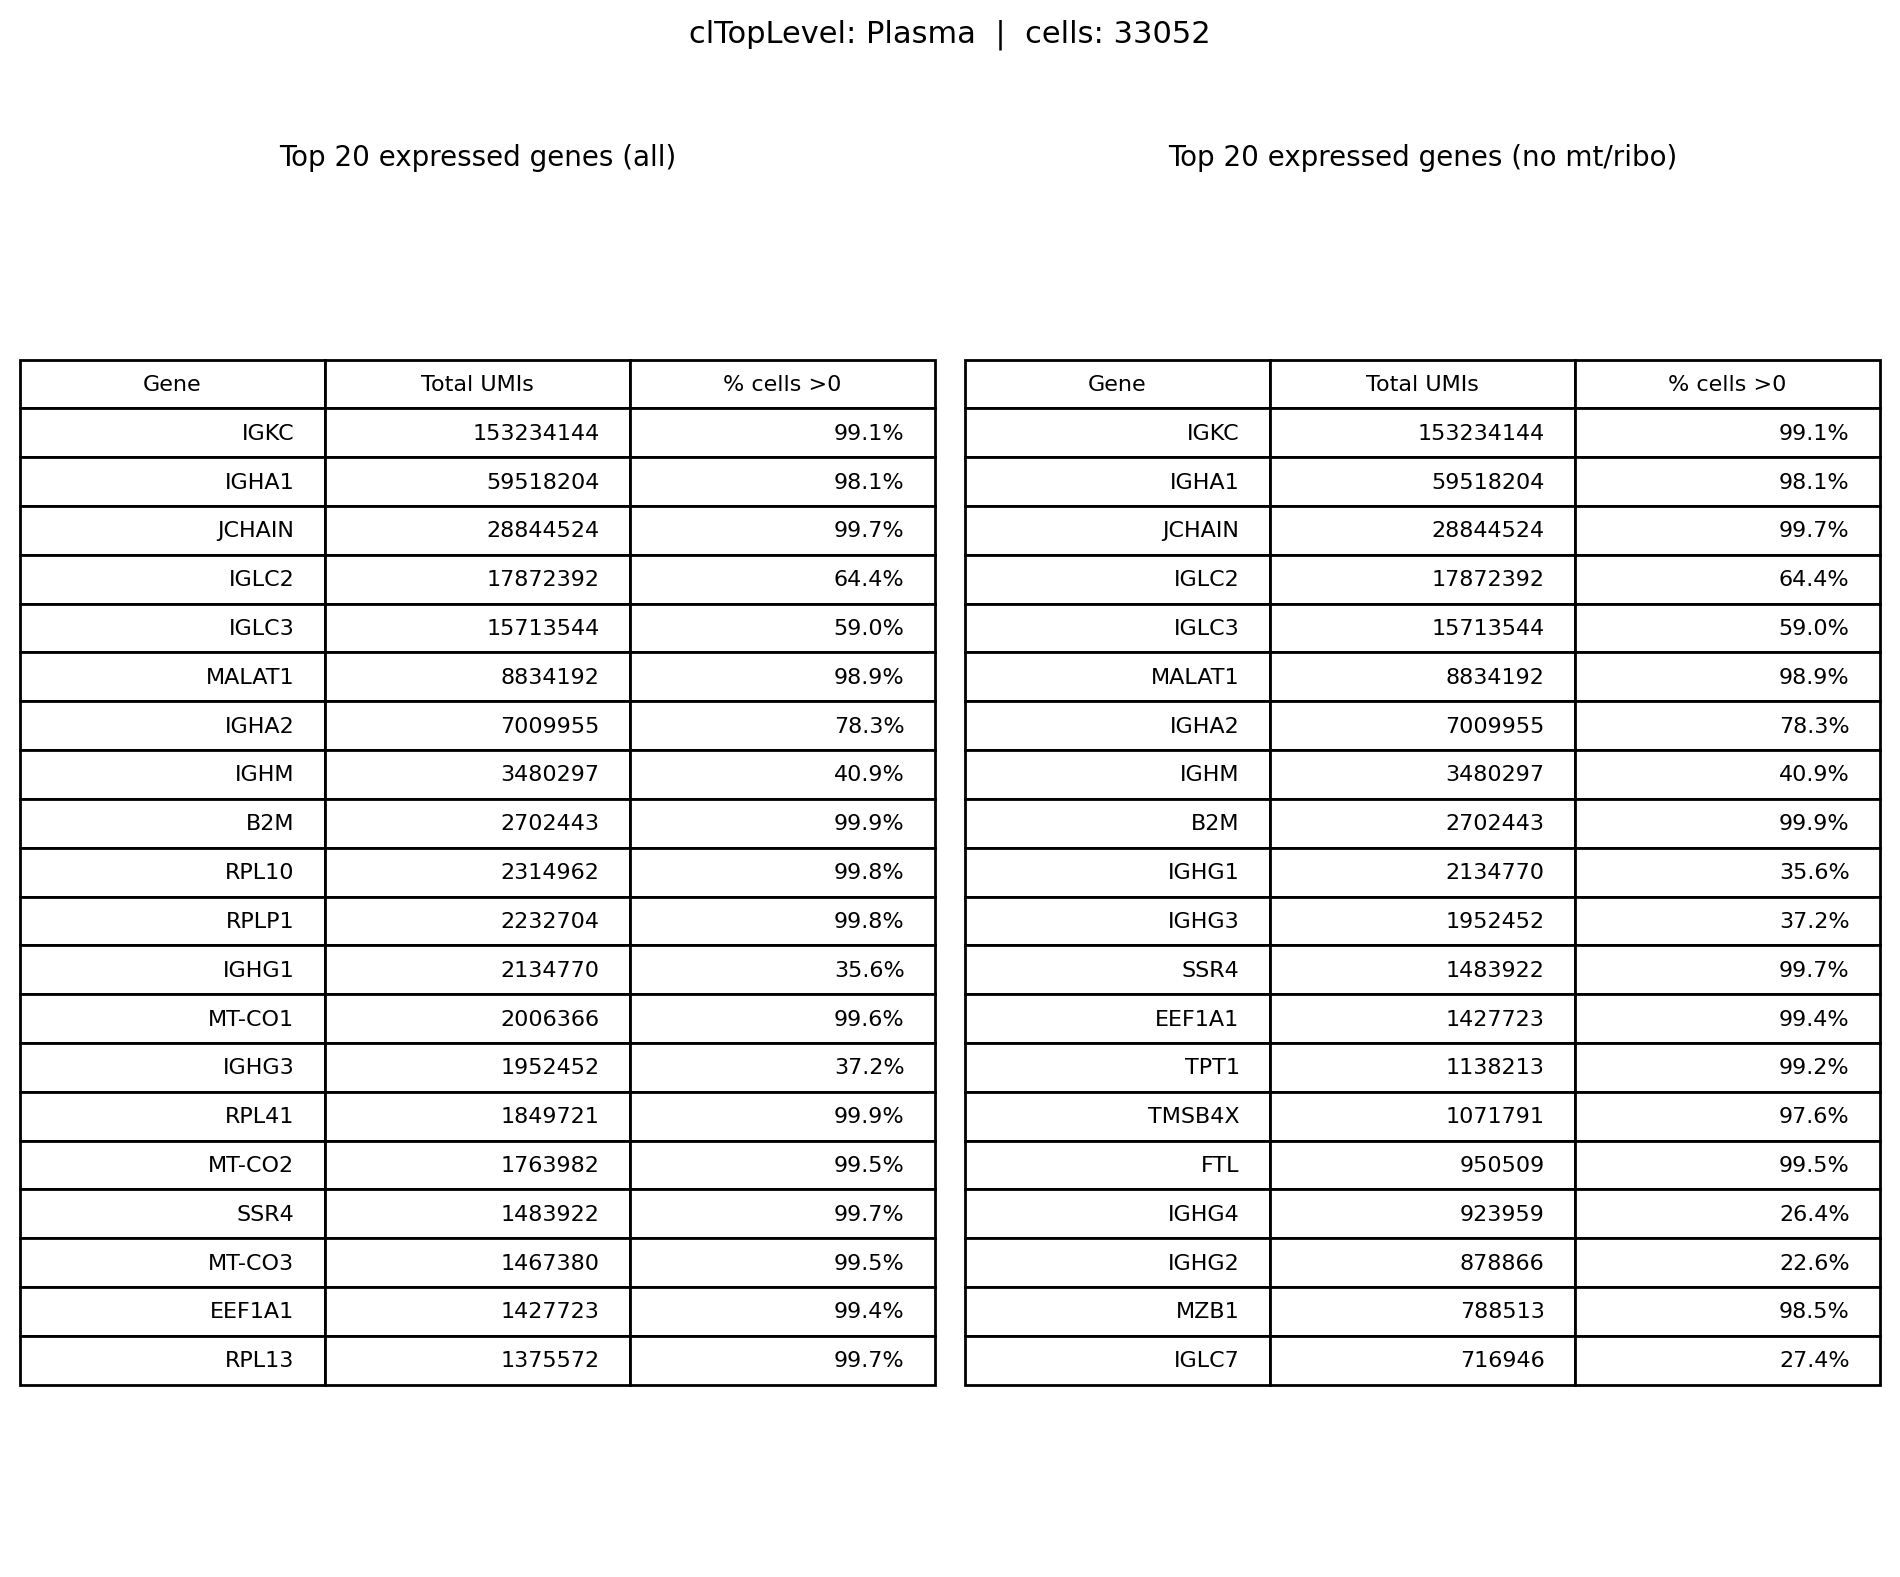

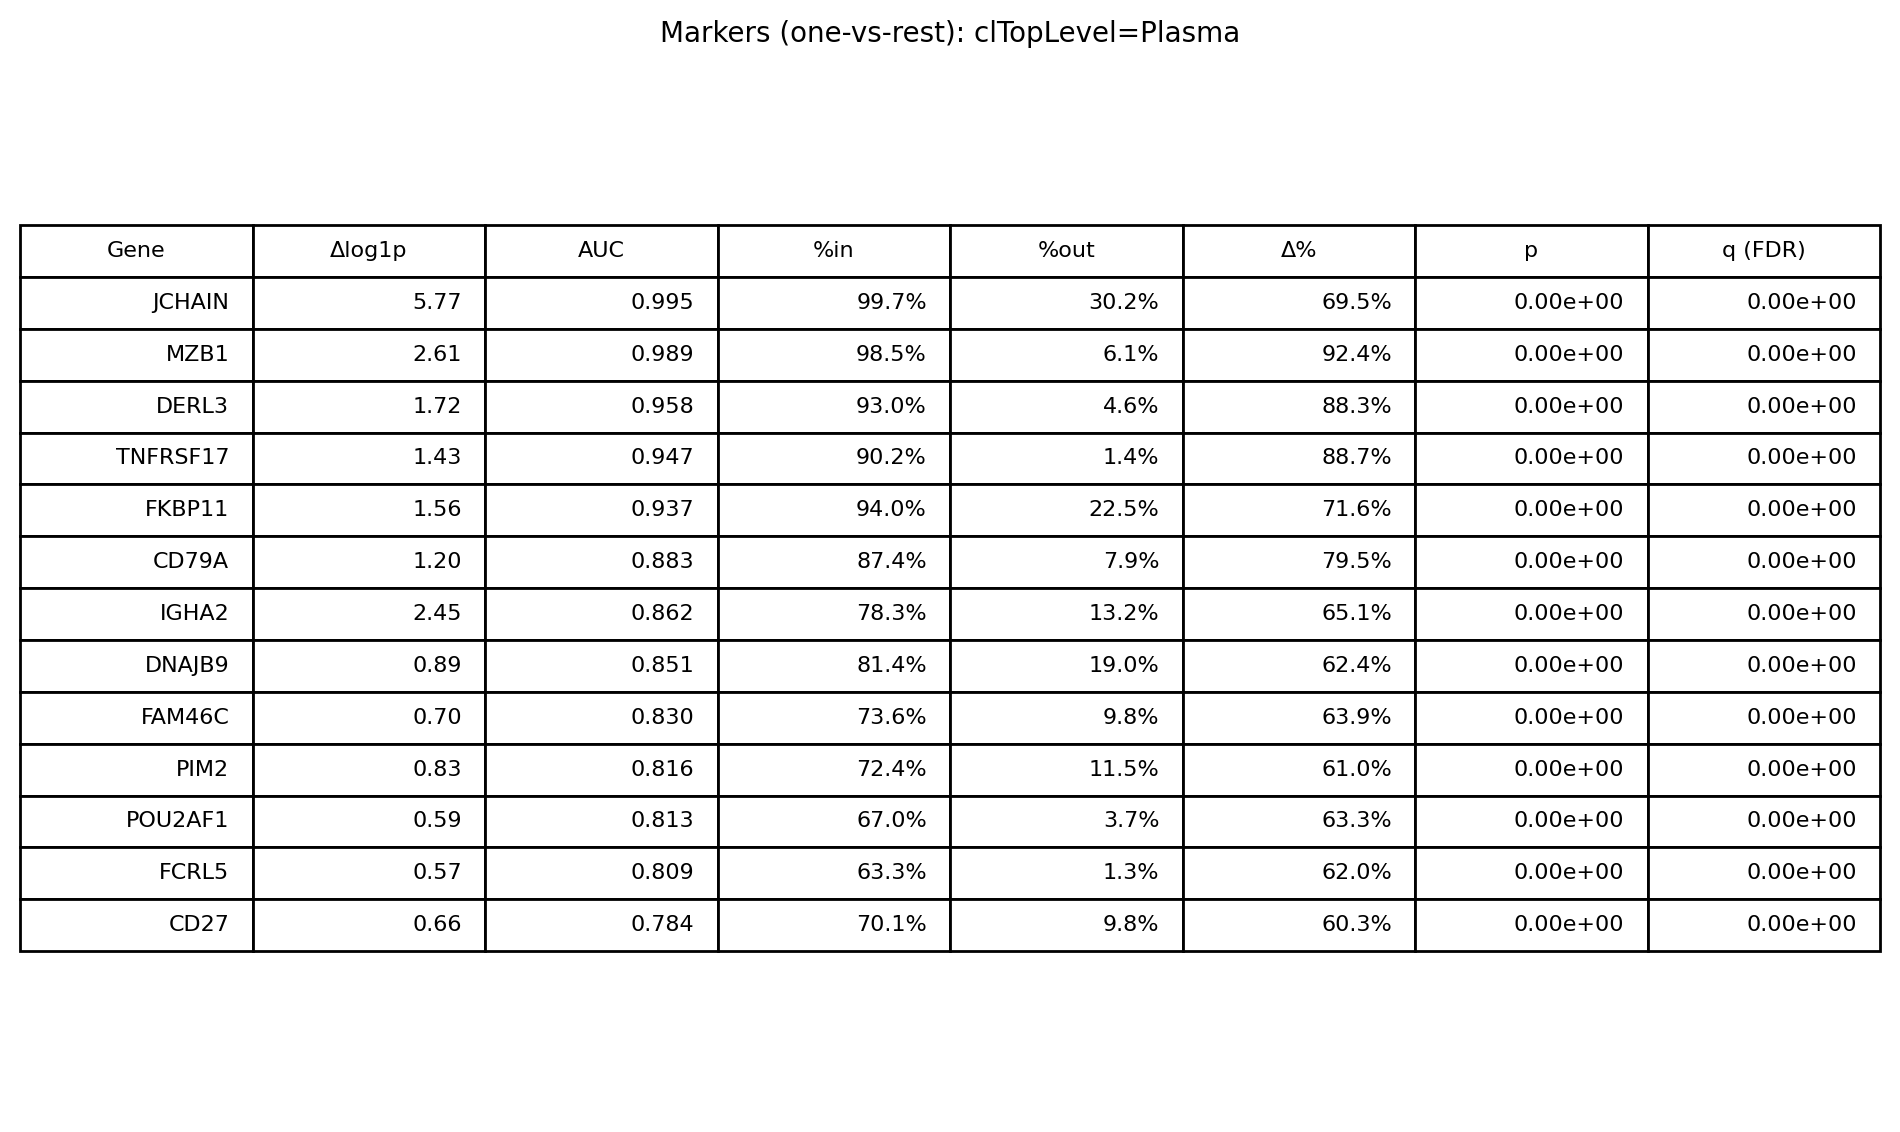

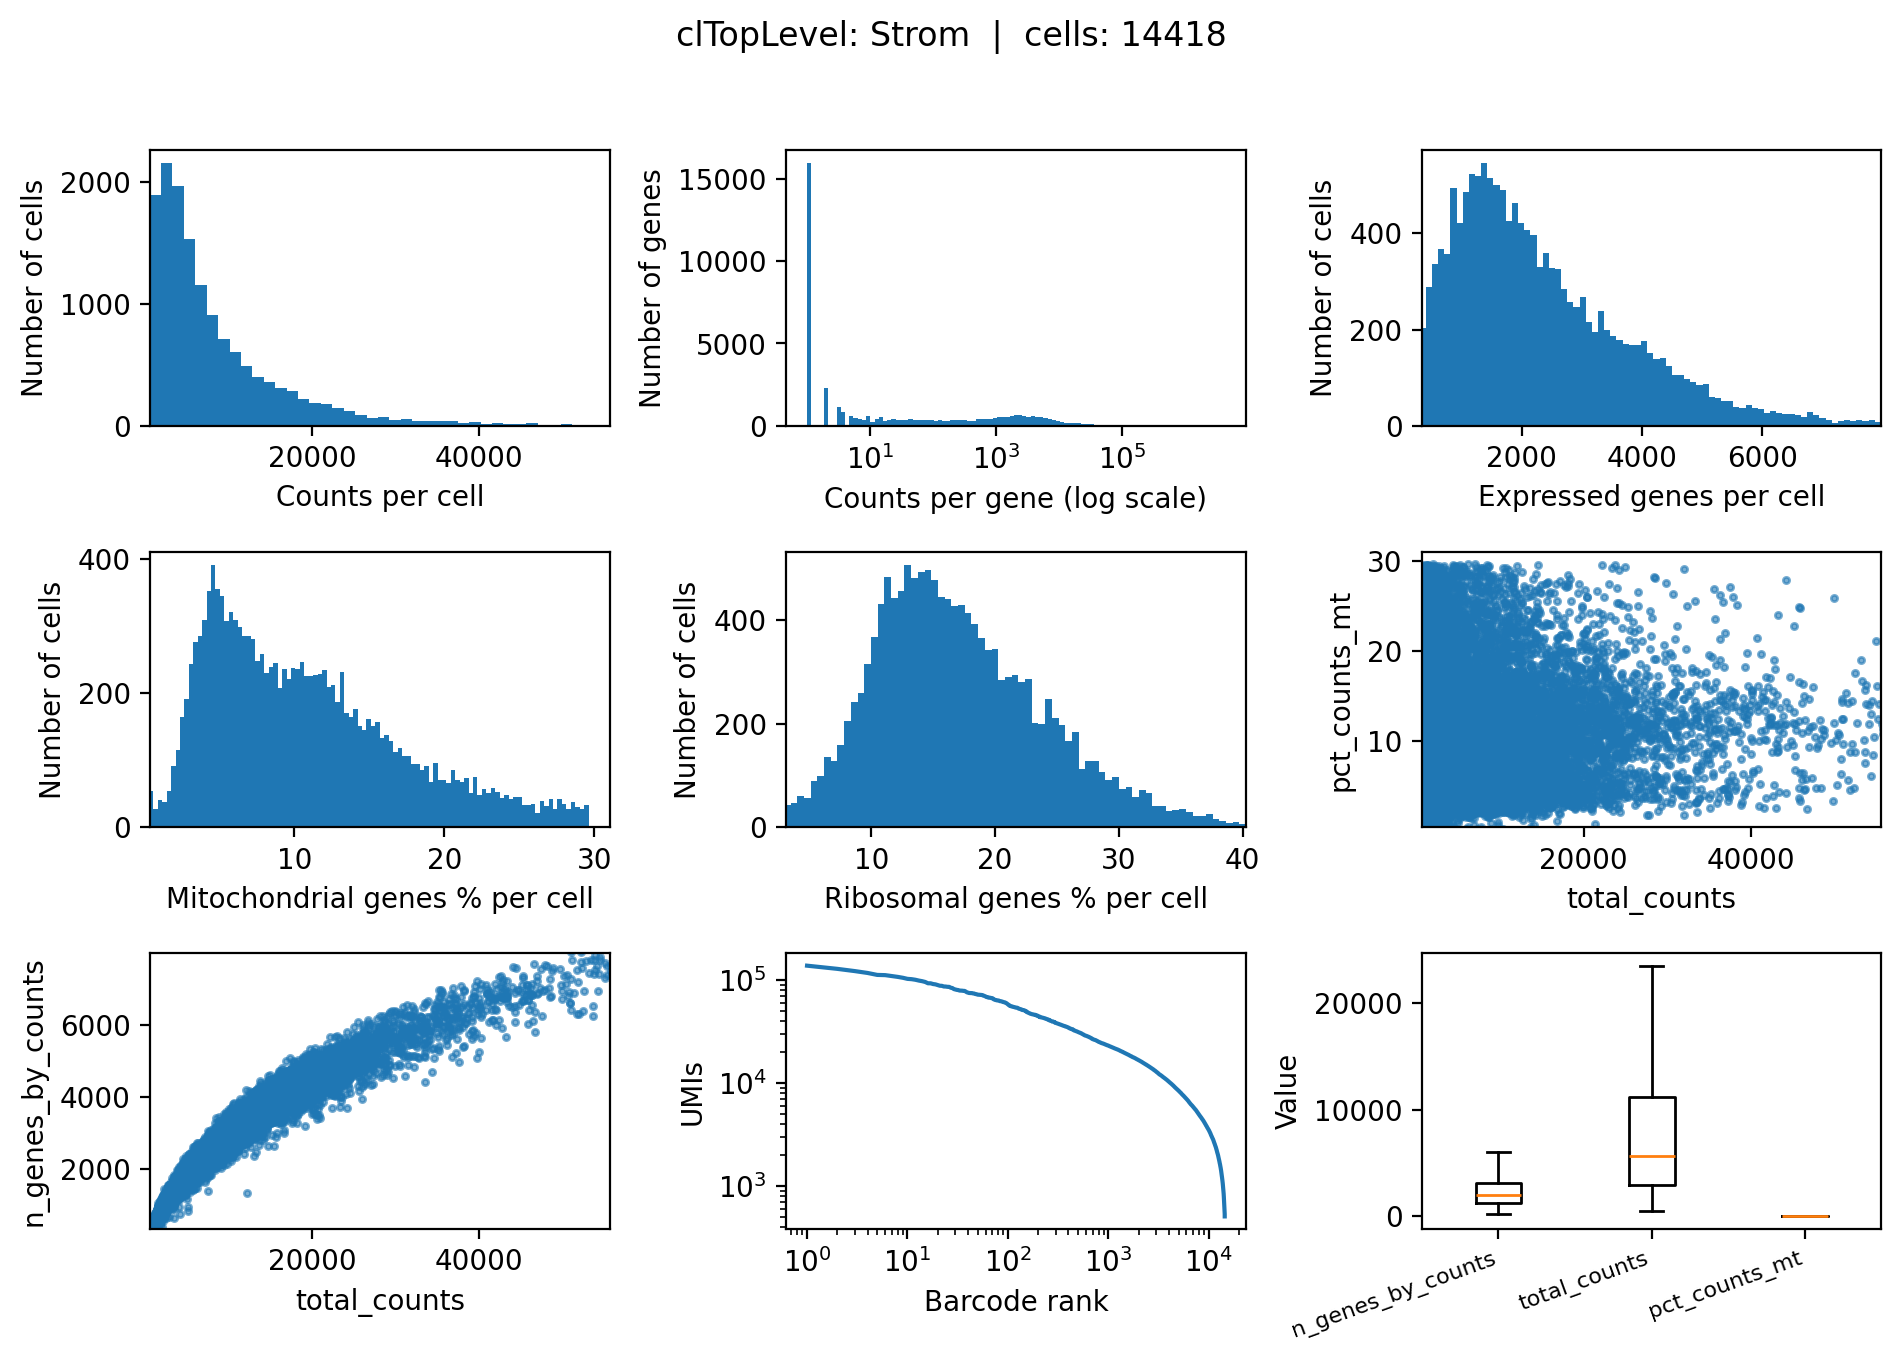

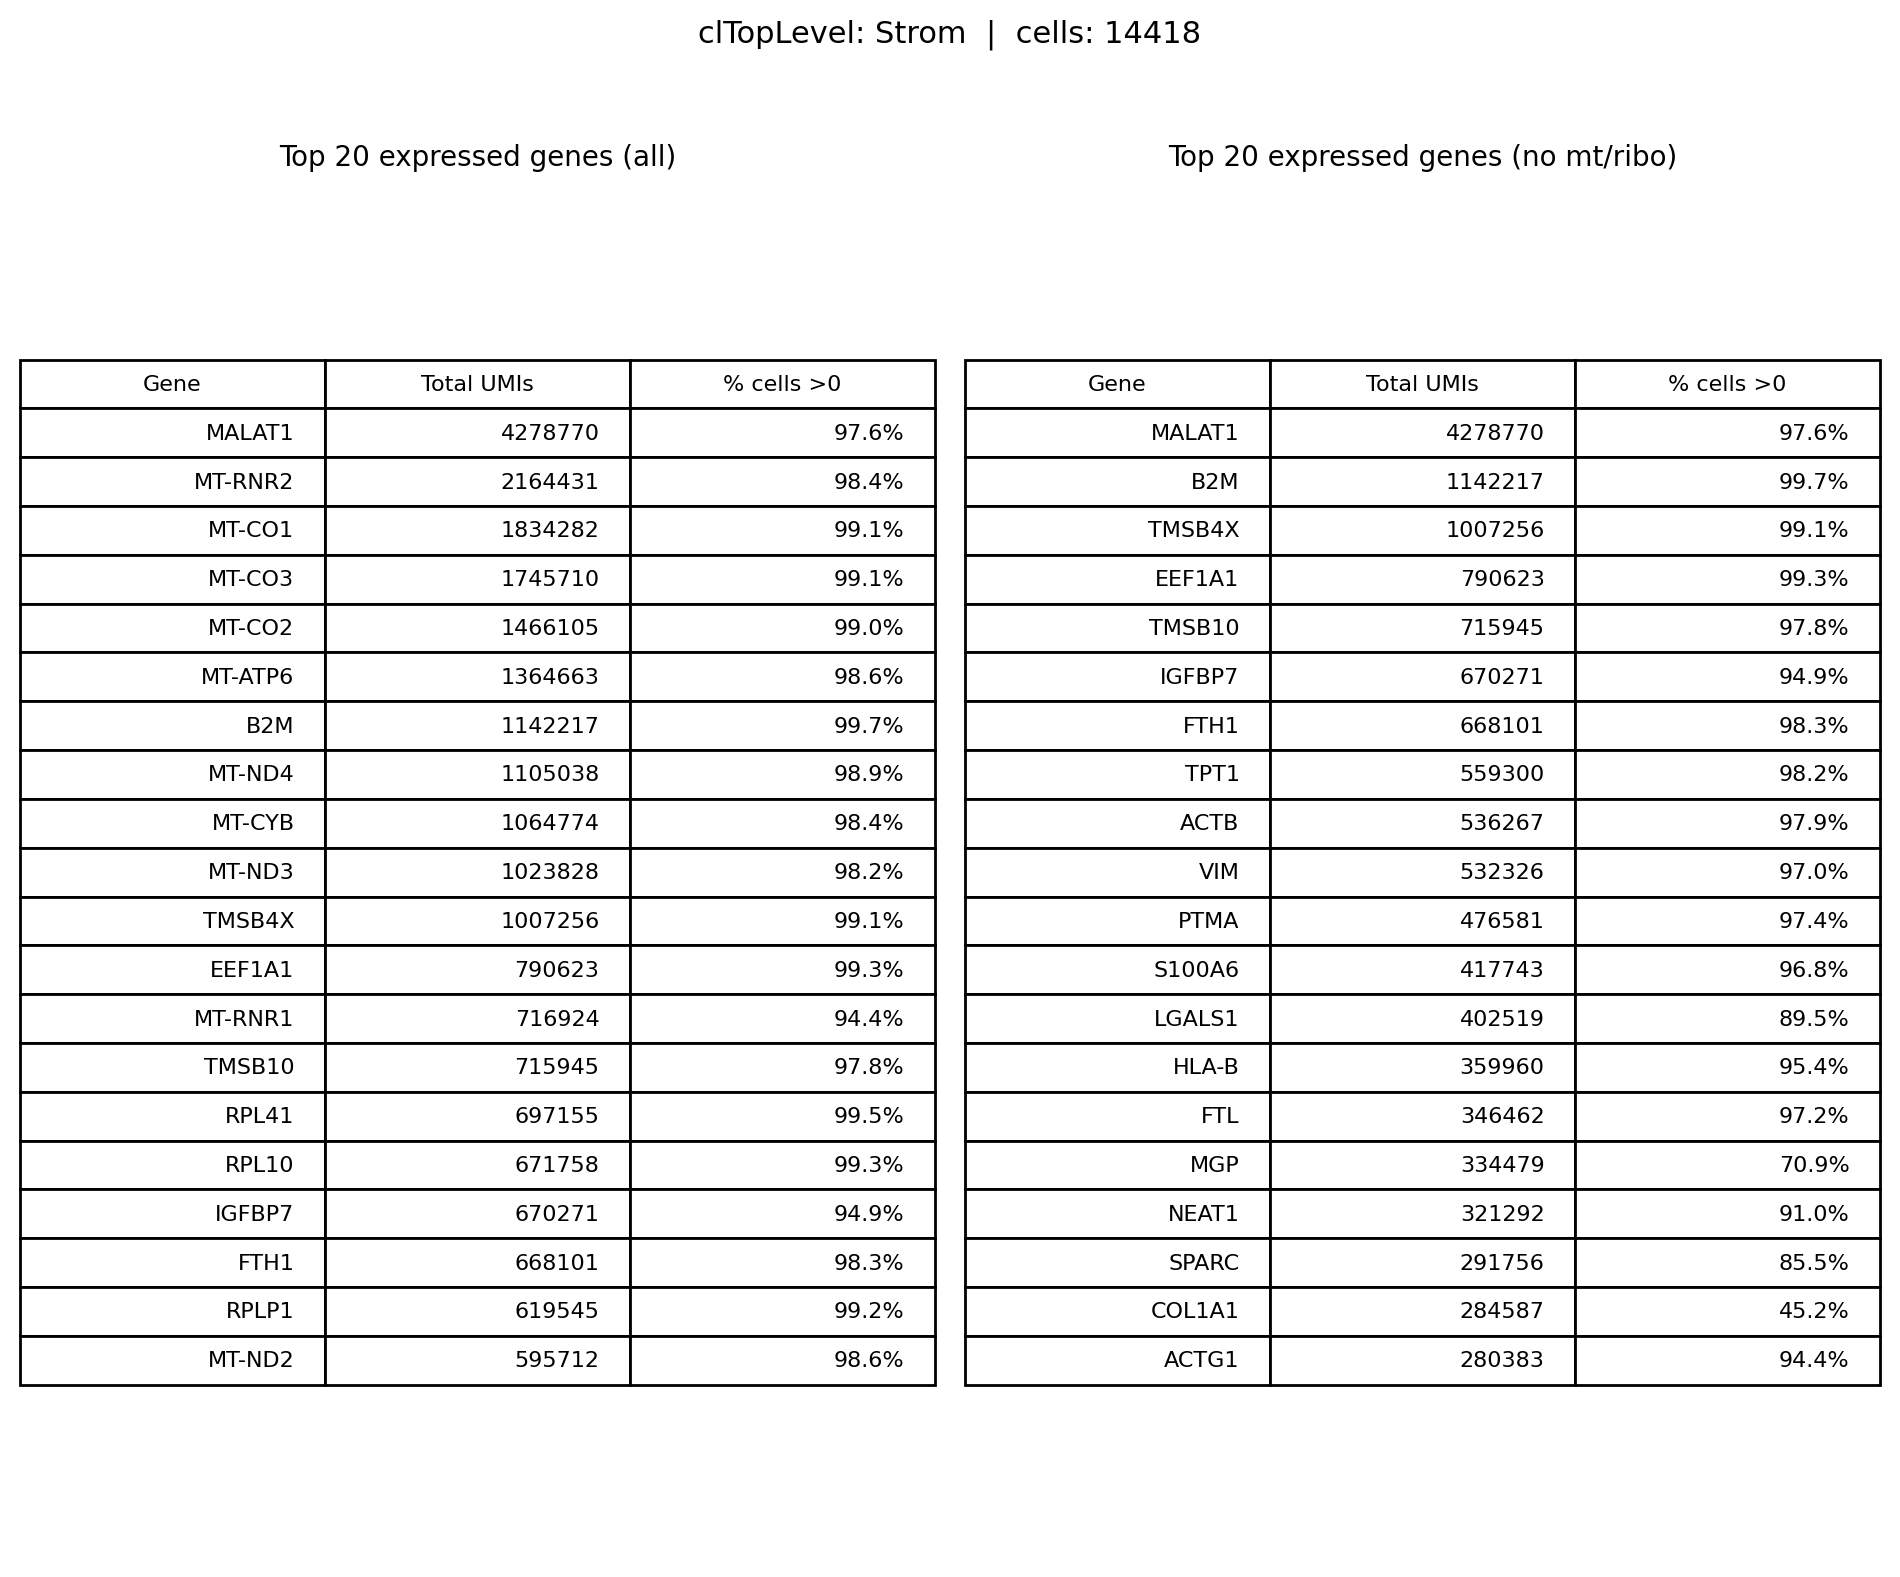

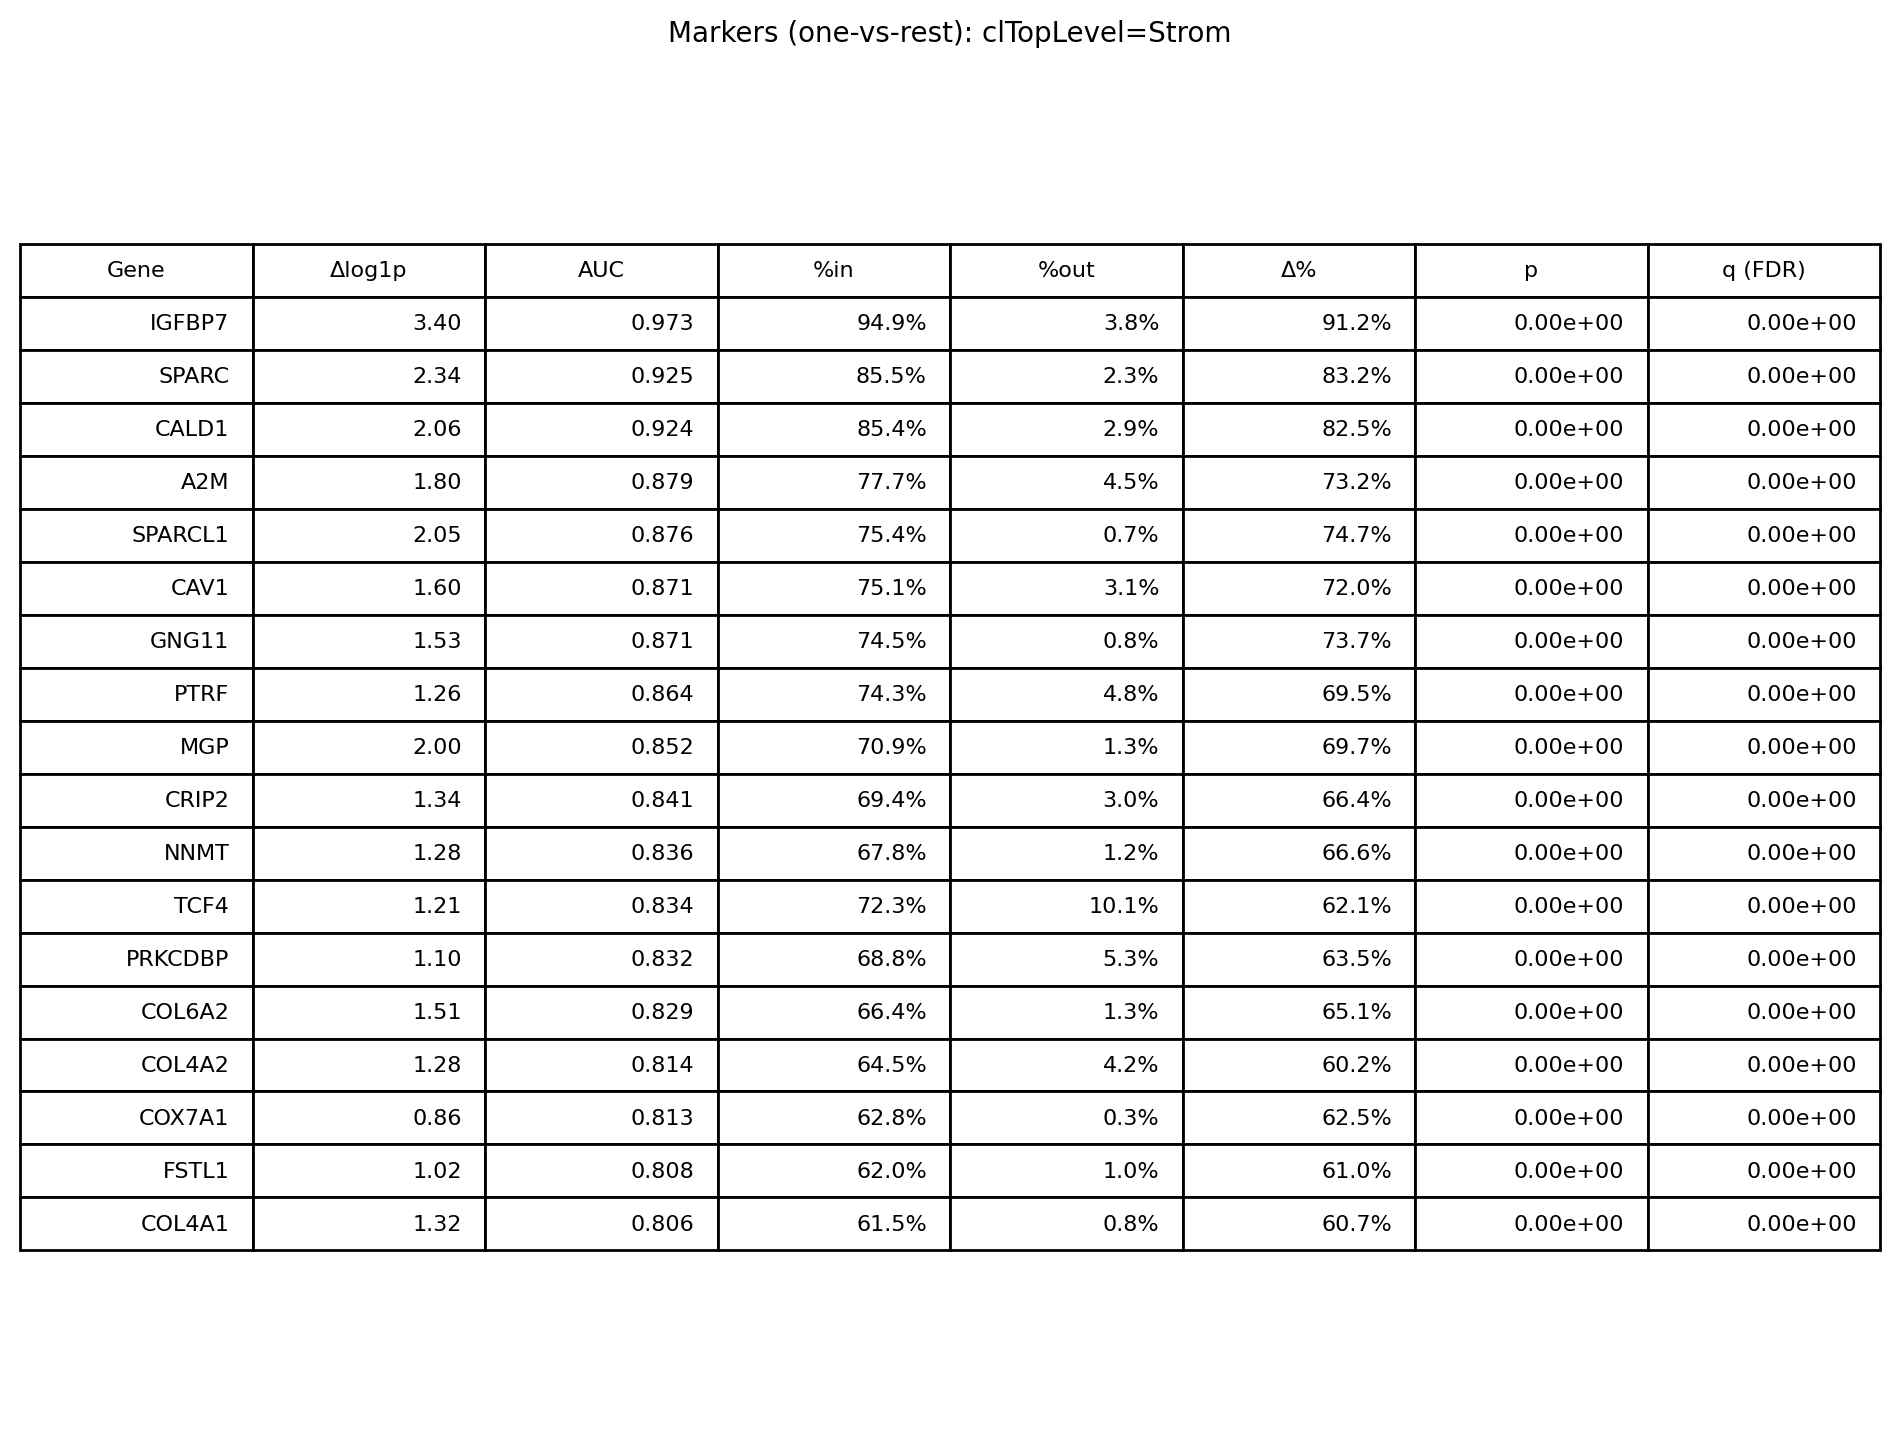

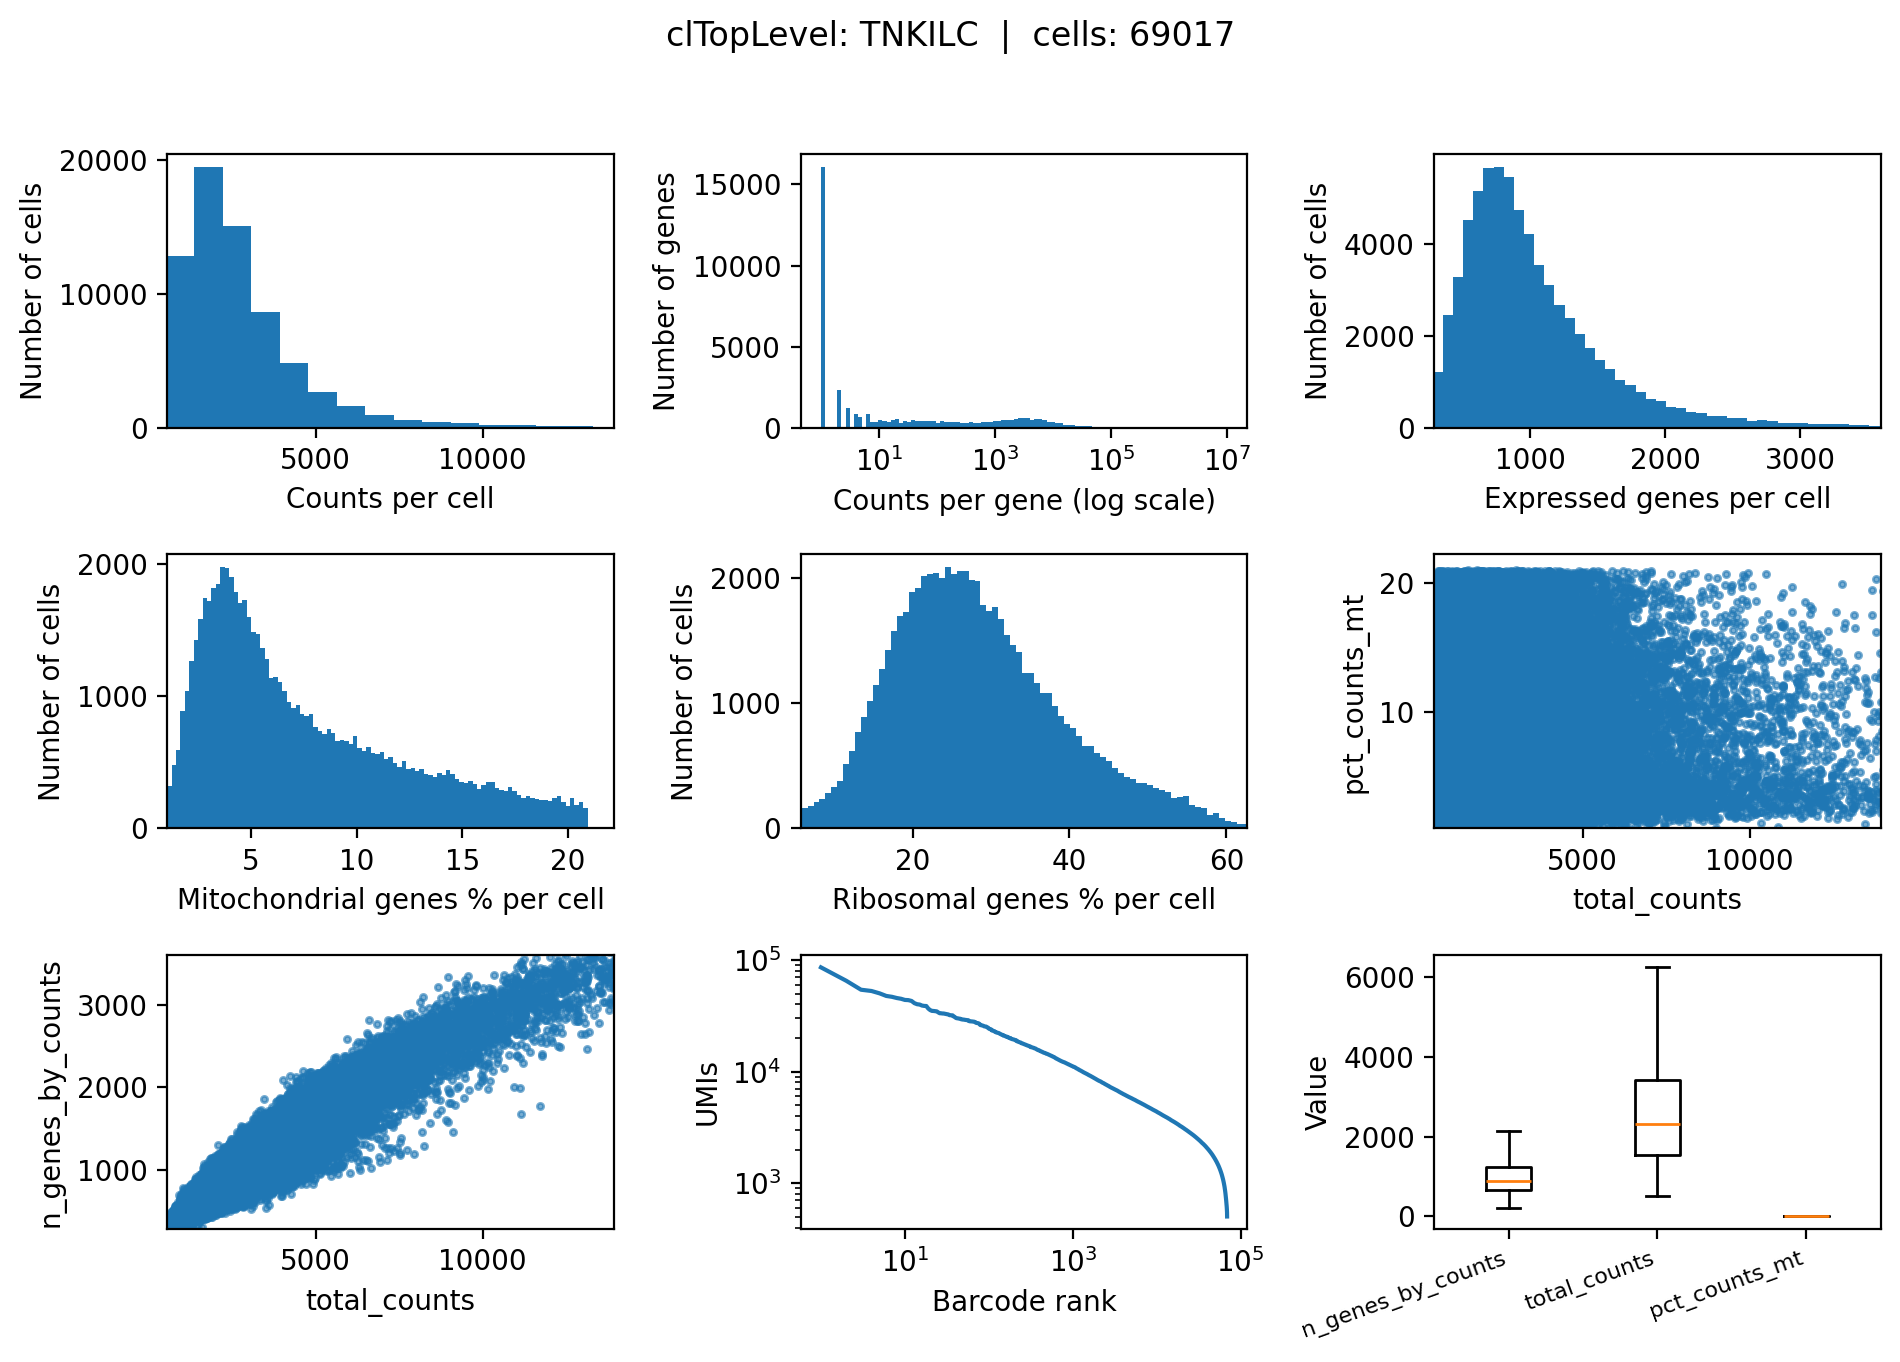

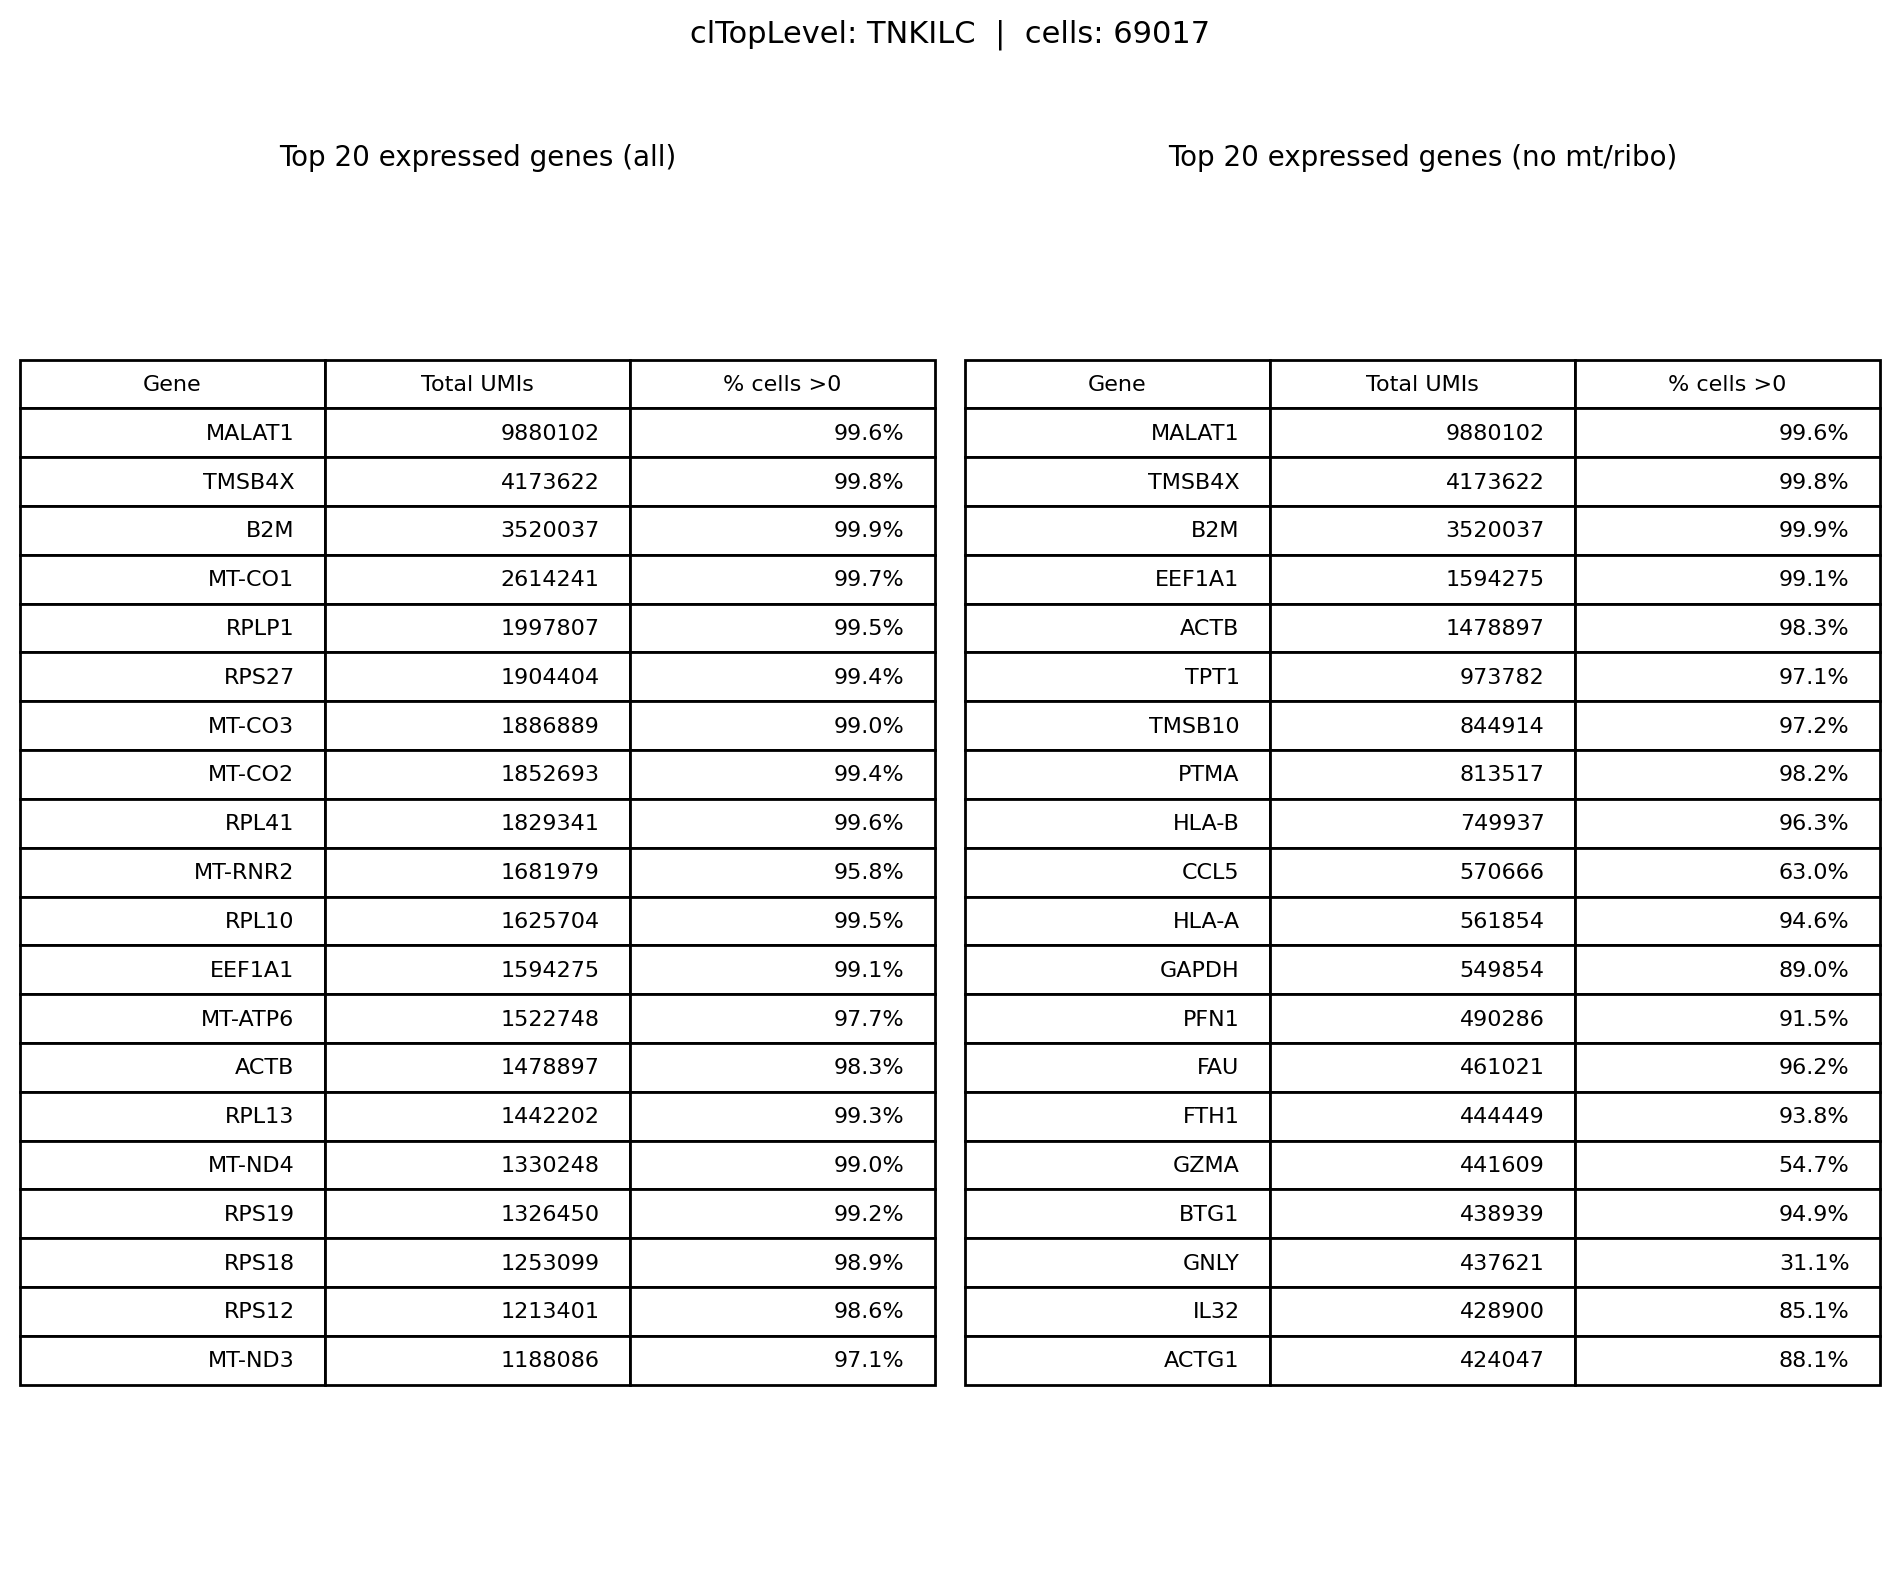

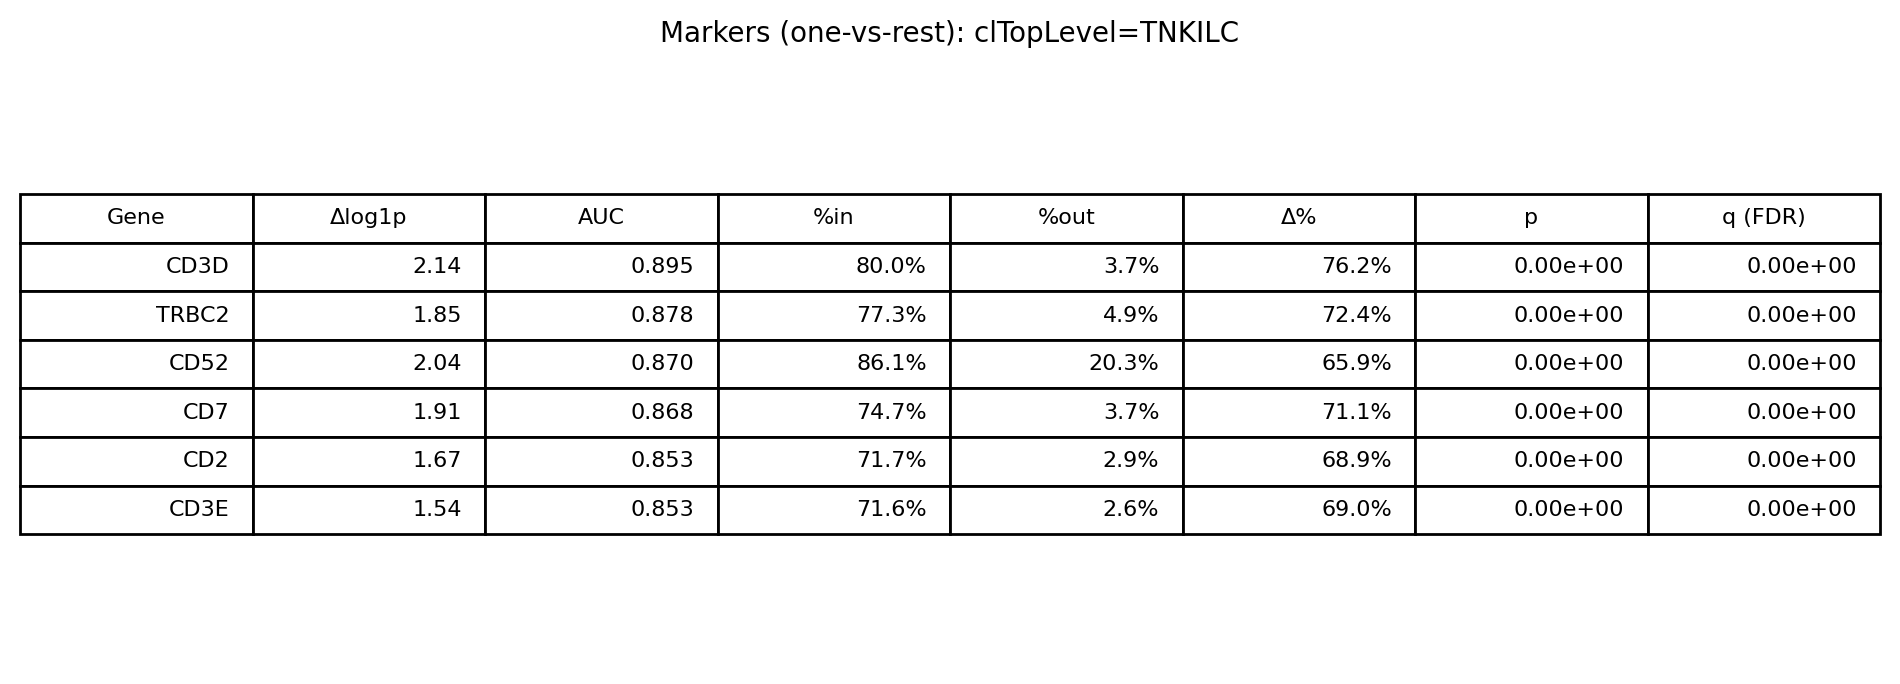

QC-by-group completed.
Number of groups processed: 7

Groups with detected marker genes:
  - B
  - Epi
  - Mast
  - Myeloid
  - Plasma
  - Strom
  - TNKILC


{'B': ['HLA-DRA', 'CD37', 'CD79A', 'HLA-DPB1', 'MS4A1', 'CD52', 'VPREB3'],
 'Epi': ['KRT8',
  'KRT18',
  'LGALS4',
  'EPCAM',
  'PHGR1',
  'TSPAN8',
  'SMIM22',
  'FXYD3',
  'ELF3',
  'CLDN3',
  'KRT19',
  'CLDN7',
  'AGR2',
  'CLDN4',
  'TMEM54',
  'IFI27',
  'TFF3',
  'C19orf33',
  'S100A14',
  'CEACAM5'],
 'Mast': ['TPSAB1',
  'TPSB2',
  'CPA3',
  'HPGDS',
  'LTC4S',
  'MS4A2',
  'CD69',
  'ALOX5AP',
  'CLU',
  'FCER1G',
  'KIT'],
 'Myeloid': ['TYROBP',
  'HLA-DRA',
  'FCER1G',
  'AIF1',
  'LYZ',
  'LST1',
  'HLA-DPB1',
  'S100A9',
  'SPI1',
  'MS4A6A',
  'HLA-DQA1',
  'CD14',
  'MS4A7'],
 'Plasma': ['JCHAIN',
  'MZB1',
  'DERL3',
  'TNFRSF17',
  'FKBP11',
  'CD79A',
  'IGHA2',
  'DNAJB9',
  'FAM46C',
  'PIM2',
  'POU2AF1',
  'FCRL5',
  'CD27'],
 'Strom': ['IGFBP7',
  'SPARC',
  'CALD1',
  'A2M',
  'SPARCL1',
  'CAV1',
  'GNG11',
  'PTRF',
  'MGP',
  'CRIP2',
  'NNMT',
  'TCF4',
  'PRKCDBP',
  'COL6A2',
  'COL4A2',
  'COX7A1',
  'FSTL1',
  'COL4A1'],
 'TNKILC': ['CD3D', 'TRBC2', 'CD

In [37]:
# -----------------------------
# Run QC-by-group report
# -----------------------------

markers = qc_by_group(
    adata,
    group_col='clTopLevel',
    min_cells=5,
    figure_scale=0.8,
    show_top_genes=True,
    show_markers=True,
    save_figs=SAVE_FIGS,
    fig_dir=FIG_DIR if SAVE_FIGS else None,
    show=True
)

# -----------------------------
# Summary of results
# -----------------------------
print("QC-by-group completed.")
print(f"Number of groups processed: {len(markers)}")

if len(markers) > 0:
    print("\nGroups with detected marker genes:")
    for k in markers.keys():
        print(f"  - {k}")
else:
    print("\nNo groups with marker genes passed the filters.")

# Optional: inspect markers dictionary
markers 


In [38]:
# -----------------------------
# Save QC-filtered AnnData (+ split by Tissue_type: N vs T)
# -----------------------------

# 1) Save the full QC-filtered dataset (canonical output)
out_path = OUT_DIR / "GSE178341_filtered.h5ad"

# Remove duplicate raw-counts layer to reduce file size
if "counts" in adata.layers:
    del adata.layers["counts"]

adata.write(out_path)
print(f"QC-filtered AnnData saved to: {out_path.resolve()}")

# 2) Split into Normal / Tumor (for CellChat or other downstream tools)
if "Tissue_type" not in adata.obs.columns:
    raise KeyError("Column 'Tissue_type' not found in adata.obs. Add it before splitting.")

# Optional: sanity check expected labels
print("\nTissue_type distribution:")
print(adata.obs["Tissue_type"].value_counts(dropna=False))

n0 = adata.n_obs

normal = adata[adata.obs["Tissue_type"] == "N"].copy()
tumor  = adata[adata.obs["Tissue_type"] == "T"].copy()

print(f"\nSplit completed (from {n0:,} cells):")
print(f"  Normal (N): {normal.n_obs:,} cells")
print(f"  Tumor  (T): {tumor.n_obs:,} cells")

normal_path = OUT_DIR / "GSE178341_normal.h5ad"
tumor_path  = OUT_DIR / "GSE178341_tumor.h5ad"

normal.write(normal_path)
tumor.write(tumor_path)

print(f"\nNormal AnnData saved to: {normal_path.resolve()}")
print(f"Tumor  AnnData saved to: {tumor_path.resolve()}")


QC-filtered AnnData saved to: /mnt/sda/amilek/10x_datasets/GSE178341/outputs/GSE178341_filtered.h5ad

Tissue_type distribution:
Tissue_type
T      222831
N      107150
NaN     19743
Name: count, dtype: int64

Split completed (from 349,724 cells):
  Normal (N): 107,150 cells
  Tumor  (T): 222,831 cells

Normal AnnData saved to: /mnt/sda/amilek/10x_datasets/GSE178341/outputs/GSE178341_normal.h5ad
Tumor  AnnData saved to: /mnt/sda/amilek/10x_datasets/GSE178341/outputs/GSE178341_tumor.h5ad
